In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import argrelmax, spectrogram, correlate, correlate2d
from scipy.cluster.vq import kmeans, vq
import ruptures as rpt
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
sns.set()

# Synthetic Data Analysis

## Data Overview

### Imports

In [2]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"
ref_file_path = "acquisitions/synthetic_test/processed/processed_combined_acquisition_2024-01-14_21-20-48.csv"
# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_ref = pd.read_csv(ref_file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_ref['_time'] = pd.to_datetime(df_ref['_time'])

### Raw Data Analysis

##### Functions

In [3]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, action):

    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['action'] == action)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Action {action}')
    plt.show()

In [4]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

##### Code

In [5]:
df.head()

_time  series_id  measurement_id      action    gyro_x  \
0 2023-12-29 16:50:56.247487          0               0  floating_x  1.865854   
1 2023-12-29 16:50:56.262481          0               1  floating_x  1.865854   
2 2023-12-29 16:50:56.276026          0               2  floating_x  1.743902   
3 2023-12-29 16:50:56.291837          0               3  floating_x  0.280488   
4 2023-12-29 16:50:56.306791          0               4  floating_x -0.878049   

     gyro_y    gyro_z   accel_x   accel_y   accel_z  quat_x  quat_y  quat_z  \
0  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68    0.21   
1  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68    0.21   
2 -0.164634  0.182927  0.004077  0.000659  0.006201    -0.7    0.68    0.21   
3 -1.506098  0.243902  0.003345 -0.003735 -0.007471    -0.7    0.68    0.21   
4 -1.567073 -0.060976  0.004565 -0.008130 -0.011377    -0.7    0.68    0.21   

   quat_w  
0     0.1  
1     0.1  
2     0.1  
3     0.1  
4     0.1

In [6]:
df.describe()

_time    series_id  measurement_id  \
count                           3457  3457.000000     3457.000000   
mean   2023-12-29 16:57:36.316104448     5.216951      170.265259   
min       2023-12-29 16:49:52.689785     0.000000        0.000000   
25%    2023-12-29 16:52:47.497299968     2.000000       72.000000   
50%    2023-12-29 16:56:23.786156032     5.000000      149.000000   
75%    2023-12-29 17:02:53.938644992     9.000000      248.000000   
max       2023-12-29 17:08:48.633000    11.000000      500.000000   
std                              NaN     3.722790      121.300390   

            gyro_x       gyro_y       gyro_z      accel_x      accel_y  \
count  3457.000000  3457.000000  3457.000000  3457.000000  3457.000000   
mean     -4.114510     0.755942    -0.869745    -0.106049    -0.097238   
min    -777.884146  -337.158537  -232.682927    -1.948242    -2.094897   
25%      -8.073171    -9.926829   -15.280488    -0.266504    -0.099365   
50%       0.146341     0.030488    -0.146341    -0.001611    -0.008472   
75%      15.128049    10.182927     6.024390     0.033301     0.009595   
max     203.975610   576.463415   715.134146     1.710742     0.819019   
std      71.090067    74.537029    65.122563     0.437289     0.338756   

           accel_z       quat_x       quat_y       quat_z       quat_w  
count  3457.000000  3457.000000  3457.000000  3457.000000  3457.000000  
mean      0.046940     0.051449     0.272953     0.070223     0.254709  
min      -0.991528    -0.980000    -0.980000    -0.990000     0.000000  
25%      -0.023169    -0.610000    -0.210000    -0.170000     0.070000  
50%       0.007153     0.210000     0.530000     0.100000     0.180000  
75%       0.091650     0.640000     0.690000     0.320000     0.430000  
max       2.023047     0.990000     0.990000     1.000000     0.970000  
std       0.441120     0.630403     0.530645     0.357432     0.216536

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _time           3457 non-null   datetime64[ns]
 1   series_id       3457 non-null   int64         
 2   measurement_id  3457 non-null   int64         
 3   action          3457 non-null   object        
 4   gyro_x          3457 non-null   float64       
 5   gyro_y          3457 non-null   float64       
 6   gyro_z          3457 non-null   float64       
 7   accel_x         3457 non-null   float64       
 8   accel_y         3457 non-null   float64       
 9   accel_z         3457 non-null   float64       
 10  quat_x          3457 non-null   float64       
 11  quat_y          3457 non-null   float64       
 12  quat_z          3457 non-null   float64       
 13  quat_w          3457 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
m

In [8]:
# groupby by action
df_grouped = df.groupby('action')

# Grouping data by series_id and action
df_grouped_id = df.groupby(['series_id', 'action']).size().unstack(fill_value=0)
# show all the actions
# print(df_grouped.groups.keys())

Check how many samples there are in each sequence.

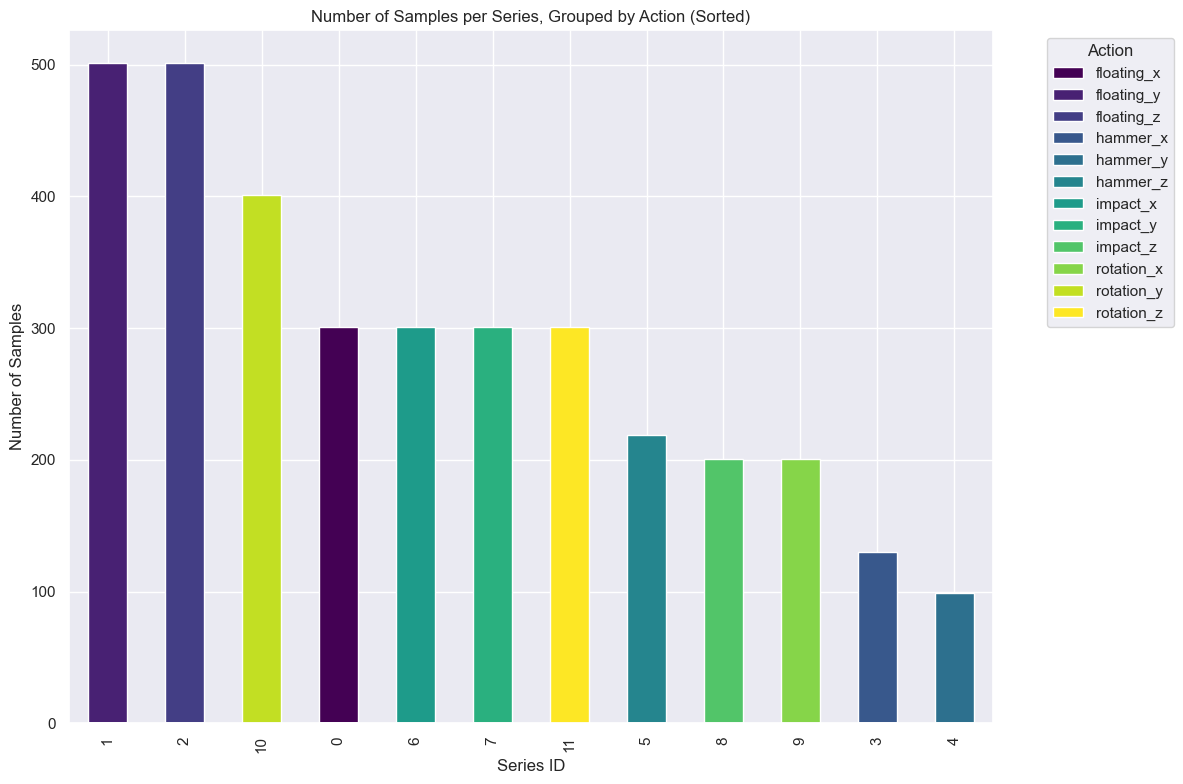

In [9]:

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = df_grouped_id.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = df_grouped_id.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

Correlation matrix to see the relations among features for each sequence

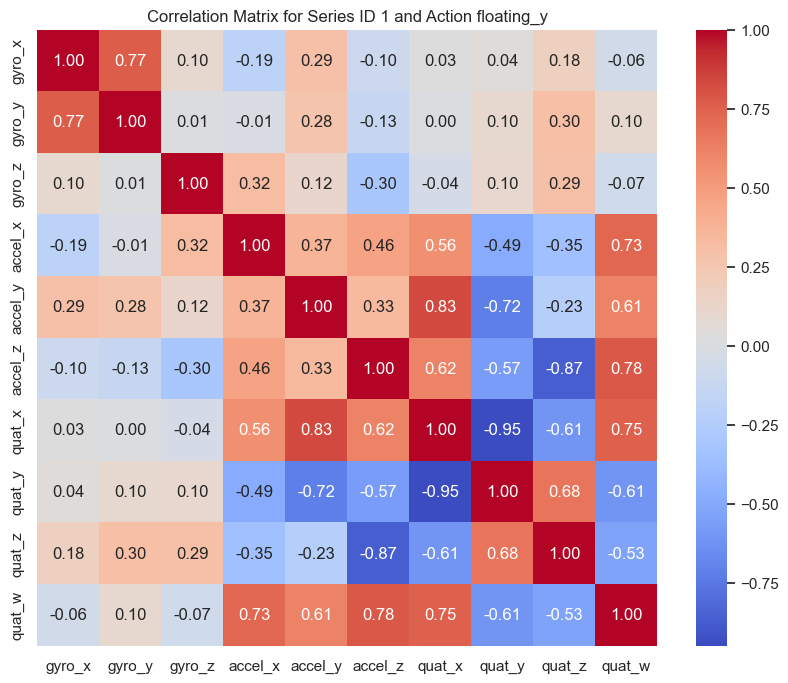

In [10]:
# plot_correlation_matrix(df,'floating_x')
plot_correlation_matrix(df,'floating_y')
# plot_correlation_matrix(df,'floating_z')
# plot_correlation_matrix(df,'hammer_x')
# plot_correlation_matrix(df,'hammer_y')
# plot_correlation_matrix(df,'hammer_z')
# plot_correlation_matrix(df,'impact_x')
# plot_correlation_matrix(df,'impact_y')
# plot_correlation_matrix(df,'impact_z')
# plot_correlation_matrix(df,'rotation_x')
# plot_correlation_matrix(df,'rotation_y')
# plot_correlation_matrix(df,'rotation_z')


In [11]:
df_time = df.copy()
df_time['time_diff'] = df_time.groupby('series_id')['_time'].diff()
df_time = df_time.dropna()
df_time['time_diff_seconds'] = df_time['time_diff'].dt.total_seconds()

Visualize the sampling time difference distribution for each sequence

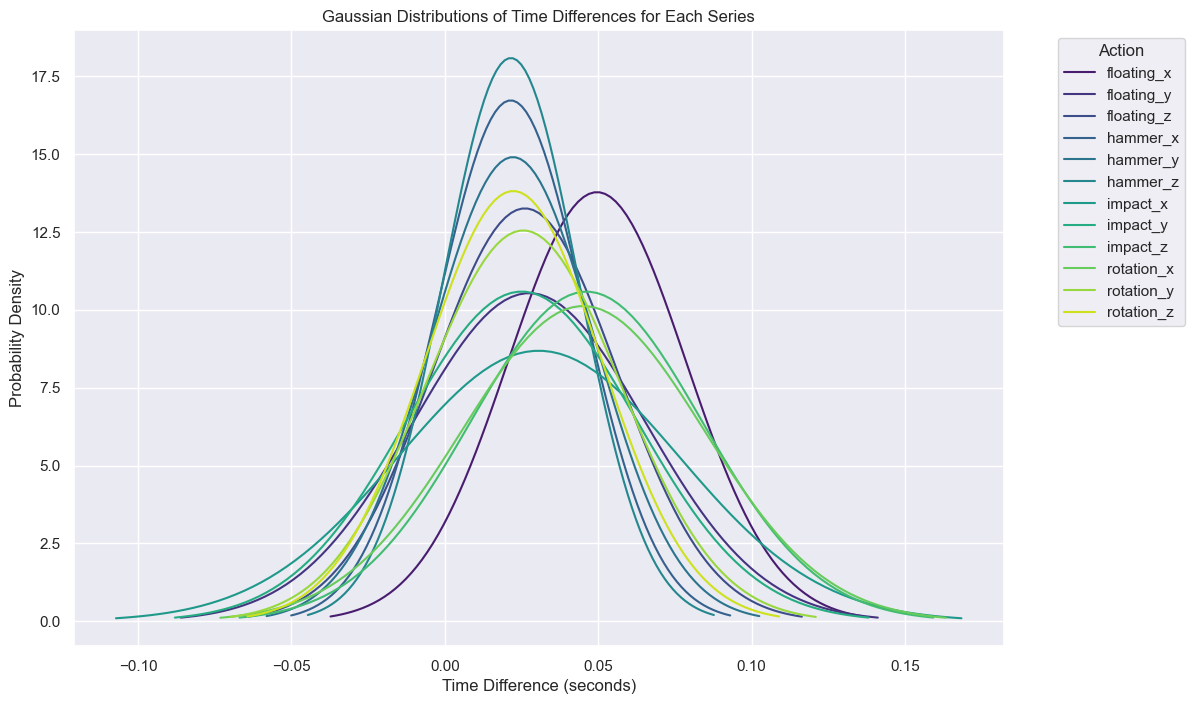

-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Slowest sampling time: 0.05 seconds
Fastest sampling time: 0.02 seconds


In [12]:
# Create a mapping of series_id to action
action_mapping = df_time.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(df_time['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(df_time['series_id'].unique())):
    # Selecting the series
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()

# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in df_time['series_id'].unique():
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    # print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

print(f'Slowest sampling time: {round(max(series_mean), 2)} seconds')
print(f'Fastest sampling time: {round(min(series_mean), 2)} seconds')

In [13]:
df_floatingx = df_grouped.get_group('floating_x')
df_floatingy = df_grouped.get_group('floating_y')
df_floatingz = df_grouped.get_group('floating_z')
df_hammerx = df_grouped.get_group('hammer_x')
df_hammery = df_grouped.get_group('hammer_y')
df_hammerz = df_grouped.get_group('hammer_z')
df_impactx = df_grouped.get_group('impact_x')
df_impacty = df_grouped.get_group('impact_y')
df_impactz = df_grouped.get_group('impact_z')
df_rotationx = df_grouped.get_group('rotation_x')
df_rotationy = df_grouped.get_group('rotation_y')
df_rotationz = df_grouped.get_group('rotation_z')

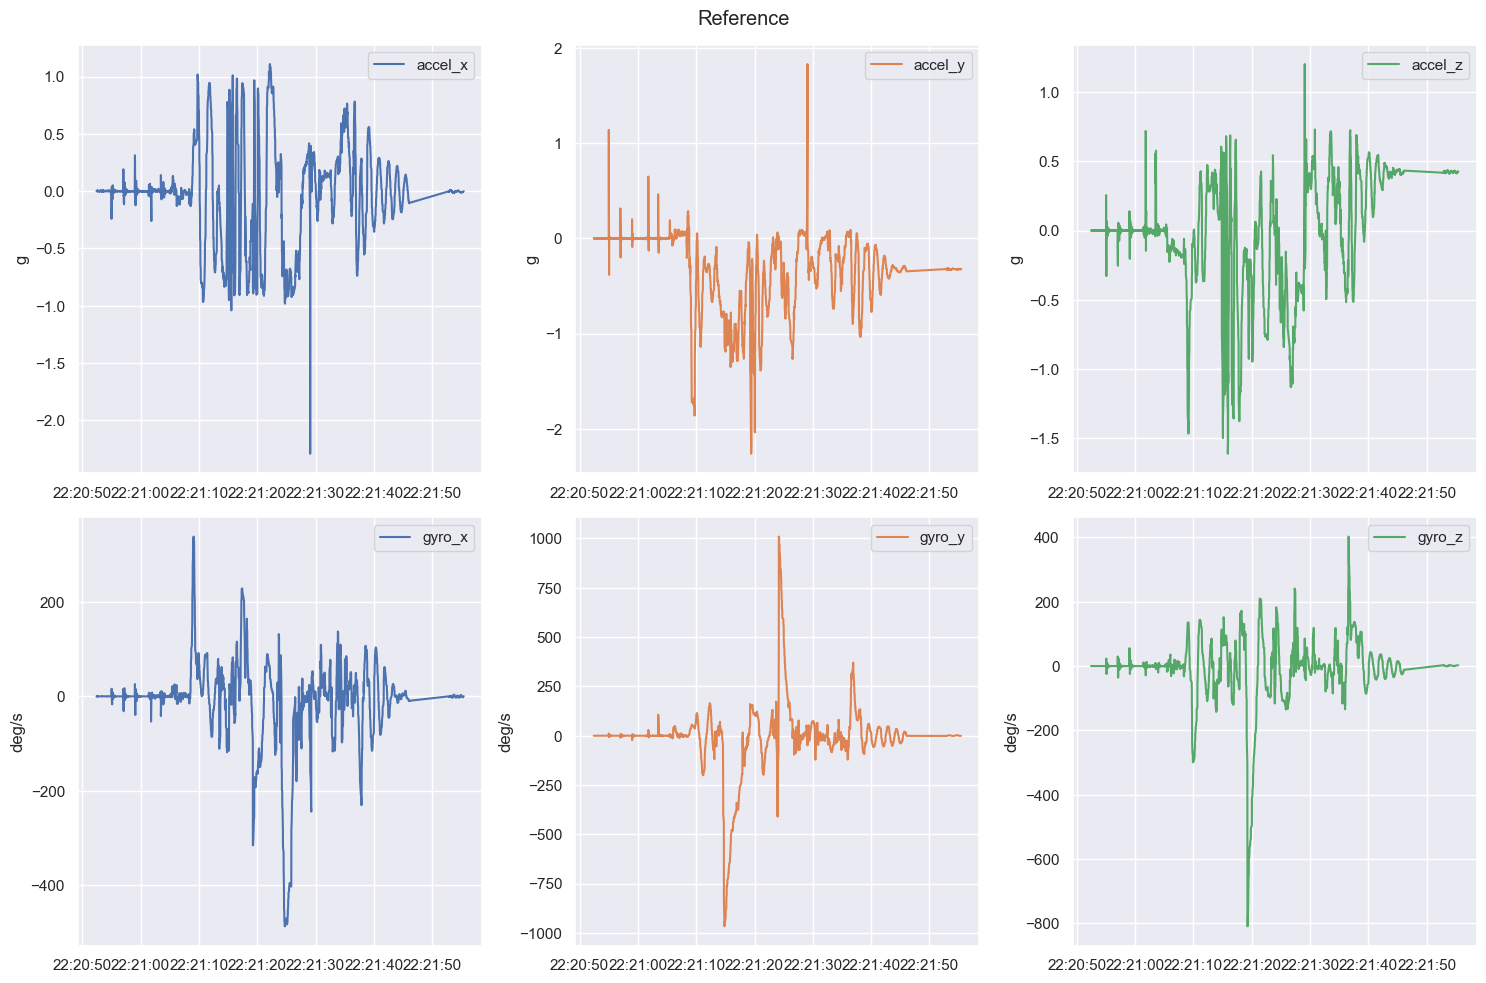

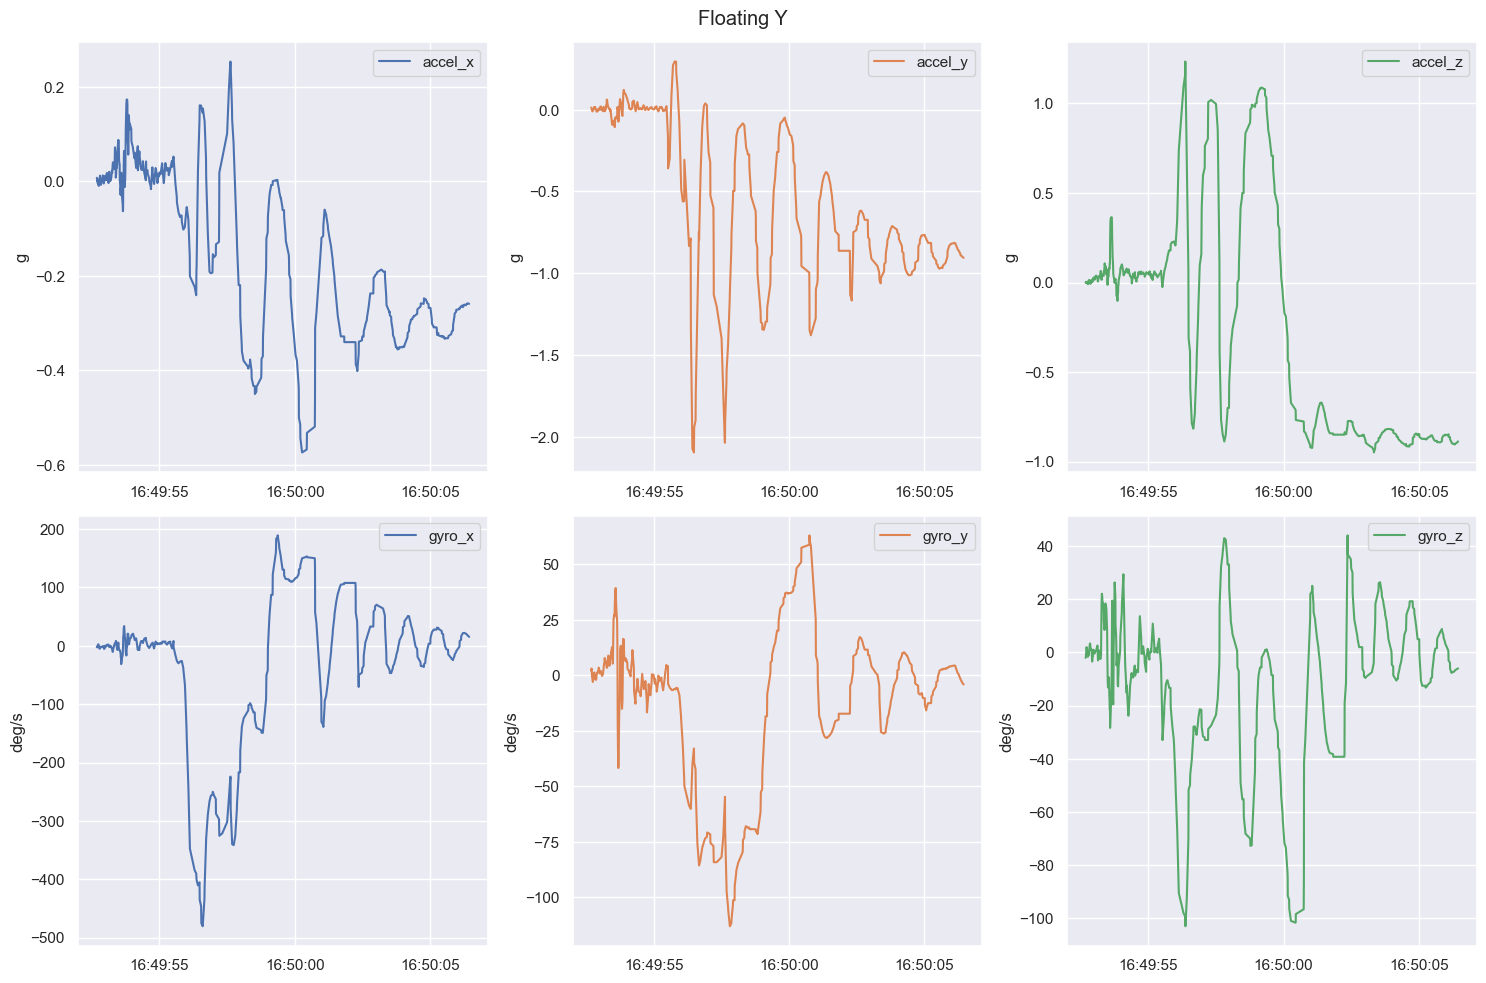

In [14]:
# plot reference data
plot_sensors_df(df_ref, "Reference", x_index='_time')

# plot all the actions

# plot_sensors_df(df_floatingx, "Floating X", x_index='_time')
plot_sensors_df(df_floatingy, "Floating Y", x_index='_time')
# plot_sensors_df(df_floatingz, "Floating Z", x_index='_time')
# plot_sensors_df(df_hammerx, "Hammer X", x_index='_time')
# plot_sensors_df(df_hammery, "Hammer Y", x_index='_time')
# plot_sensors_df(df_hammerz, "Hammer Z", x_index='_time')
# plot_sensors_df(df_impactx, "Impact X", x_index='_time')
# plot_sensors_df(df_impacty, "Impact Y", x_index='_time')
# plot_sensors_df(df_impactz, "Impact Z", x_index='_time')
# plot_sensors_df(df_rotationx, "Rotation X", x_index='_time')
# plot_sensors_df(df_rotationy, "Rotation Y", x_index='_time')
# plot_sensors_df(df_rotationz, "Rotation Z", x_index='_time')

## Data Manipulation

### Re-sampling

In [219]:
# resample the dataset to 0.01s
sampling_time = 0.01

# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']
df_ref_over = df_ref[columns].copy()
df_floatinx_over = df_floatingx[columns].copy()
df_floatiny_over = df_floatingy[columns].copy()
df_floatinz_over = df_floatingz[columns].copy()
df_hammerx_over = df_hammerx[columns].copy()
df_hammery_over = df_hammery[columns].copy()
df_hammerz_over = df_hammerz[columns].copy()
df_impactx_over = df_impactx[columns].copy()
df_impacty_over = df_impacty[columns].copy()
df_impactz_over = df_impactz[columns].copy()
df_rotationx_over = df_rotationx[columns].copy()
df_rotationy_over = df_rotationy[columns].copy()
df_rotationz_over = df_rotationz[columns].copy()

# resample the dataset
df_ref_over = df_ref_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinx_over = df_floatinx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatiny_over = df_floatiny_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinz_over = df_floatinz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerx_over = df_hammerx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammery_over = df_hammery_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerz_over = df_hammerz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactx_over = df_impactx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impacty_over = df_impacty_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactz_over = df_impactz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationx_over = df_rotationx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationy_over = df_rotationy_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationz_over = df_rotationz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

# get smallest length
min_window_length = min(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))
max_window_length = max(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))

Calculate magnitude of acceleration and angular velocity

In [220]:
# add a column with the magnitude of the acceleration and gyro
df_ref_over['accel_mag'] = np.sqrt(df_ref_over['accel_x']**2 + df_ref_over['accel_y']**2 + df_ref_over['accel_z']**2)
df_ref_over['gyro_mag'] = np.sqrt(df_ref_over['gyro_x']**2 + df_ref_over['gyro_y']**2 + df_ref_over['gyro_z']**2)
df_floatinx_over['accel_mag'] = np.sqrt(df_floatinx_over['accel_x']**2 + df_floatinx_over['accel_y']**2 + df_floatinx_over['accel_z']**2)
df_floatinx_over['gyro_mag'] = np.sqrt(df_floatinx_over['gyro_x']**2 + df_floatinx_over['gyro_y']**2 + df_floatinx_over['gyro_z']**2)
df_floatiny_over['accel_mag'] = np.sqrt(df_floatiny_over['accel_x']**2 + df_floatiny_over['accel_y']**2 + df_floatiny_over['accel_z']**2)
df_floatiny_over['gyro_mag'] = np.sqrt(df_floatiny_over['gyro_x']**2 + df_floatiny_over['gyro_y']**2 + df_floatiny_over['gyro_z']**2)
df_floatinz_over['accel_mag'] = np.sqrt(df_floatinz_over['accel_x']**2 + df_floatinz_over['accel_y']**2 + df_floatinz_over['accel_z']**2)
df_floatinz_over['gyro_mag'] = np.sqrt(df_floatinz_over['gyro_x']**2 + df_floatinz_over['gyro_y']**2 + df_floatinz_over['gyro_z']**2)
df_hammerx_over['accel_mag'] = np.sqrt(df_hammerx_over['accel_x']**2 + df_hammerx_over['accel_y']**2 + df_hammerx_over['accel_z']**2)
df_hammerx_over['gyro_mag'] = np.sqrt(df_hammerx_over['gyro_x']**2 + df_hammerx_over['gyro_y']**2 + df_hammerx_over['gyro_z']**2)
df_hammery_over['accel_mag'] = np.sqrt(df_hammery_over['accel_x']**2 + df_hammery_over['accel_y']**2 + df_hammery_over['accel_z']**2)
df_hammery_over['gyro_mag'] = np.sqrt(df_hammery_over['gyro_x']**2 + df_hammery_over['gyro_y']**2 + df_hammery_over['gyro_z']**2)
df_hammerz_over['accel_mag'] = np.sqrt(df_hammerz_over['accel_x']**2 + df_hammerz_over['accel_y']**2 + df_hammerz_over['accel_z']**2)
df_hammerz_over['gyro_mag'] = np.sqrt(df_hammerz_over['gyro_x']**2 + df_hammerz_over['gyro_y']**2 + df_hammerz_over['gyro_z']**2)
df_impactx_over['accel_mag'] = np.sqrt(df_impactx_over['accel_x']**2 + df_impactx_over['accel_y']**2 + df_impactx_over['accel_z']**2)
df_impactx_over['gyro_mag'] = np.sqrt(df_impactx_over['gyro_x']**2 + df_impactx_over['gyro_y']**2 + df_impactx_over['gyro_z']**2)
df_impacty_over['accel_mag'] = np.sqrt(df_impacty_over['accel_x']**2 + df_impacty_over['accel_y']**2 + df_impacty_over['accel_z']**2)
df_impacty_over['gyro_mag'] = np.sqrt(df_impacty_over['gyro_x']**2 + df_impacty_over['gyro_y']**2 + df_impacty_over['gyro_z']**2)
df_impactz_over['accel_mag'] = np.sqrt(df_impactz_over['accel_x']**2 + df_impactz_over['accel_y']**2 + df_impactz_over['accel_z']**2)
df_impactz_over['gyro_mag'] = np.sqrt(df_impactz_over['gyro_x']**2 + df_impactz_over['gyro_y']**2 + df_impactz_over['gyro_z']**2)
df_rotationx_over['accel_mag'] = np.sqrt(df_rotationx_over['accel_x']**2 + df_rotationx_over['accel_y']**2 + df_rotationx_over['accel_z']**2)
df_rotationx_over['gyro_mag'] = np.sqrt(df_rotationx_over['gyro_x']**2 + df_rotationx_over['gyro_y']**2 + df_rotationx_over['gyro_z']**2)
df_rotationy_over['accel_mag'] = np.sqrt(df_rotationy_over['accel_x']**2 + df_rotationy_over['accel_y']**2 + df_rotationy_over['accel_z']**2)
df_rotationy_over['gyro_mag'] = np.sqrt(df_rotationy_over['gyro_x']**2 + df_rotationy_over['gyro_y']**2 + df_rotationy_over['gyro_z']**2)
df_rotationz_over['accel_mag'] = np.sqrt(df_rotationz_over['accel_x']**2 + df_rotationz_over['accel_y']**2 + df_rotationz_over['accel_z']**2)
df_rotationz_over['gyro_mag'] = np.sqrt(df_rotationz_over['gyro_x']**2 + df_rotationz_over['gyro_y']**2 + df_rotationz_over['gyro_z']**2)

### Spectrogram

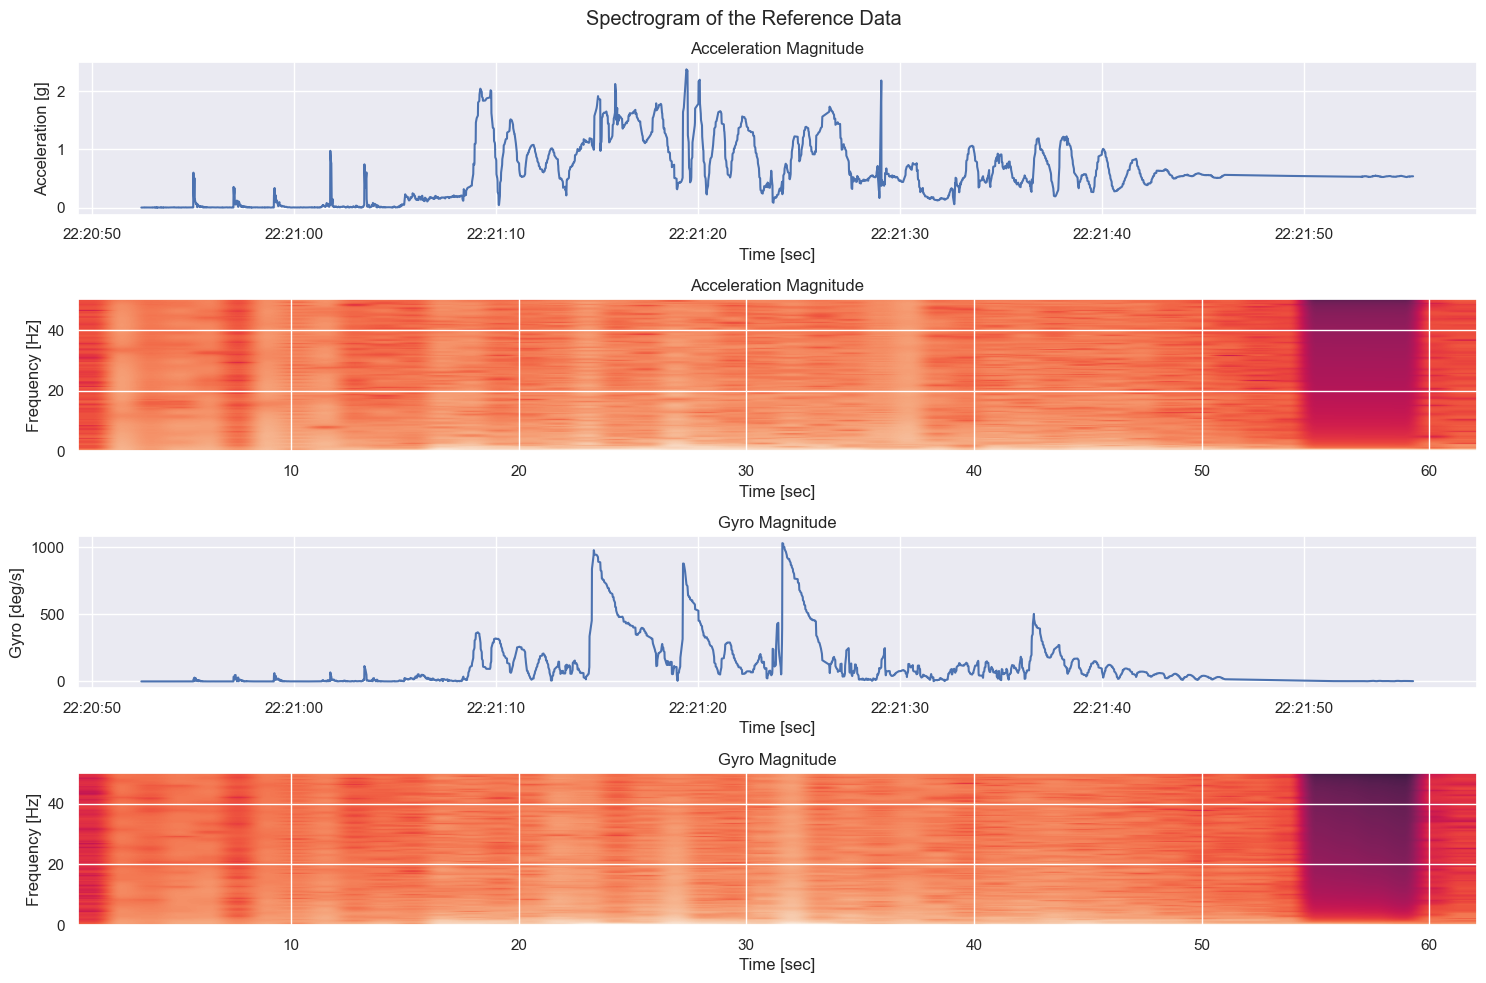

In [221]:
# calculate the spectrogram of the acceleration and gyro
fs = 1/sampling_time
f, t, Sxx_accel = spectrogram(df_ref_over['accel_mag'], fs)
f, t, Sxx_gyro = spectrogram(df_ref_over['gyro_mag'], fs)

# plot the signal, spectrogram of the acceleration and gyro in a 3x1 subplot
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Spectrogram of the Reference Data')

# plot the signal
axs[0].plot(df_ref_over['accel_mag'])
axs[0].set_ylabel('Acceleration [g]')
axs[0].set_xlabel('Time [sec]')
axs[0].set_title('Acceleration Magnitude')

# plot the spectrogram of the acceleration
# im = axs[0].pcolormesh(t, f, Sxx_accel, shading='gouraud')
im = axs[1].specgram(df_ref_over['accel_mag'], Fs=fs)
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[1].set_title('Acceleration Magnitude')
# fig.colorbar(im, ax=axs[0])

# plot the gyro
axs[2].plot(df_ref_over['gyro_mag'])
axs[2].set_ylabel('Gyro [deg/s]')
axs[2].set_xlabel('Time [sec]')
axs[2].set_title('Gyro Magnitude')

# plot the spectrogram of the gyro
# im = axs[3].pcolormesh(t, f, Sxx_gyro)
im = axs[3].specgram(df_ref_over['gyro_mag'], Fs=fs)
axs[3].set_ylabel('Frequency [Hz]')
axs[3].set_xlabel('Time [sec]')
axs[3].set_title('Gyro Magnitude')
# fig.colorbar(im, ax=axs[1])

# give more space between the subplots
fig.tight_layout(pad=1.0)
plt.show()



### Cross-correlation

In [222]:
# function to caldulate the 1d cross correlation
def crosscorrelation_1d(signal1, signal2, plot=True, title=""):
        
    # calculate the cross correlation
    corr = correlate(signal1, signal2, mode='full')
    # calculate the time lags
    lags = np.arange(1-len(signal1), len(signal2))

    # Find the lag with the maximum correlation
    max_corr_index = np.argmax(corr)
    max_corr_lag = lags[max_corr_index]

    # If max_corr_lag is positive, the second signal leads the reference signal
    if max_corr_lag > 0:
        match_sample_second = max_corr_lag
        match_sample_first = 0
    # If max_corr_lag is negative, the second signal lags the reference signal
    else:
        match_sample_second = 0
        match_sample_first = -max_corr_lag

    if plot:

        # drop _time index
        signal1 = signal1.reset_index(drop=True)
        signal2 = signal2.reset_index(drop=True)
        # Create the subplots
        fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 rows, 1 column

        # Plot the first signal
        axs[0].plot(signal1, label='First Signal', color='C0')
        axs[0].set_title('First Signal - ' + title)
        axs[0].set_xlabel('Samples')
        axs[0].set_ylabel('Magnitude')
        axs[0].grid(True)

        # Plot the second signal
        axs[1].plot(signal2, label='Second Signal - ' + title, color='C0')
        axs[1].set_title('Second Signal - ' + title)
        axs[1].set_xlabel('Samples')
        axs[1].set_ylabel('Magnitude')
        axs[1].grid(True)

        # Mark the points of maximum correlation on both signals
        axs[0].axvline(x=max_corr_index, color='r', linestyle='--', label='Maximum Correlation Lag')
        axs[1].axvline(x=match_sample_second, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Plot the cross-correlation
        axs[2].plot(lags, corr, label='Cross Correlation', color='C1')
        axs[2].set_title('Cross Correlation')
        axs[2].set_xlabel('Lag (Samples)')
        axs[2].set_ylabel('Cross Correlation')
        axs[2].grid(True)
        axs[2].axvline(x=max_corr_lag, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Add legends
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

    return corr, max_corr_lag, max_corr_index
    

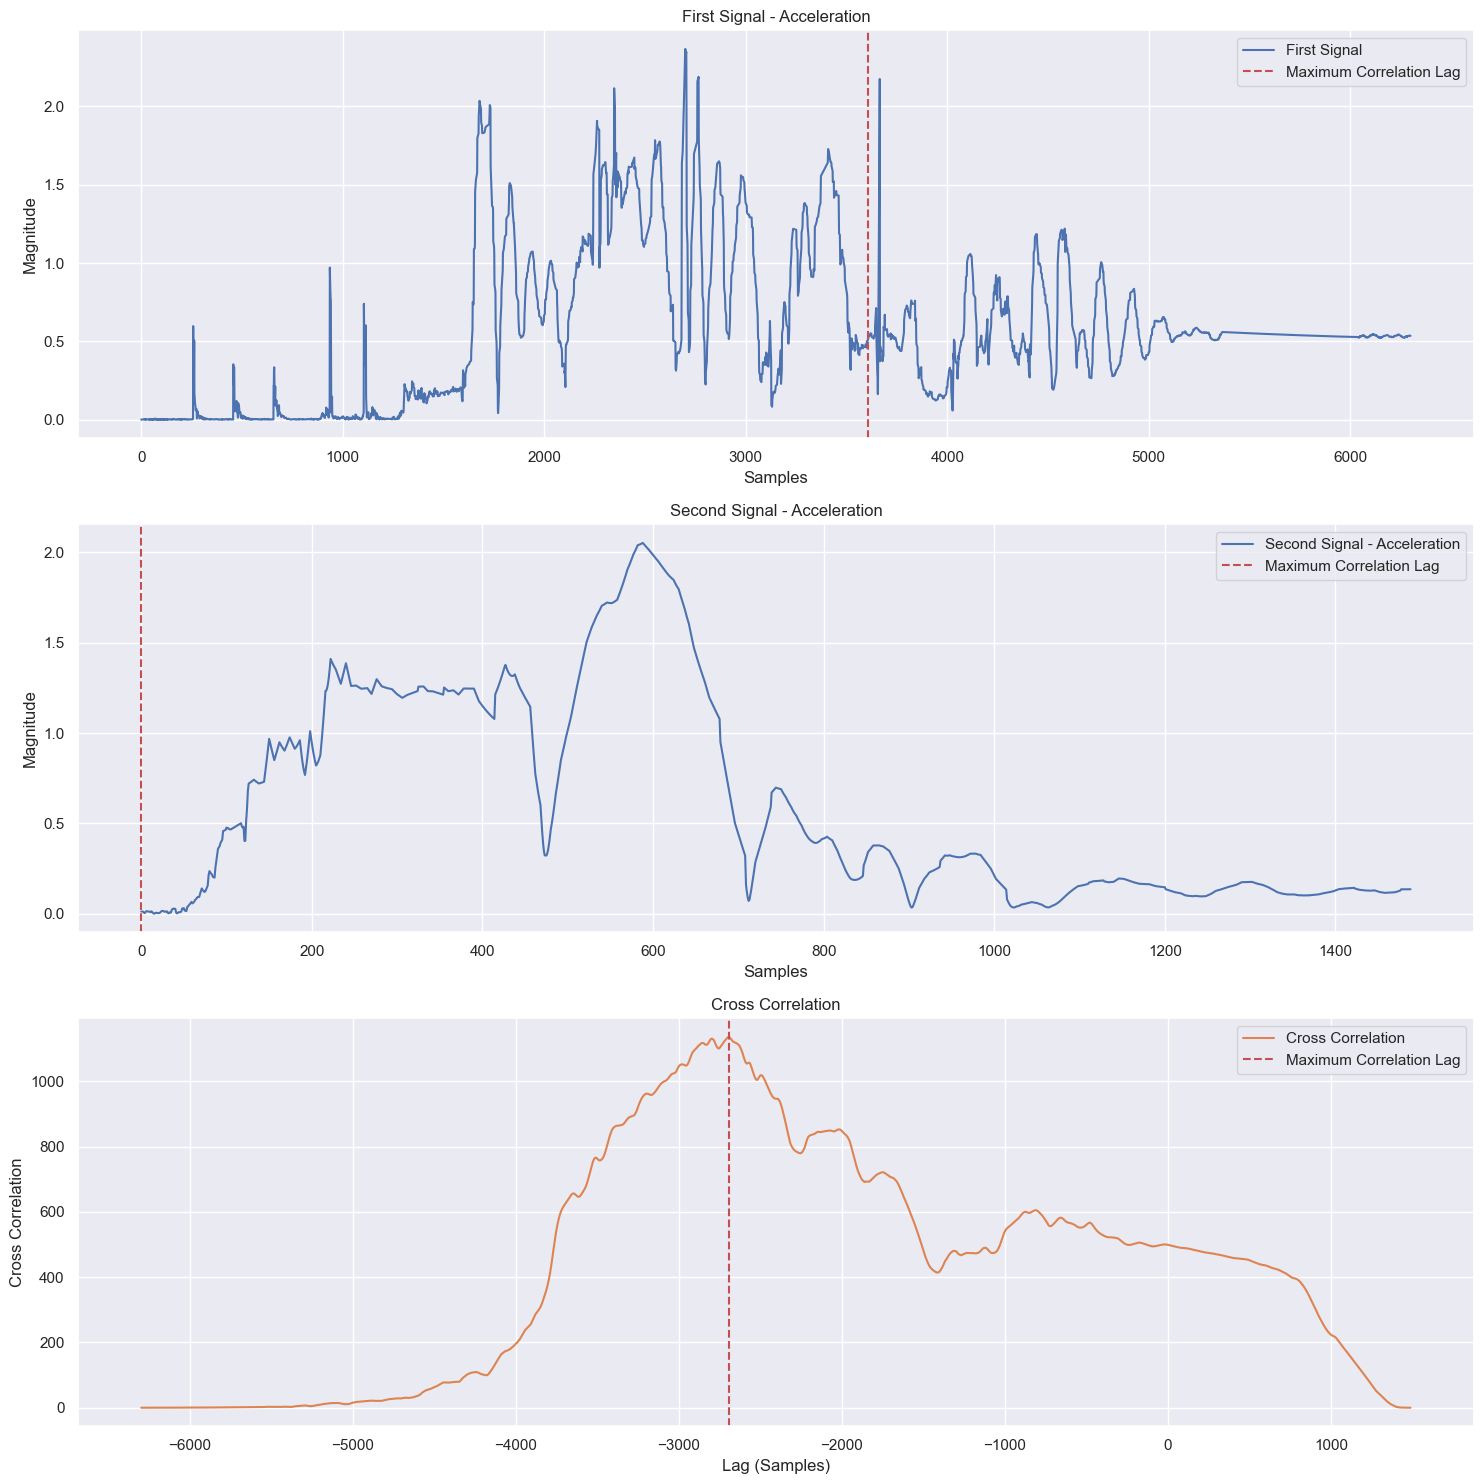

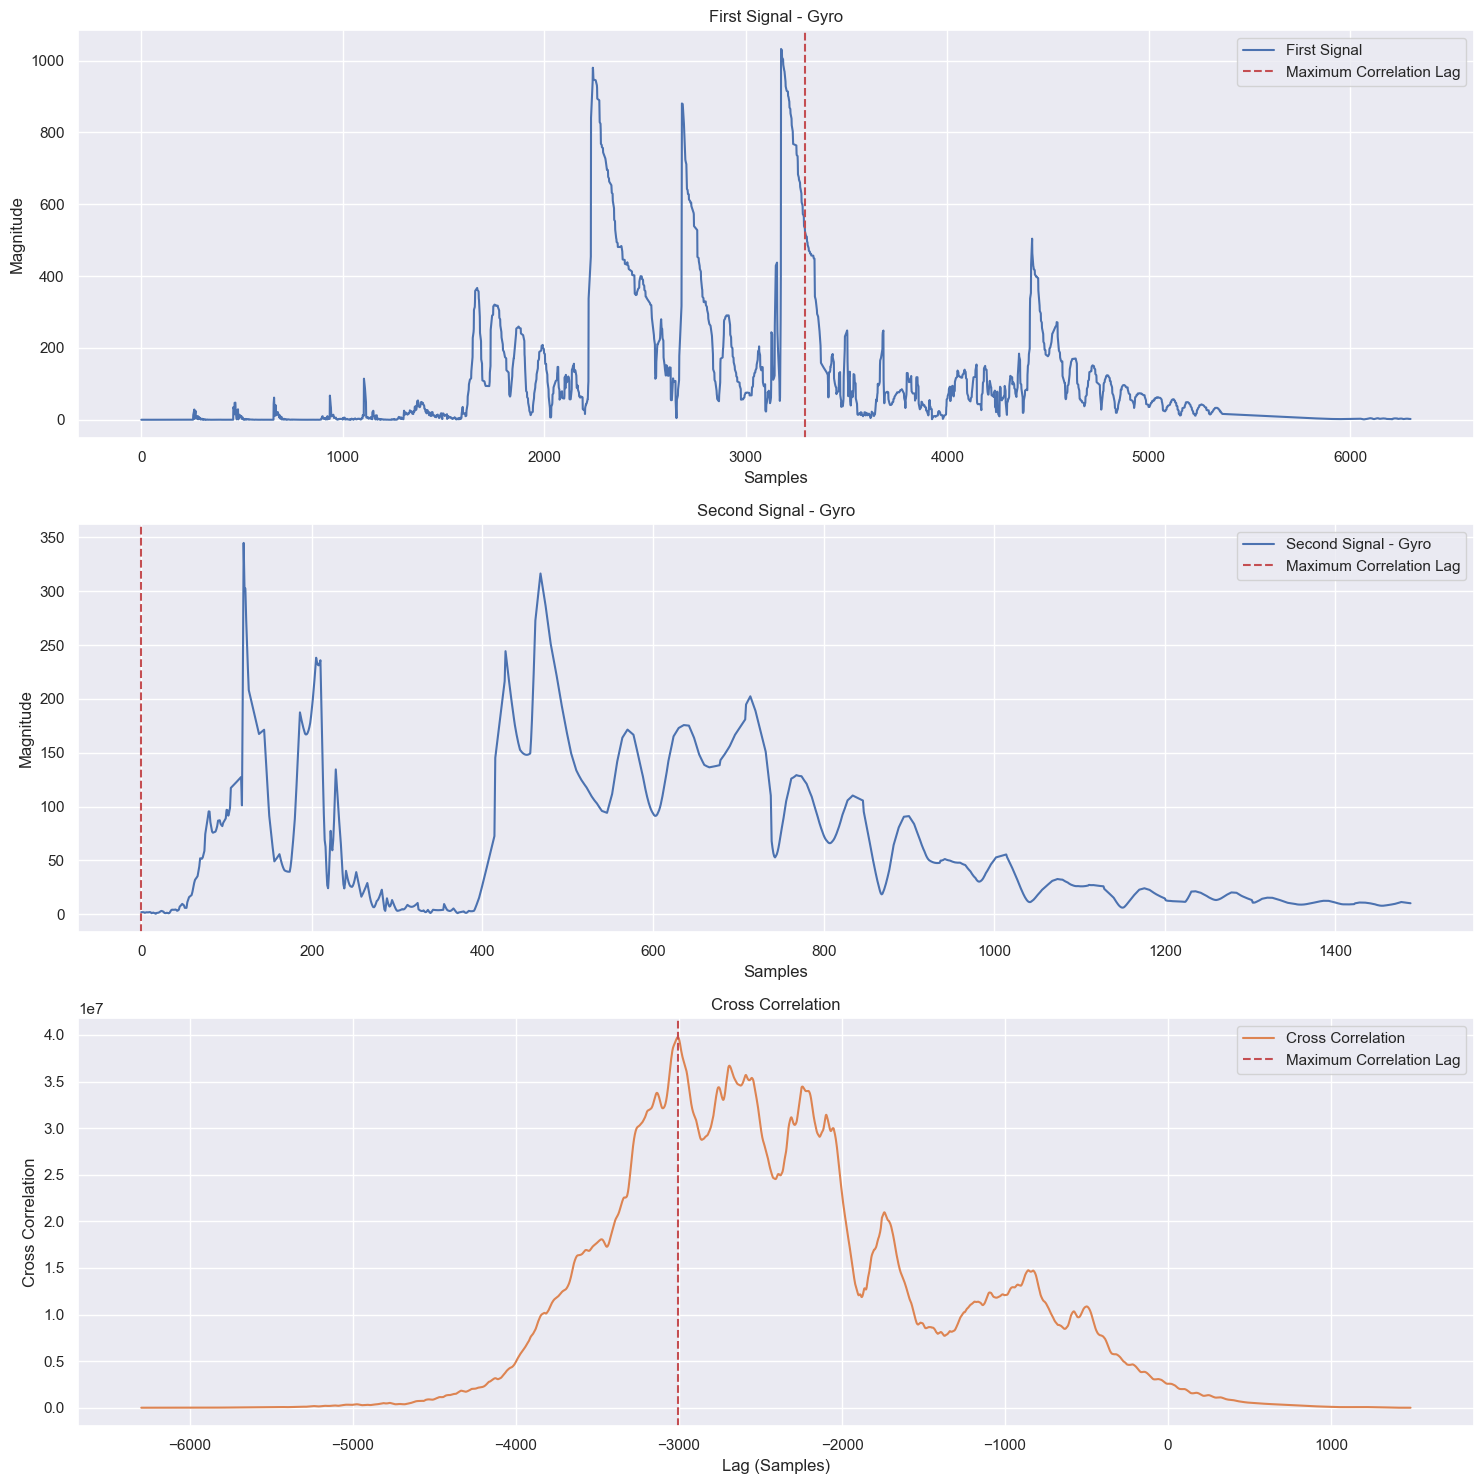

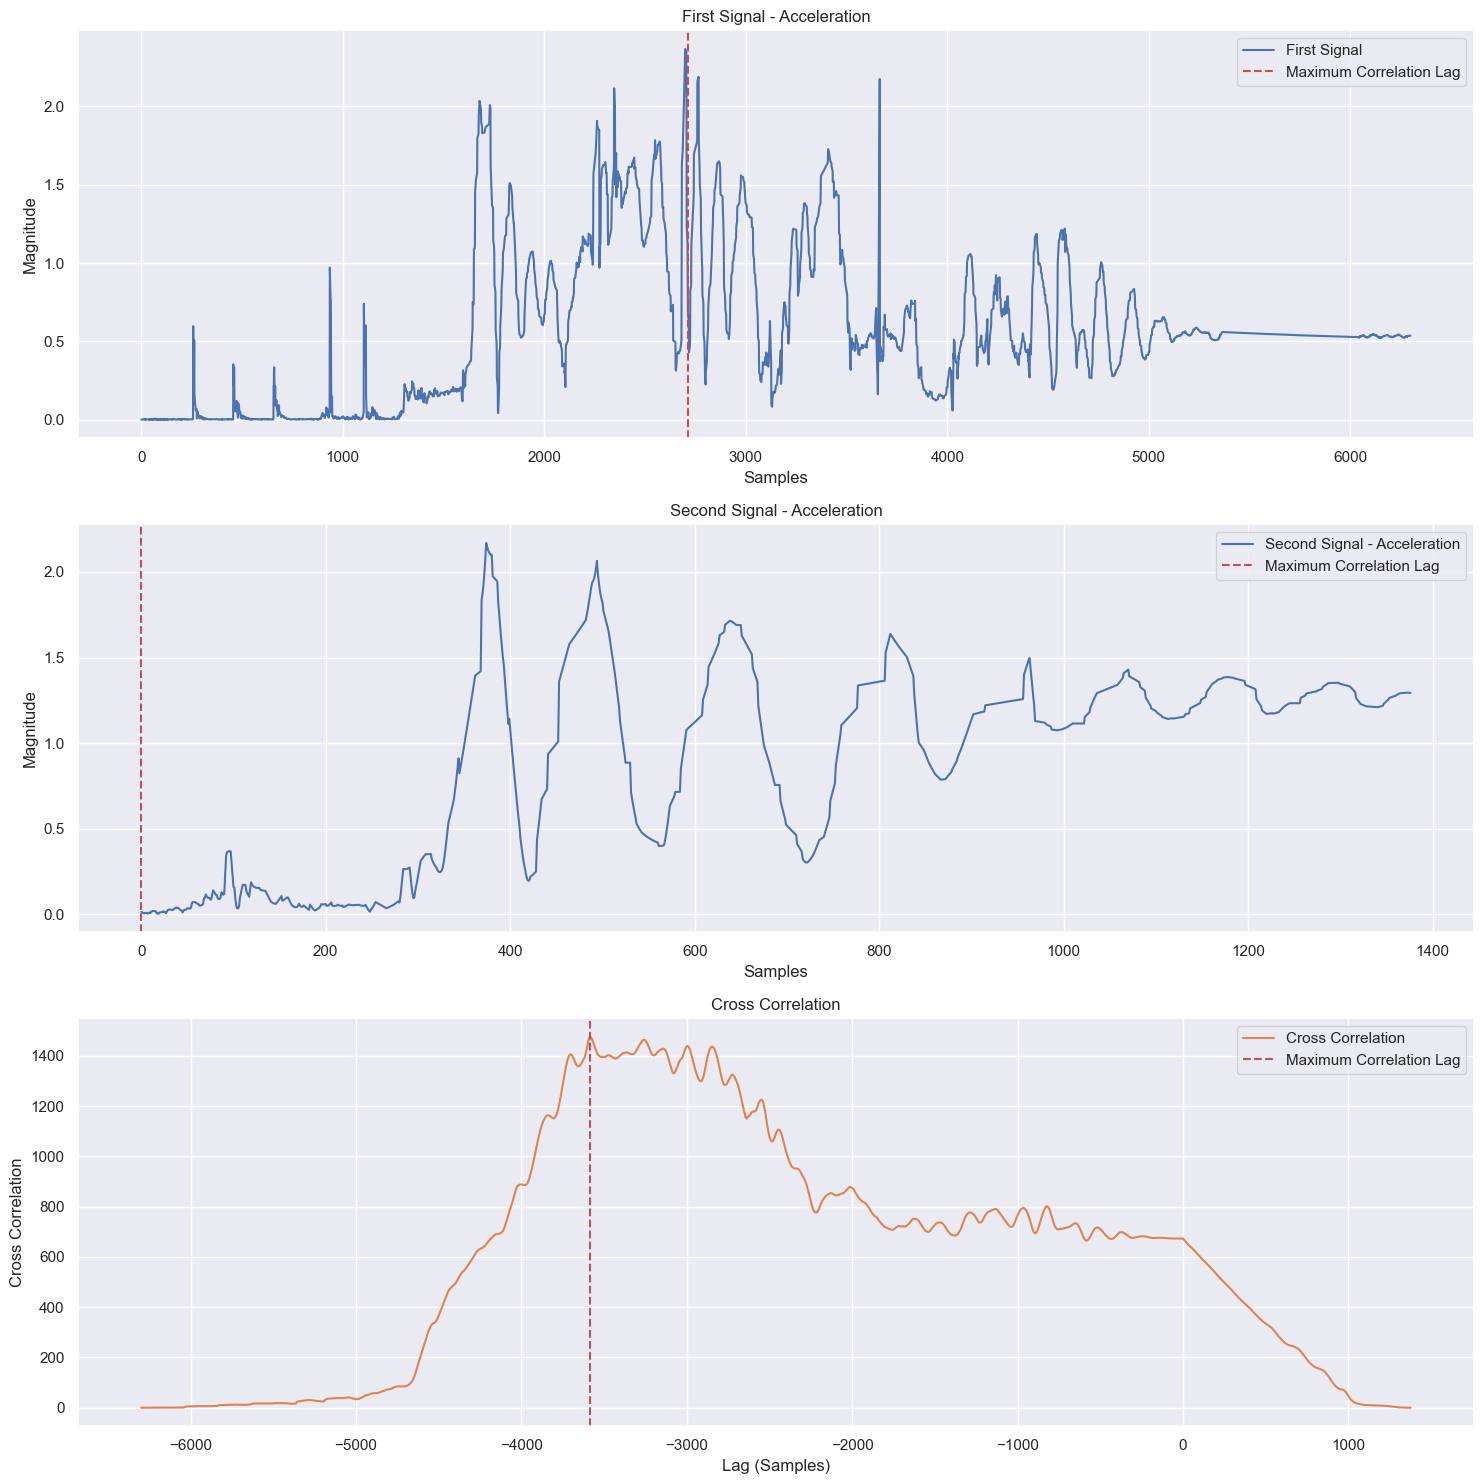

In [223]:
# x axis sequences
corr_ref_float_accel, lag_ref_floatx_accel, max_corr_ref_floatx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatinx_over['accel_mag'], plot=True, title="Acceleration")
corr_ref_float_gyro, lag_ref_floatx_gyro, max_corr_ref_floatx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatinx_over['gyro_mag'], plot=True, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammerx_accel, max_corr_ref_hammerx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammerx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammerx_gyro, max_corr_ref_hammerx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammerx_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impactx_accel, max_corr_ref_impactx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impactx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impactx_gyro, max_corr_ref_impactx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impactx_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationx_accel, max_corr_ref_rotationx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationx_gyro, max_corr_ref_rotationx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationx_over['gyro_mag'], plot=False, title="Gyro")

# y axis sequences
corr_ref_float_accel, lag_ref_floaty_accel, max_corr_ref_floaty_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatiny_over['accel_mag'], plot=True, title="Acceleration")
corr_ref_float_gyro, lag_ref_floaty_gyro, max_corr_ref_floaty_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatiny_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammery_accel, max_corr_ref_hammery_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammery_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammery_gyro, max_corr_ref_hammery_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammery_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impacty_accel, max_corr_ref_impacty_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impacty_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impacty_gyro, max_corr_ref_impacty_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impacty_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationy_accel, max_corr_ref_rotationy_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationy_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationy_gyro, max_corr_ref_rotationy_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationy_over['gyro_mag'], plot=False, title="Gyro")

# z axis sequences
corr_ref_float_accel, lag_ref_floatz_accel, max_corr_ref_floatz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatinz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_float_gyro, lag_ref_floatz_gyro, max_corr_ref_floatz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatinz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammerz_accel, max_corr_ref_hammerz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammerz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammerz_gyro, max_corr_ref_hammerz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammerz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impactz_accel, max_corr_ref_impactz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impactz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impactz_gyro, max_corr_ref_impactz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impactz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationz_accel, max_corr_ref_rotationz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationz_gyro, max_corr_ref_rotationz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationz_over['gyro_mag'], plot=False, title="Gyro")


In [224]:
max_corr_indices_accel = [
    max_corr_ref_floatx_accel, max_corr_ref_floaty_accel, max_corr_ref_floatz_accel,
    max_corr_ref_hammerx_accel, max_corr_ref_hammery_accel, max_corr_ref_hammerz_accel,
    max_corr_ref_impactx_accel, max_corr_ref_impacty_accel, max_corr_ref_impactz_accel,
    max_corr_ref_rotationx_accel, max_corr_ref_rotationy_accel, max_corr_ref_rotationz_accel
]

max_corr_indices_gyro = [
    max_corr_ref_floatx_gyro, max_corr_ref_floaty_gyro, max_corr_ref_floatz_gyro,
    max_corr_ref_hammerx_gyro, max_corr_ref_hammery_gyro, max_corr_ref_hammerz_gyro,
    max_corr_ref_impactx_gyro, max_corr_ref_impacty_gyro, max_corr_ref_impactz_gyro,
    max_corr_ref_rotationx_gyro, max_corr_ref_rotationy_gyro, max_corr_ref_rotationz_gyro
]

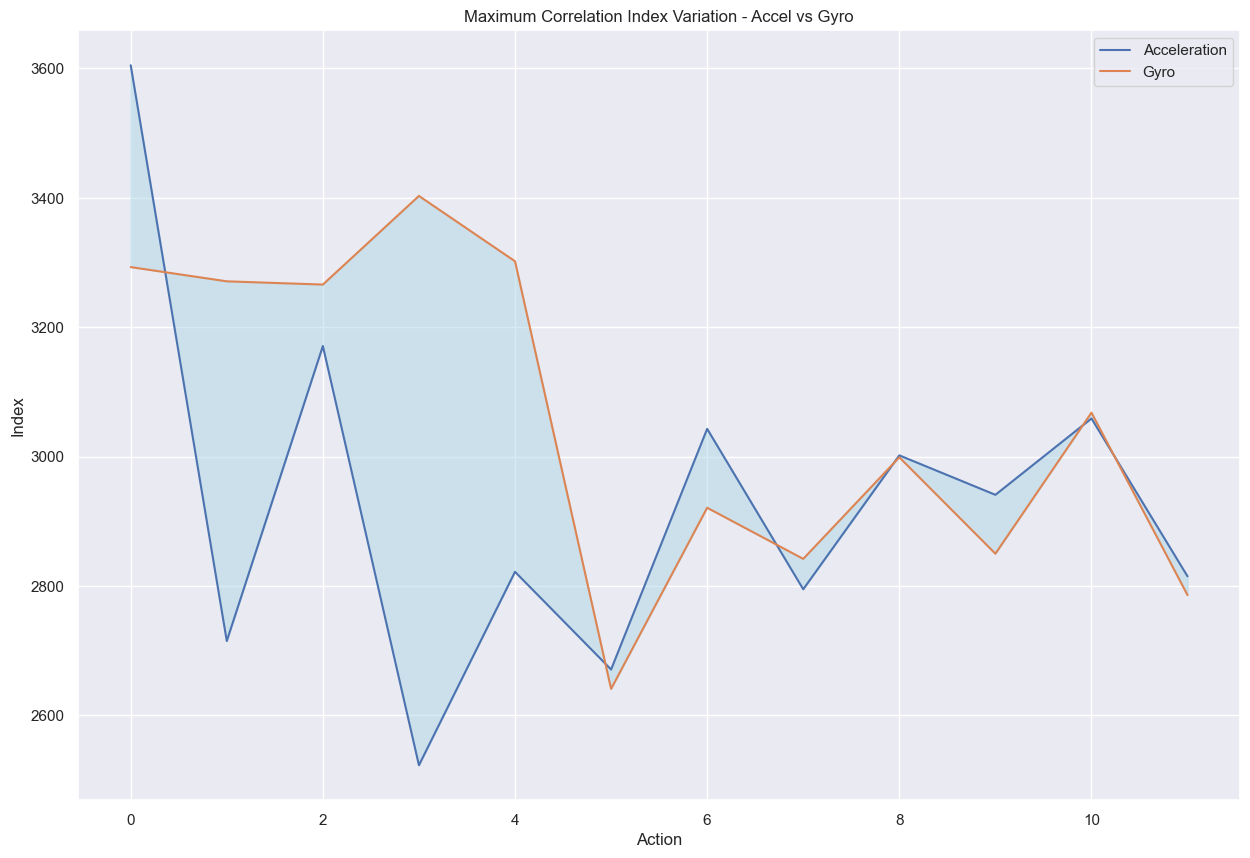

In [225]:
# plot the variation of the maximum correlation index for acceleration and gyro
plt.figure(figsize=(15, 10))
plt.plot(max_corr_indices_accel, label='Acceleration')
plt.plot(max_corr_indices_gyro, label='Gyro')
plt.fill_between(range(len(max_corr_indices_accel)), max_corr_indices_accel, max_corr_indices_gyro, color='lightblue', alpha=0.5)
plt.title('Maximum Correlation Index Variation - Accel vs Gyro')
plt.xlabel('Action')
plt.ylabel('Index')
plt.legend()
plt.grid(True)
plt.show()


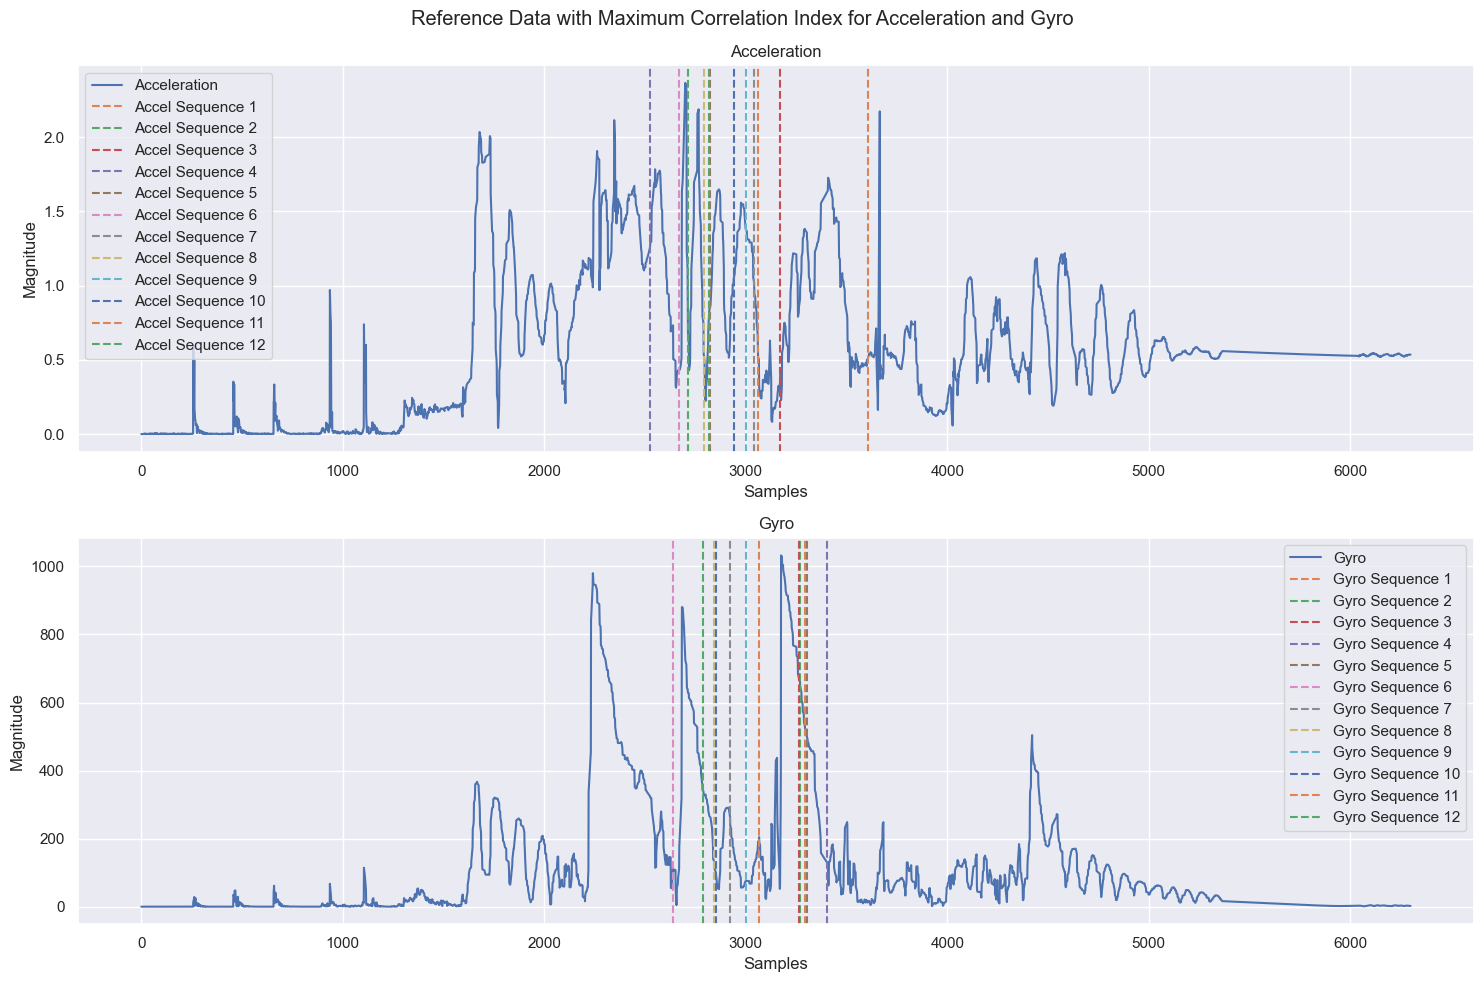

In [226]:
# plot the reference data with the maximum correlation index for acceleration and gyro for all the actions
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Reference Data with Maximum Correlation Index for Acceleration and Gyro')

signal = df_ref_over.copy()
signal = signal.reset_index(drop=True)

# plot the reference data with the maximum correlation index for acceleration
axs[0].plot(signal['accel_mag'], label='Acceleration')
axs[0].set_title('Acceleration')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)
for i in range(0, len(max_corr_indices_accel)):
    axs[0].axvline(x=max_corr_indices_accel[i], color=f'C{i+1}', linestyle='--', label=f'Accel Sequence {i+1}')

# plot the reference data with the maximum correlation index for gyro
axs[1].plot(signal['gyro_mag'], label='Gyro')
axs[1].set_title('Gyro')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Magnitude')

axs[1].grid(True)
for i in range(0, len(max_corr_indices_gyro)):
    axs[1].axvline(x=max_corr_indices_gyro[i], color=f'C{i+1}', linestyle='--', label=f'Gyro Sequence {i+1}')
# Add legends
axs[0].legend()
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

### FFT

##### Functions

In [227]:
def get_fft_peaks(df, sampling_time, title="", plot=False, window=0, shift=0):
    """Get the fft peaks of the dataframe

    Args:
        df (): pandas dataframe
        sampling_time (float): sampling time
        title (str, optional): title of the plot. Defaults to "".
        plot (bool, optional): plot the fft. Defaults to False.
        window (int, optional): number of samples to split the dataframe and calculate the fft on each window. Defaults to 0.
        shift (int, optional): number of samples to shift the window and recalculate the fft. Defaults to 0.

    Returns:
        data_struct: struct with fft values, frequency and peaks
    """
    
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    num_peaks = 5
    order_peaks = 8
    
    df_window = []
    index_window_pairs = []  # Initialize a list to store index-window pairs

    if window > 0:
        # get a new index before resampling
        df = df.reset_index(drop=True)

        # split the dataframe in windows of size window, every new window is shifted by shift from the last sample of the previous window
        for i in range(0, len(df), shift):
            # if the size of the window is less than window, add 0 paddings
            if i+window > len(df):
                diff = i+window - len(df)
                padded_window = df[i:].copy()
                padded_window = padded_window.reindex(range(diff), fill_value=0.0)
                # start the index from the last sample of the previous window
                last_index = df[i:].index[-1]
                padded_window.index = range(last_index+1, last_index+1+diff)
                # add the padded window to the list
                padded_window = pd.concat([df[i:], padded_window])
                
                # add the window to the list
                df_window.append(padded_window)
            else:
                # add the window to the list
                df_window.append(df[i:i+window])
            
            window_end = min(i + window, len(df))
            current_window = df[i:window_end]

            # Generate index-window pairs for the current window
            for idx in current_window.index:
                index_window_pairs.append([idx, i // shift])  # Divide by shift to get sequential window numbers
    else:
        df_window.append(df)
        for idx in df.index:
            index_window_pairs.append([idx, 0])  # If no windowing, all samples belong to window 0

    # Initialize a dictionary to aggregate window IDs by index
    index_to_windows = {}

    # Aggregate window IDs for each index
    for idx, window_id in index_window_pairs:
        if idx not in index_to_windows:
            index_to_windows[idx] = set()
        index_to_windows[idx].add(window_id)

    # Convert the dictionary to the desired list format
    index_windows_list = [list(window_ids) for idx, window_ids in index_to_windows.items()]
    
    # print("Number of windows: ", len(df_window))
    # print(df_window)     

    # create struct to return
    data_struct = {}

    for i in range(len(df_window)):
        # add a new key to the struct
        data_struct[i] = {}

    if plot:
        fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
        fig.suptitle("FFT with peaks " + title)
    
    for i, df in enumerate(df_window):
        # print("Window: ", i)
        # print(df)
        # variable to store the accel and gyro peak values
        accel_peak_values = []
        gyro_peak_values = []
        # variable to store the accel and gyro peak frequencies
        accel_peak_freq = []
        gyro_peak_freq = []

        for j, column in enumerate(columns):
            # get the fft
            fft_values = fft(df[column].values)
            # get the frequency
            freq = fftfreq(len(df[column].values), d=sampling_time)
            # get the peaks
            peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            while len(peaks) < num_peaks and order_peaks > 1:
                # reduce the order
                order_peaks = order_peaks - 1
                # get the peaks
                peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            
            # take the top 5 peaks which are greater than 0
            peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
            # sort the peaks
            peaks.sort()
            # update the struct
            data_struct[i][column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

            # add the peaks to the list
            if 'accel' in column:
                accel_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                accel_peak_freq.append(freq[peaks])
            else:
                gyro_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                gyro_peak_freq.append(freq[peaks])

            if plot:
                # plot the fft
                axs[j//3, j%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(j%3), label=column)
                # plot the peaks
                axs[j//3, j%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
                if window == 0:
                    axs[j//3, j%3].legend()

                # set the y label
                if 'accel' in column:
                    axs[j//3, j%3].set_ylabel('g')
                else:
                    axs[j//3, j%3].set_ylabel('deg/s')
        
        # concatenate the peaks
        accel_peak_values = np.concatenate(accel_peak_values)
        gyro_peak_values = np.concatenate(gyro_peak_values)
        accel_peak_freq = np.concatenate(accel_peak_freq)
        gyro_peak_freq = np.concatenate(gyro_peak_freq)
        # check if there are duplicated frequencies and remove them together with the values
        accel_peak_freq, index = np.unique(accel_peak_freq, return_index=True)
        accel_peak_values = accel_peak_values[index]
        gyro_peak_freq, index = np.unique(gyro_peak_freq, return_index=True)
        gyro_peak_values = gyro_peak_values[index]
        # sort the peaks
        accel_peak_values = accel_peak_values[np.argsort(accel_peak_freq)]
        gyro_peak_values = gyro_peak_values[np.argsort(gyro_peak_freq)]
        accel_peak_freq = accel_peak_freq[np.argsort(accel_peak_freq)]
        gyro_peak_freq = gyro_peak_freq[np.argsort(gyro_peak_freq)]

        # add the peaks to the struct
        data_struct[i]['accel_peaks'] = accel_peak_values
        data_struct[i]['accel_peaks_freq'] = accel_peak_freq
        data_struct[i]['gyro_peaks'] = gyro_peak_values
        data_struct[i]['gyro_peaks_freq'] = gyro_peak_freq

    if window > 0:
        return data_struct, index_windows_list
    else:
        return data_struct

In [228]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [229]:
def plot_peaks_combined(sensor_struct, title=""):

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    axs[0].stem(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', color='C0', alpha=0.5)
    axs[1].stem(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [230]:
# zip peaks and frequencies
def zip_peaks_freq(freq, peaks):
    return np.array(list(zip(freq, peaks)))

##### Code

In [231]:
df_ref_over

accel_x   accel_y   accel_z    gyro_x    gyro_y  \
_time                                                                       
2024-01-14 22:20:52.420 -0.000098  0.000391  0.001050  0.042683 -0.036585   
2024-01-14 22:20:52.430  0.000065  0.000228  0.000724  0.052846 -0.026423   
2024-01-14 22:20:52.440  0.000228  0.000065  0.000399  0.063008 -0.016260   
2024-01-14 22:20:52.450  0.000391 -0.000098  0.000073  0.073171 -0.006098   
2024-01-14 22:20:52.460  0.000553 -0.000260 -0.000252  0.083333  0.004065   
...                           ...       ...       ...       ...       ...   
2024-01-14 22:21:55.370 -0.003271 -0.324512  0.427466  0.042683 -0.414634   
2024-01-14 22:21:55.380 -0.002783 -0.324219  0.427368  0.103659 -0.365854   
2024-01-14 22:21:55.390 -0.002295 -0.323926  0.427271  0.164634 -0.317073   
2024-01-14 22:21:55.400 -0.001807 -0.323633  0.427173  0.225610 -0.268293   
2024-01-14 22:21:55.410 -0.001318 -0.323340  0.427075  0.286585 -0.219512   

                           gyro_z  quat_x  quat_y  quat_z  quat_w  accel_mag  \
_time                                                                          
2024-01-14 22:20:52.420  0.012195    0.41   -0.38   -0.62    0.55   0.001124   
2024-01-14 22:20:52.430  0.022358    0.41   -0.38   -0.62    0.55   0.000762   
2024-01-14 22:20:52.440  0.032520    0.41   -0.38   -0.62    0.55   0.000464   
2024-01-14 22:20:52.450  0.042683    0.41   -0.38   -0.62    0.55   0.000409   
2024-01-14 22:20:52.460  0.052846    0.41   -0.38   -0.62    0.55   0.000662   
...                           ...     ...     ...     ...     ...        ...   
2024-01-14 22:21:55.370  2.207317    0.31   -0.03   -0.22    0.92   0.536699   
2024-01-14 22:21:55.380  2.207317    0.31   -0.03   -0.22    0.92   0.536441   
2024-01-14 22:21:55.390  2.207317    0.31   -0.03   -0.22    0.92   0.536184   
2024-01-14 22:21:55.400  2.207317    0.31   -0.03   -0.22    0.92   0.535927   
2024-01-14 22:21:55.410  2.207317    0.31   -0.03   -0.22    0.92   0.535671   

                         gyro_mag  
_time                              
2024-01-14 22:20:52.420  0.057524  
2024-01-14 22:20:52.430  0.063172  
2024-01-14 22:20:52.440  0.072746  
2024-01-14 22:20:52.450  0.084929  
2024-01-14 22:20:52.460  0.098760  
...                           ...  
2024-01-14 22:21:55.370  2.246329  
2024-01-14 22:21:55.380  2.239831  
2024-01-14 22:21:55.390  2.236043  
2024-01-14 22:21:55.400  2.234979  
2024-01-14 22:21:55.410  2.236642  

[6300 rows x 12 columns]

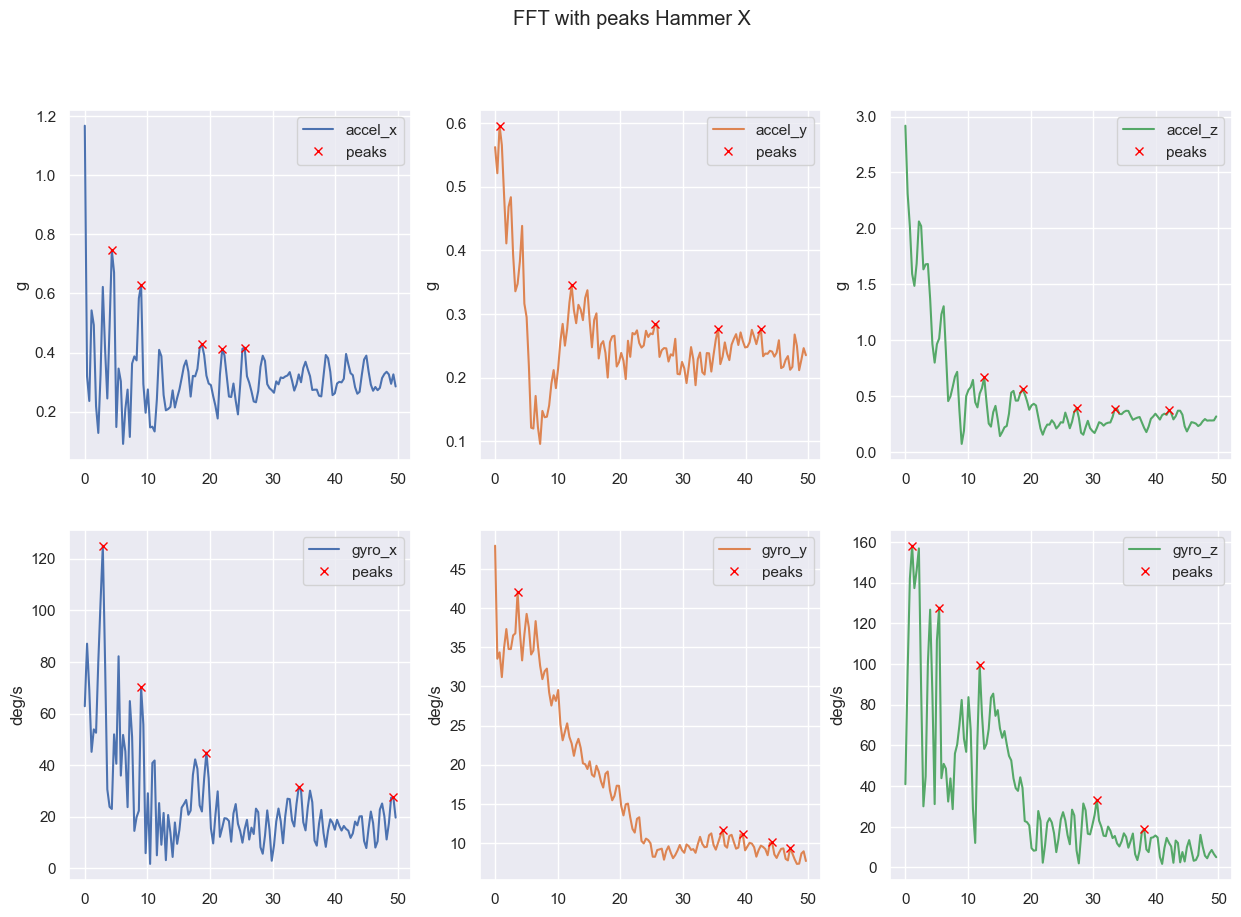

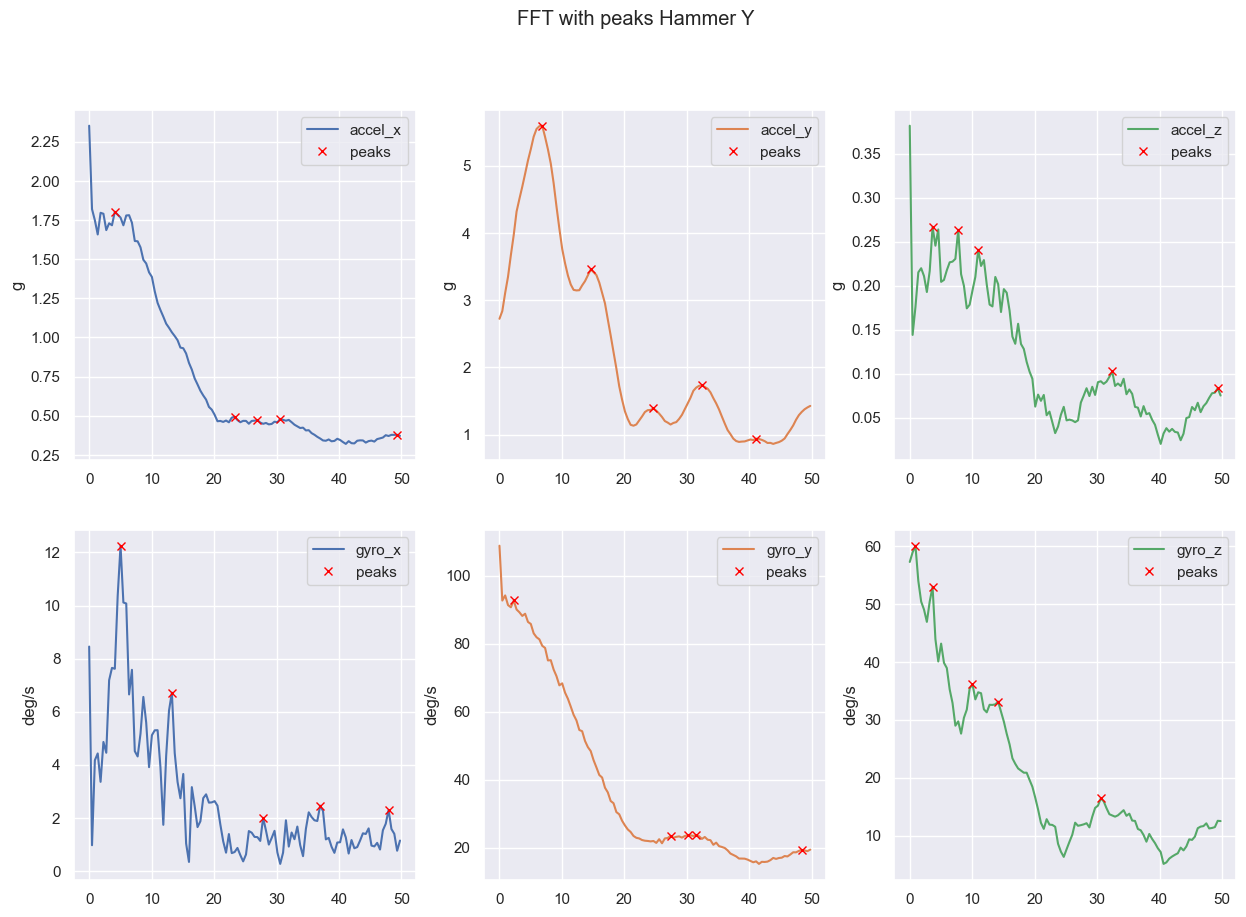

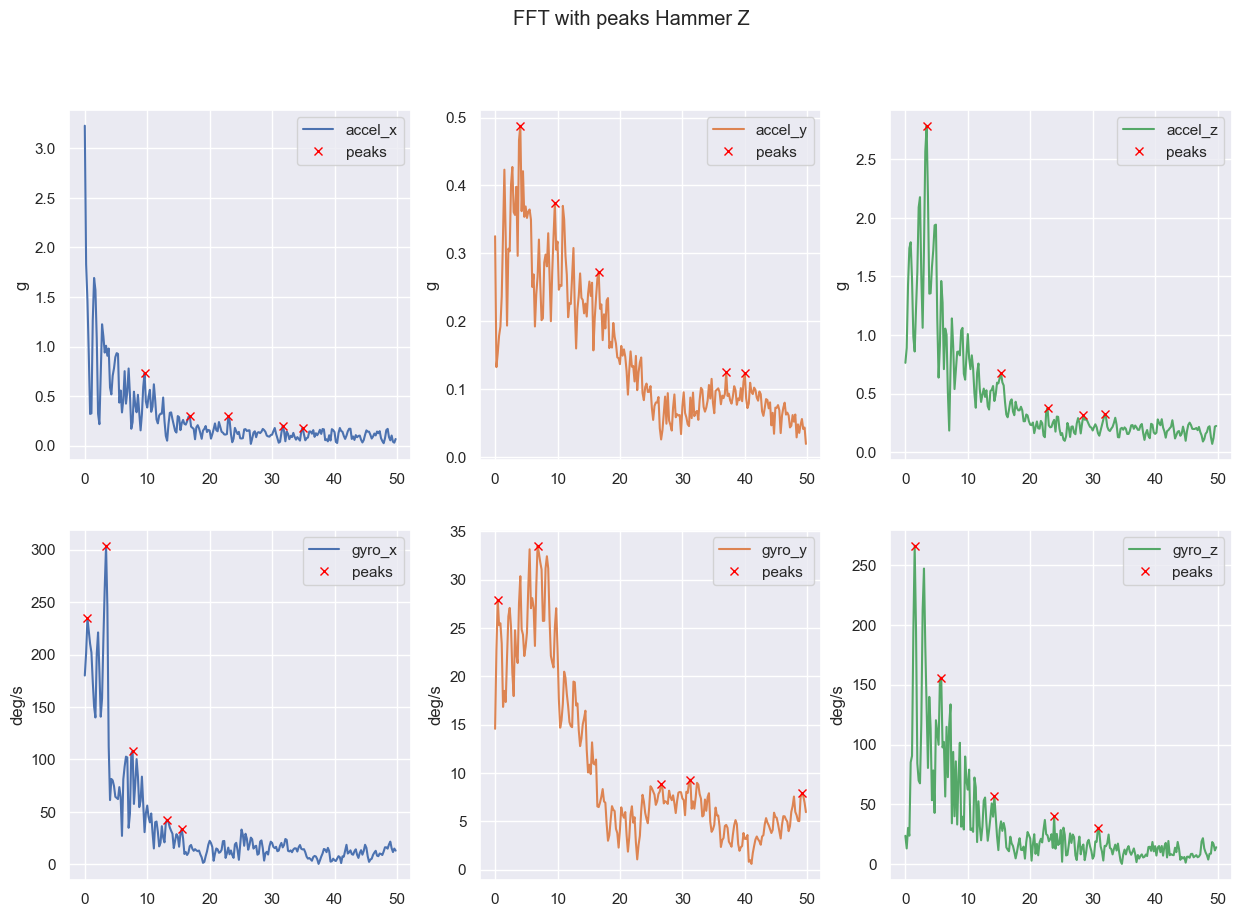

In [232]:
ref_fft, window_ids_list = get_fft_peaks(df_ref_over, sampling_time, title="Reference", plot=False, window=min_window_length, shift=50)
floatingx_fft = get_fft_peaks(df_floatinx_over, sampling_time, title="Floating X", plot=False)
floatingy_fft = get_fft_peaks(df_floatiny_over, sampling_time, title="Floating Y", plot=False)
floatingz_fft = get_fft_peaks(df_floatinz_over, sampling_time, title="Floating Z", plot=False)
hammerx_fft = get_fft_peaks(df_hammerx_over, sampling_time, title="Hammer X", plot=True)
hammery_fft = get_fft_peaks(df_hammery_over, sampling_time, title="Hammer Y", plot=True)
hammerz_fft = get_fft_peaks(df_hammerz_over, sampling_time, title="Hammer Z", plot=True)
impactx_fft = get_fft_peaks(df_impactx_over, sampling_time, title="Impact X", plot=False)
impacty_fft = get_fft_peaks(df_impacty_over, sampling_time, title="Impact Y", plot=False)
impactz_fft = get_fft_peaks(df_impactz_over, sampling_time, title="Impact Z", plot=False)
rotationx_fft = get_fft_peaks(df_rotationx_over, sampling_time, title="Rotation X", plot=False)
rotationy_fft = get_fft_peaks(df_rotationy_over, sampling_time, title="Rotation Y", plot=False)
rotationz_fft = get_fft_peaks(df_rotationz_over, sampling_time, title="Rotation Z", plot=False)

In [233]:
# append the window ids to the reference dataframe
df_ref_over['window_id'] = window_ids_list

In [234]:
df_ref_over

accel_x   accel_y   accel_z    gyro_x    gyro_y  \
_time                                                                       
2024-01-14 22:20:52.420 -0.000098  0.000391  0.001050  0.042683 -0.036585   
2024-01-14 22:20:52.430  0.000065  0.000228  0.000724  0.052846 -0.026423   
2024-01-14 22:20:52.440  0.000228  0.000065  0.000399  0.063008 -0.016260   
2024-01-14 22:20:52.450  0.000391 -0.000098  0.000073  0.073171 -0.006098   
2024-01-14 22:20:52.460  0.000553 -0.000260 -0.000252  0.083333  0.004065   
...                           ...       ...       ...       ...       ...   
2024-01-14 22:21:55.370 -0.003271 -0.324512  0.427466  0.042683 -0.414634   
2024-01-14 22:21:55.380 -0.002783 -0.324219  0.427368  0.103659 -0.365854   
2024-01-14 22:21:55.390 -0.002295 -0.323926  0.427271  0.164634 -0.317073   
2024-01-14 22:21:55.400 -0.001807 -0.323633  0.427173  0.225610 -0.268293   
2024-01-14 22:21:55.410 -0.001318 -0.323340  0.427075  0.286585 -0.219512   

                           gyro_z  quat_x  quat_y  quat_z  quat_w  accel_mag  \
_time                                                                          
2024-01-14 22:20:52.420  0.012195    0.41   -0.38   -0.62    0.55   0.001124   
2024-01-14 22:20:52.430  0.022358    0.41   -0.38   -0.62    0.55   0.000762   
2024-01-14 22:20:52.440  0.032520    0.41   -0.38   -0.62    0.55   0.000464   
2024-01-14 22:20:52.450  0.042683    0.41   -0.38   -0.62    0.55   0.000409   
2024-01-14 22:20:52.460  0.052846    0.41   -0.38   -0.62    0.55   0.000662   
...                           ...     ...     ...     ...     ...        ...   
2024-01-14 22:21:55.370  2.207317    0.31   -0.03   -0.22    0.92   0.536699   
2024-01-14 22:21:55.380  2.207317    0.31   -0.03   -0.22    0.92   0.536441   
2024-01-14 22:21:55.390  2.207317    0.31   -0.03   -0.22    0.92   0.536184   
2024-01-14 22:21:55.400  2.207317    0.31   -0.03   -0.22    0.92   0.535927   
2024-01-14 22:21:55.410  2.207317    0.31   -0.03   -0.22    0.92   0.535671   

                         gyro_mag             window_id  
_time                                                    
2024-01-14 22:20:52.420  0.057524                   [0]  
2024-01-14 22:20:52.430  0.063172                   [0]  
2024-01-14 22:20:52.440  0.072746                   [0]  
2024-01-14 22:20:52.450  0.084929                   [0]  
2024-01-14 22:20:52.460  0.098760                   [0]  
...                           ...                   ...  
2024-01-14 22:21:55.370  2.246329  [122, 123, 124, 125]  
2024-01-14 22:21:55.380  2.239831  [122, 123, 124, 125]  
2024-01-14 22:21:55.390  2.236043  [122, 123, 124, 125]  
2024-01-14 22:21:55.400  2.234979  [122, 123, 124, 125]  
2024-01-14 22:21:55.410  2.236642  [122, 123, 124, 125]  

[6300 rows x 13 columns]

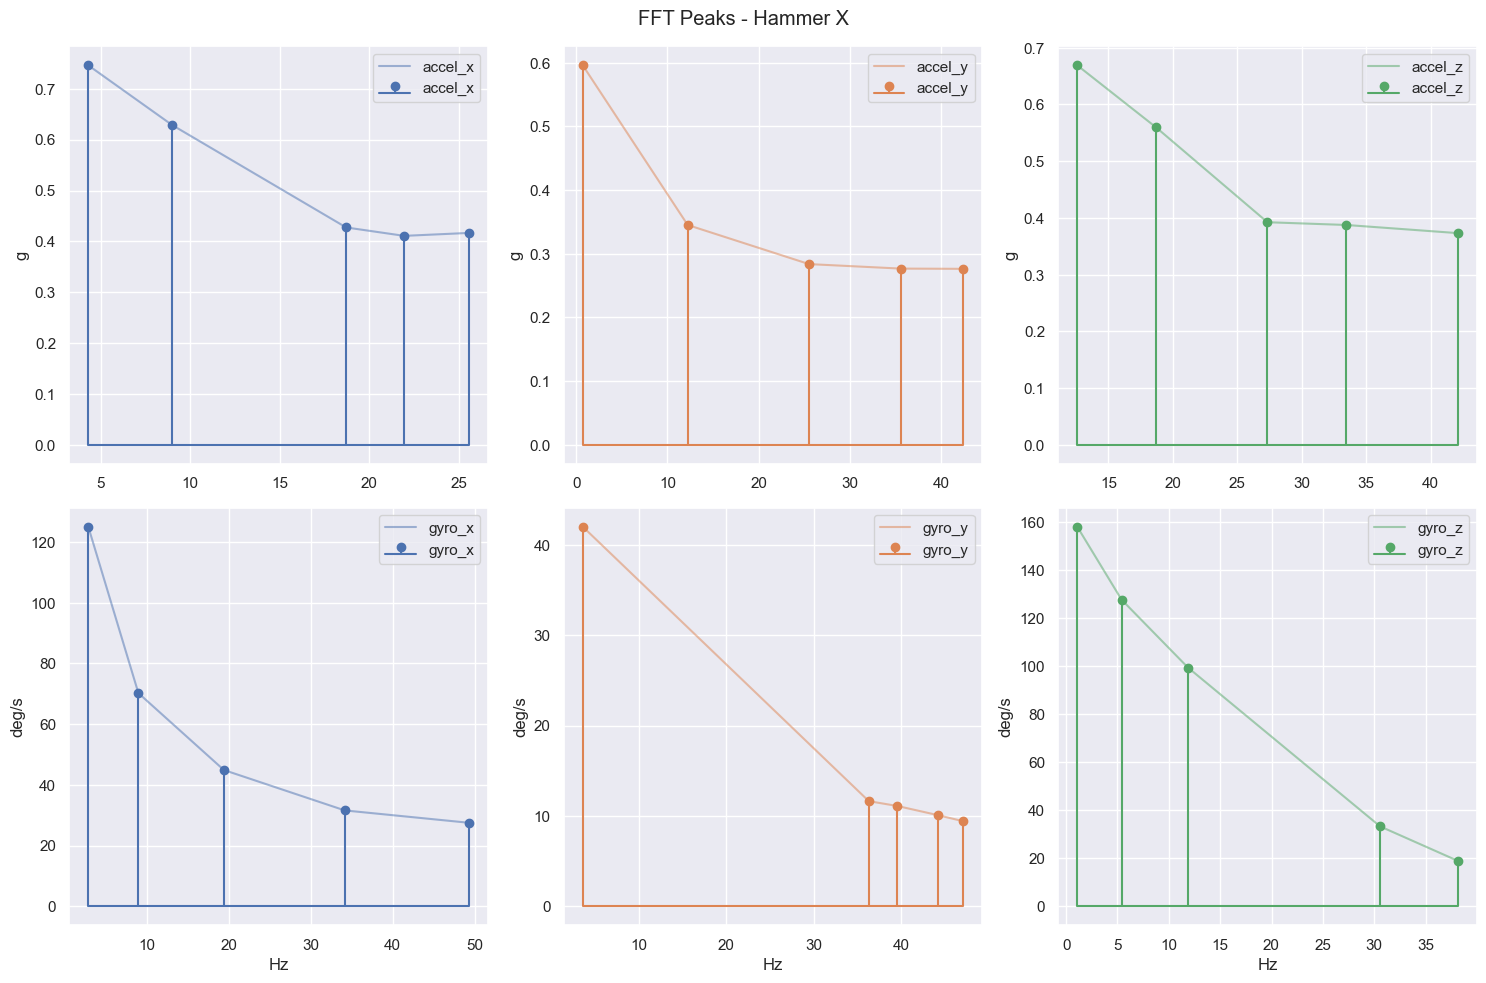

In [235]:
# plot_stem_peaks(ref_fft[100], title="Reference")
# plot_stem_peaks(floatingx_fft, title="Floating X")
# plot_stem_peaks(floatingy_fft, title="Floating Y")
# plot_stem_peaks(floatingz_fft, title="Floating Z")
plot_stem_peaks(hammerx_fft[0], title="Hammer X")
# plot_stem_peaks(hammery_fft[0], title="Hammer Y")
# plot_stem_peaks(hammerz_fft[0], title="Hammer Z")
# plot_stem_peaks(impactx_fft, title="Impact X")
# plot_stem_peaks(impacty_fft, title="Impact Y")
# plot_stem_peaks(impactz_fft, title="Impact Z")
# plot_stem_peaks(rotationx_fft, title="Rotation X")
# plot_stem_peaks(rotationy_fft, title="Rotation Y")
# plot_stem_peaks(rotationz_fft, title="Rotation Z")

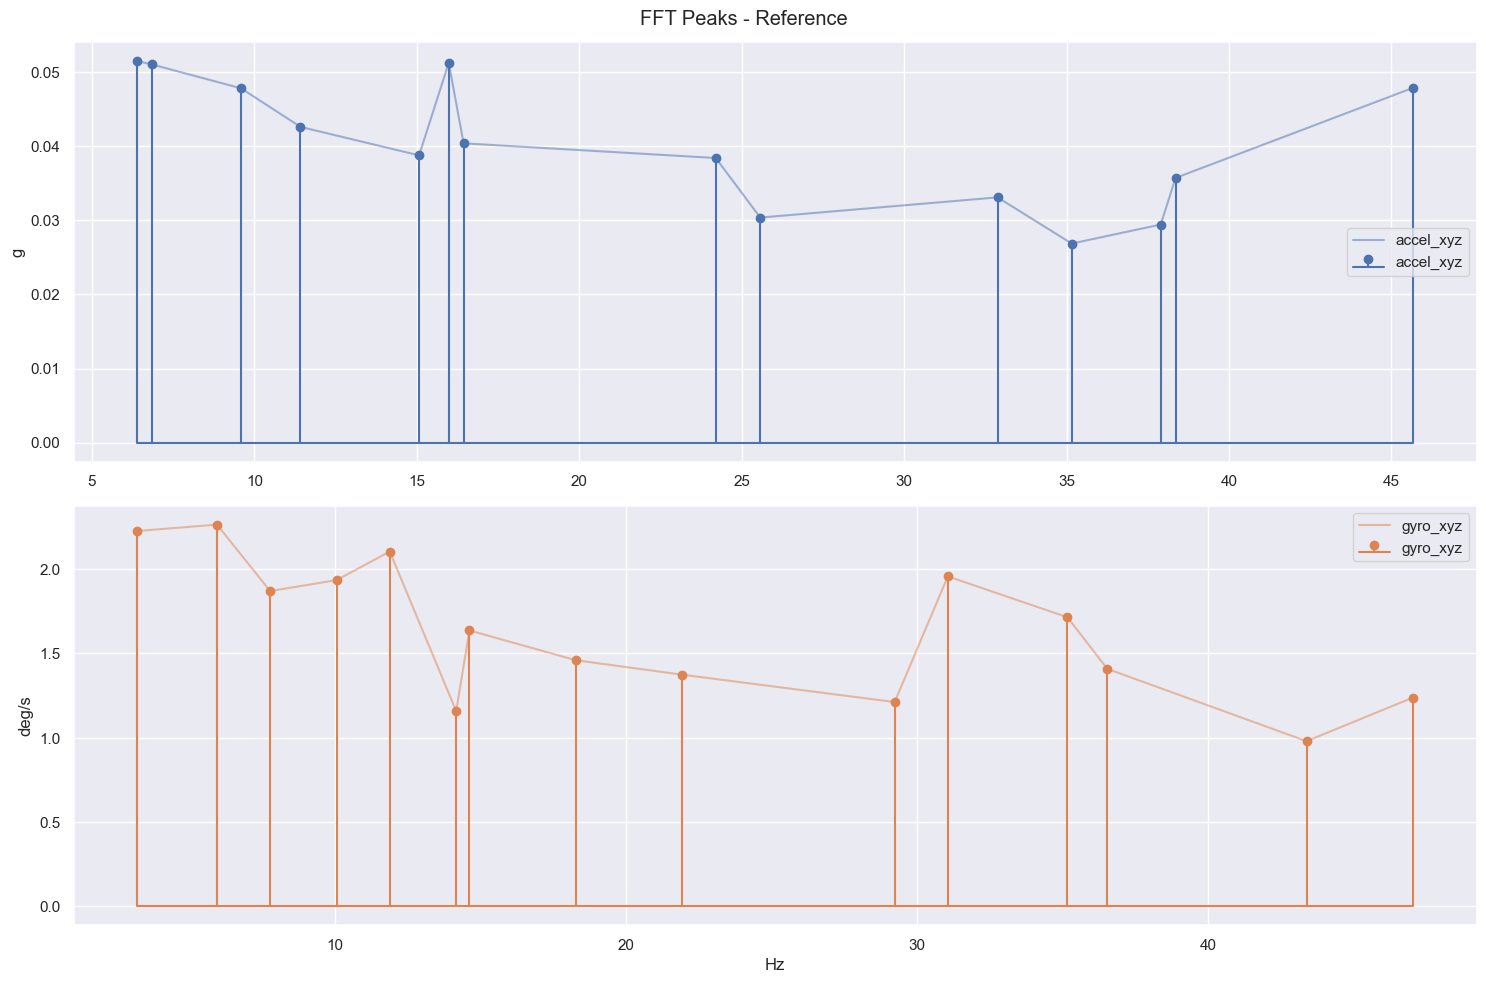

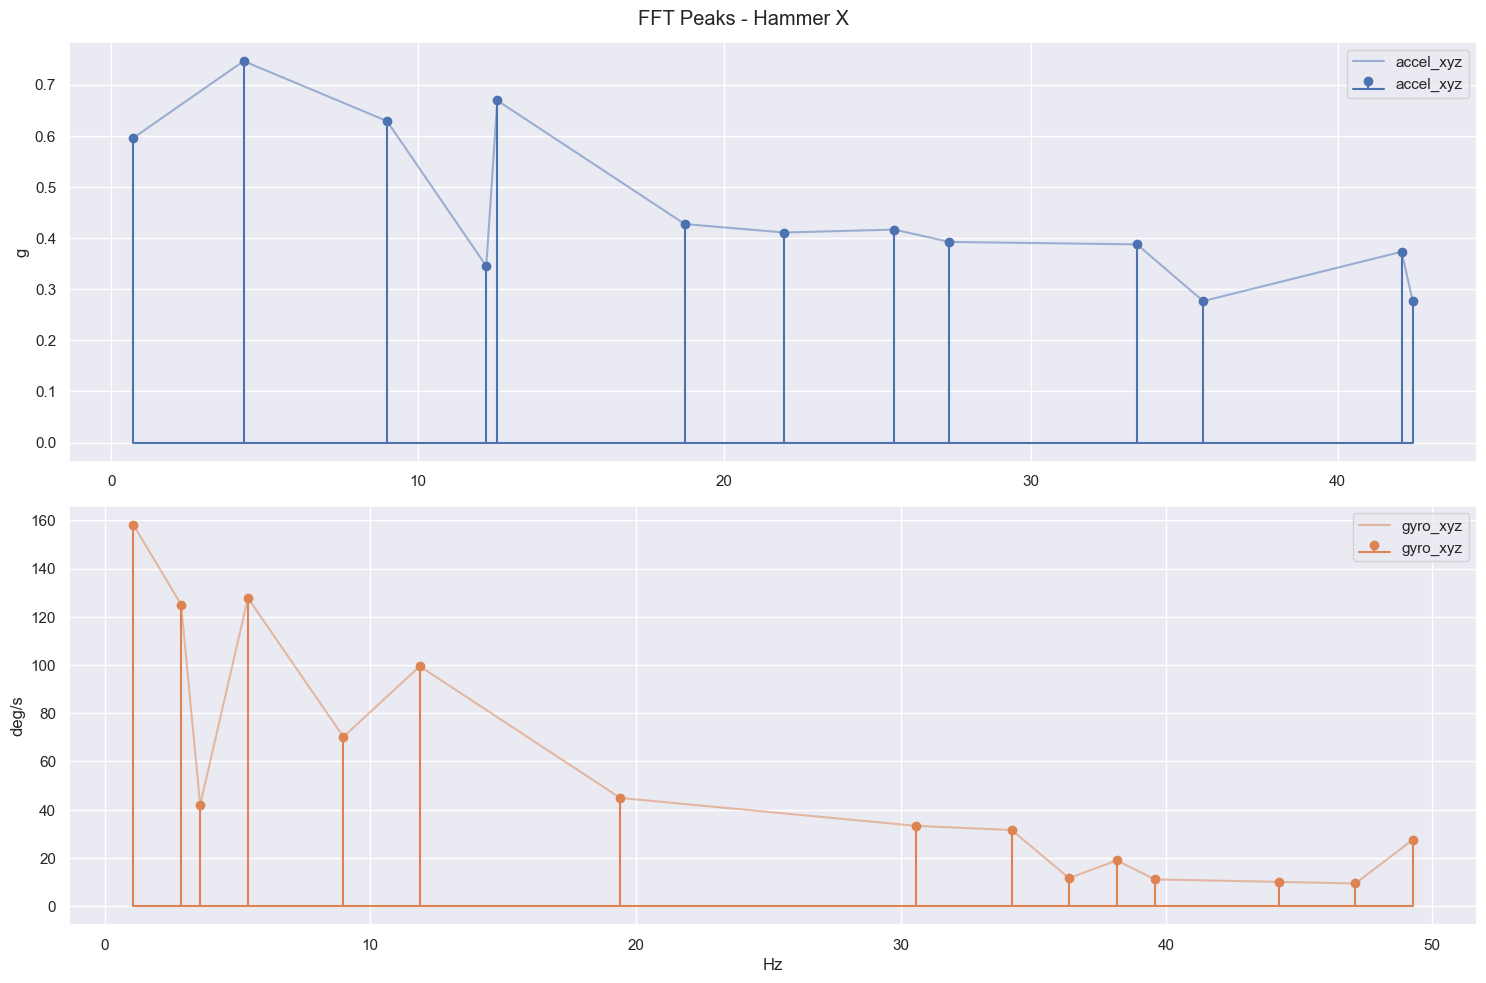

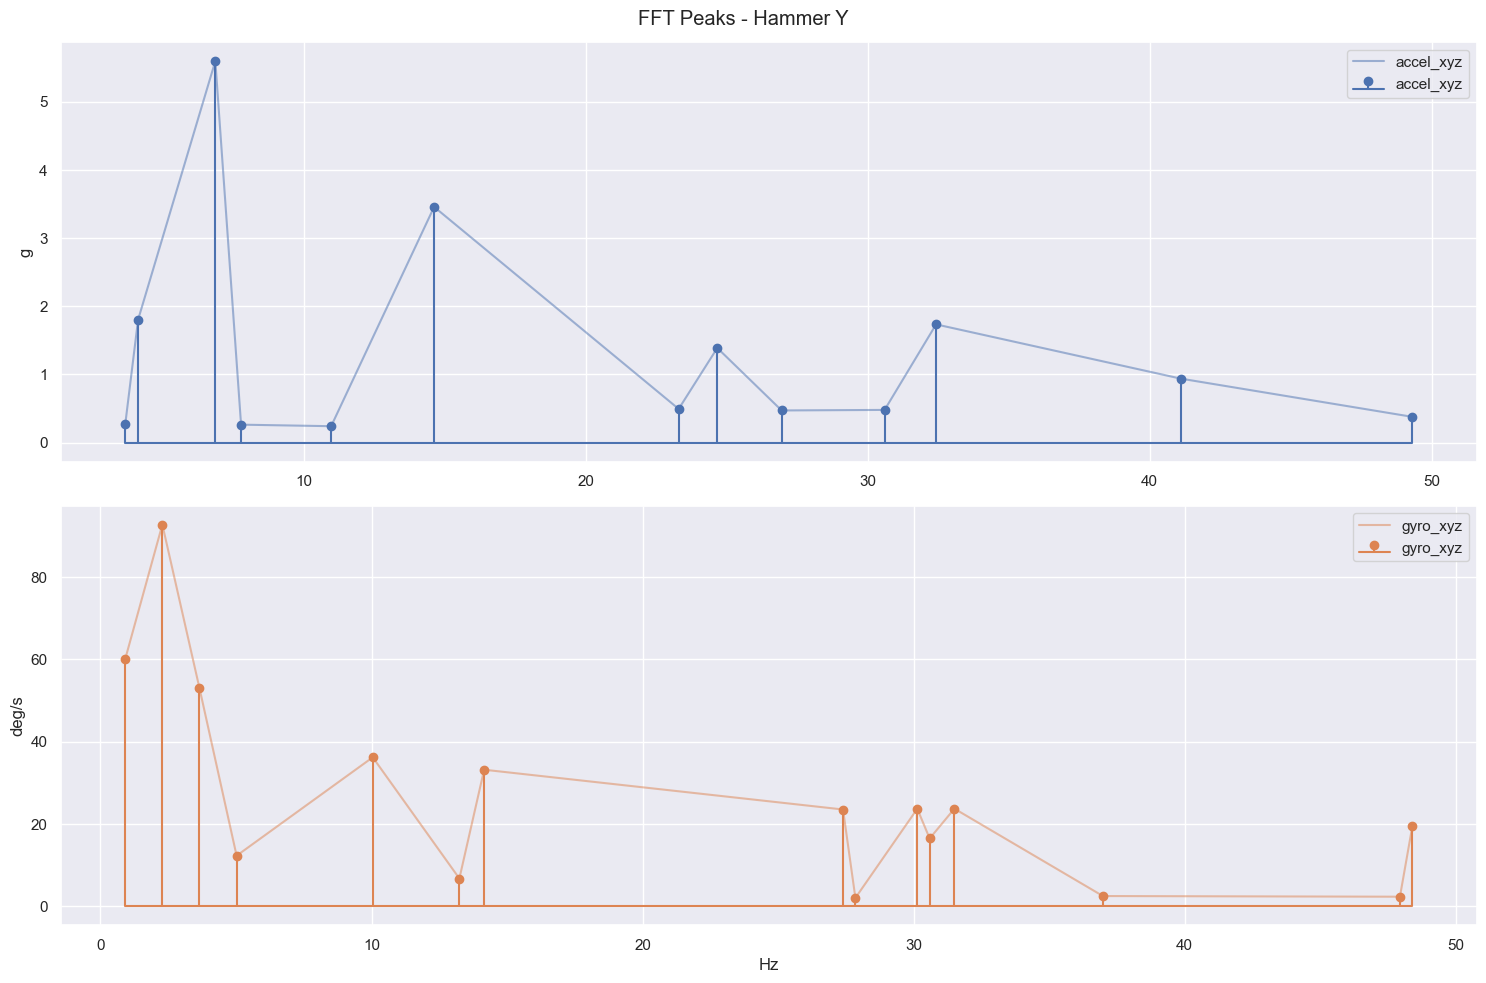

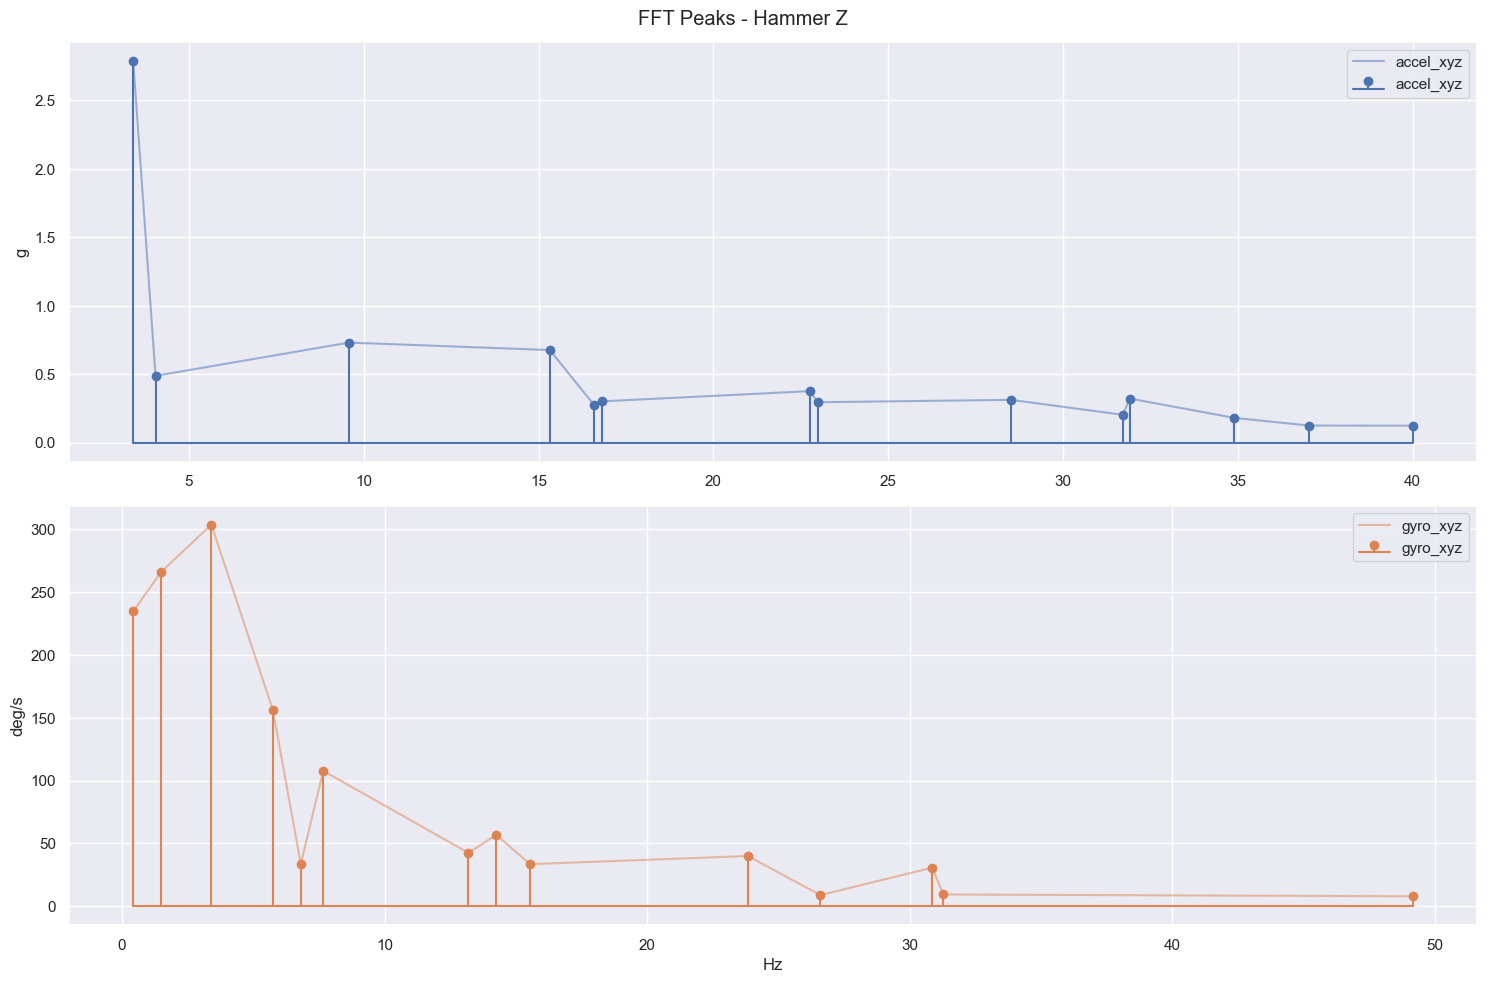

In [236]:
plot_peaks_combined(ref_fft[0], title="Reference")
# plot_peaks_combined(floatingx_fft[0], title="Floating X")
# plot_peaks_combined(floatingy_fft[0], title="Floating Y")
# plot_peaks_combined(floatingz_fft[0], title="Floating Z")
plot_peaks_combined(hammerx_fft[0], title="Hammer X")
plot_peaks_combined(hammery_fft[0], title="Hammer Y")
plot_peaks_combined(hammerz_fft[0], title="Hammer Z")
# plot_peaks_combined(impactx_fft[0], title="Impact X")
# plot_peaks_combined(impacty_fft[0], title="Impact Y")
# plot_peaks_combined(impactz_fft[0], title="Impact Z")
# plot_peaks_combined(rotationx_fft[0], title="Rotation X")
# plot_peaks_combined(rotationy_fft[0], title="Rotation Y")
# plot_peaks_combined(rotationz_fft[0], title="Rotation Z")

In [237]:
accel_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['accel_peaks_freq'], floatingx_fft[0]['accel_peaks'])
gyro_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['gyro_peaks_freq'], floatingx_fft[0]['gyro_peaks'])
accel_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['accel_peaks_freq'], floatingy_fft[0]['accel_peaks'])
gyro_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['gyro_peaks_freq'], floatingy_fft[0]['gyro_peaks'])
accel_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['accel_peaks_freq'], floatingz_fft[0]['accel_peaks'])
gyro_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['gyro_peaks_freq'], floatingz_fft[0]['gyro_peaks'])
accel_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['accel_peaks_freq'], hammerx_fft[0]['accel_peaks'])
gyro_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['gyro_peaks_freq'], hammerx_fft[0]['gyro_peaks'])
accel_hammery_zip = zip_peaks_freq(hammery_fft[0]['accel_peaks_freq'], hammery_fft[0]['accel_peaks'])
gyro_hammery_zip = zip_peaks_freq(hammery_fft[0]['gyro_peaks_freq'], hammery_fft[0]['gyro_peaks'])
accel_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['accel_peaks_freq'], hammerz_fft[0]['accel_peaks'])
gyro_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['gyro_peaks_freq'], hammerz_fft[0]['gyro_peaks'])
accel_impactx_zip = zip_peaks_freq(impactx_fft[0]['accel_peaks_freq'], impactx_fft[0]['accel_peaks'])
gyro_impactx_zip = zip_peaks_freq(impactx_fft[0]['gyro_peaks_freq'], impactx_fft[0]['gyro_peaks'])
accel_impacty_zip = zip_peaks_freq(impacty_fft[0]['accel_peaks_freq'], impacty_fft[0]['accel_peaks'])
gyro_impacty_zip = zip_peaks_freq(impacty_fft[0]['gyro_peaks_freq'], impacty_fft[0]['gyro_peaks'])
accel_impactz_zip = zip_peaks_freq(impactz_fft[0]['accel_peaks_freq'], impactz_fft[0]['accel_peaks'])
gyro_impactz_zip = zip_peaks_freq(impactz_fft[0]['gyro_peaks_freq'], impactz_fft[0]['gyro_peaks'])
accel_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['accel_peaks_freq'], rotationx_fft[0]['accel_peaks'])
gyro_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['gyro_peaks_freq'], rotationx_fft[0]['gyro_peaks'])
accel_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['accel_peaks_freq'], rotationy_fft[0]['accel_peaks'])
gyro_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['gyro_peaks_freq'], rotationy_fft[0]['gyro_peaks'])
accel_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['accel_peaks_freq'], rotationz_fft[0]['accel_peaks'])
gyro_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['gyro_peaks_freq'], rotationz_fft[0]['gyro_peaks'])

sequences_accel = [
    accel_floatingx_zip, accel_floatingy_zip, accel_floatingz_zip,
    accel_hammerx_zip, accel_hammery_zip, accel_hammerz_zip,
    accel_impactx_zip, accel_impacty_zip, accel_impactz_zip,
    accel_rotationx_zip, accel_rotationy_zip, accel_rotationz_zip,
]

sequences_gyro = [
    gyro_floatingx_zip, gyro_floatingy_zip, gyro_floatingz_zip,
    gyro_hammerx_zip, gyro_hammery_zip, gyro_hammerz_zip,
    gyro_impactx_zip, gyro_impacty_zip, gyro_impactz_zip,
    gyro_rotationx_zip, gyro_rotationy_zip, gyro_rotationz_zip,
]

## Data Classification

### Dynamic Time Warping

##### Functions

##### Code

DTW Univariate Distance:  205.7909336105334
DTW Multivariate Distance:  218.45496257617117
DTW Multivariate Normalized Distance:  8.620310893840266


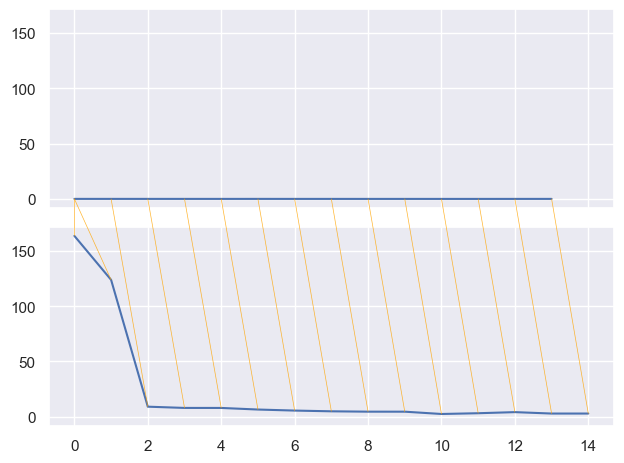

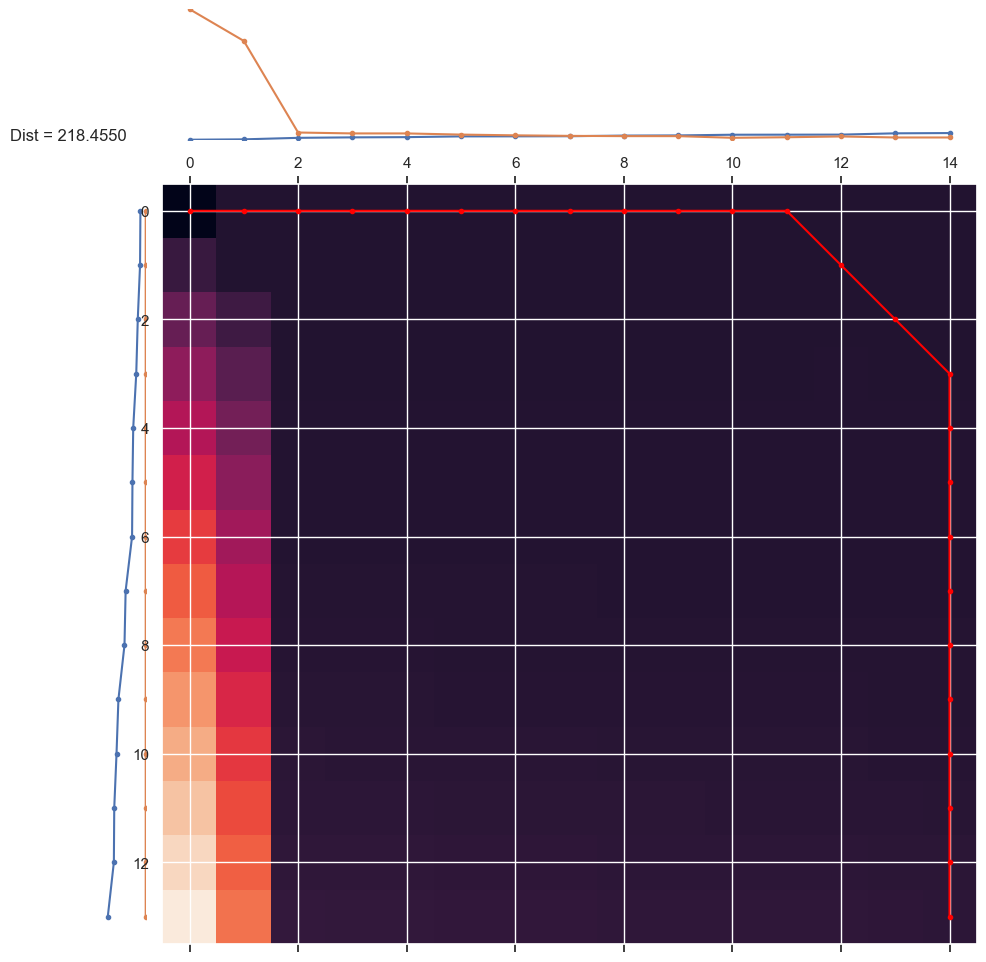

In [238]:
# Calculate the DTW distance between the two sequences
distance = dtw_ndim.distance(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
distance_zip = dtw_ndim.distance(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip)
print("DTW Univariate Distance: ", distance)
print("DTW Multivariate Distance: ", distance_zip)

# plot the univariate warp path
single_path = dtw.warping_path(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
dtwvis.plot_warping(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'], single_path)

# plot the cost matrix and the best path
d, paths = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip)
best_path = dtw.best_path(paths)

dtwvis.plot_warpingpaths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip, paths, best_path)

# normalize the score by dividing the last value of the best path by the length of the best path
score = paths[best_path[-1][0], best_path[-1][1]] / len(best_path)
print("DTW Multivariate Normalized Distance: ", score)

In [239]:
# calculate the DTW distance between the reference and all the other sequences

best_scores = []
for i in range(len(ref_fft)):

    distances = []
    for j in range(len(sequences_accel)):
        d_accel, paths_accel = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['accel_peaks_freq'], ref_fft[i]['accel_peaks']), sequences_accel[j])
        d_gyro, paths_gyro = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['gyro_peaks_freq'], ref_fft[i]['gyro_peaks']), sequences_gyro[j])
        best_path_accel = dtw.best_path(paths_accel)
        best_path_gyro = dtw.best_path(paths_gyro)
        if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
            score = 99999999
        else:

            score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
            score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
            score = score_accel + score_gyro
            # score = d_accel + d_gyro
        distances.append(score)
    # print(distances)
    best_score = [min(distances), distances.index(min(distances))]
    # print(f"Best score: {best_score[0]} with sequence {best_score[1]}")

    best_scores.append(best_score)

print(f"Lenght scores: {len(best_scores)} - Best scores: {best_scores}")


Lenght scores: 126 - Best scores: [[8.165674514455285, 4], [4.580328145239813, 4], [6.190869158819195, 4], [8.355338715026177, 4], [7.479077918135323, 4], [17.03746558569972, 3], [17.417207091766535, 5], [21.95368960485324, 5], [21.85585892607595, 5], [22.618872366588093, 5], [9.676783256713202, 5], [8.904041137194596, 5], [7.927427223006058, 5], [7.969497220225435, 5], [7.657598926647532, 4], [10.15076555140988, 5], [10.301365086457192, 5], [25.694539614756547, 5], [45.84097609599372, 5], [34.24996697585247, 5], [41.75324621973529, 5], [40.90440682055845, 5], [33.29030427314427, 5], [14.13169472127471, 5], [46.34045460371611, 3], [55.458476722660805, 5], [56.82159755493103, 5], [44.68574995534485, 5], [47.6167805331407, 5], [80.93743788171322, 5], [231.41428650939764, 3], [95.64663235657574, 10], [299.6544089195093, 7], [412.8423340555632, 6], [154.53362339977826, 10], [151.9701980340275, 6], [387.75028393293167, 3], [384.33003864167694, 3], [301.04187720997055, 5], [292.1765413451697

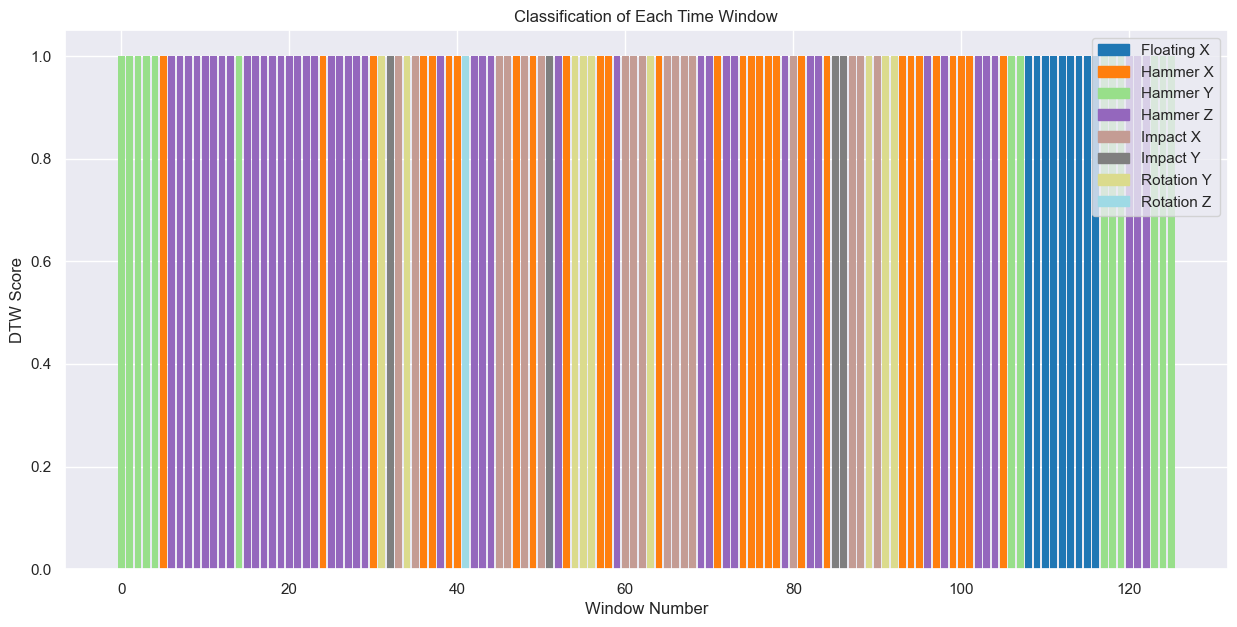

In [240]:
classes_names = [
    'Floating X', 'Floating Y', 'Floating Z',
    'Hammer X', 'Hammer Y', 'Hammer Z',
    'Impact X', 'Impact Y', 'Impact Z',
    'Rotation X', 'Rotation Y', 'Rotation Z'
]
merged_classes_names = [
    'Floating',
    'Hammer',
    'Impact',
    'Rotation'
]

# Extract classifications from best_scores
classifications = [item[1] for item in best_scores]

# Create a dictionary mapping window ID to classification
window_to_classification = {i: class_id for i, class_id in enumerate(classifications)}

# Define a function to map window IDs to classifications
def get_classifications(window_ids):
    return [window_to_classification.get(window_id) for window_id in window_ids]

# Apply the function to the 'window_id' column to create the 'infer_classes' column
df_ref_over['infer_classes'] = df_ref_over['window_id'].apply(get_classifications)

# Generate a unique color for each classification
unique_classifications = list(set(classifications))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classifications)))  # Using 'tab20' for more distinct colors
color_map = dict(zip(unique_classifications, colors))

# Plotting the histogram with height of 1.0 for each bar
plt.figure(figsize=(15, 7))
for i, classification in enumerate(classifications):
    plt.bar(i, 1.0, color=color_map[classification], edgecolor='None')

# Creating the legend
legend_handles = [mpatches.Patch(color=color_map[cls], label=classes_names[cls]) for cls in unique_classifications]
plt.legend(handles=legend_handles)

# Setting up the axes and labels
plt.xlabel("Window Number")
plt.ylabel("DTW Score")
plt.title("Classification of Each Time Window")
# plt.xticks(range(len(scores)))  # Set x-ticks to be the window numbers

plt.show()


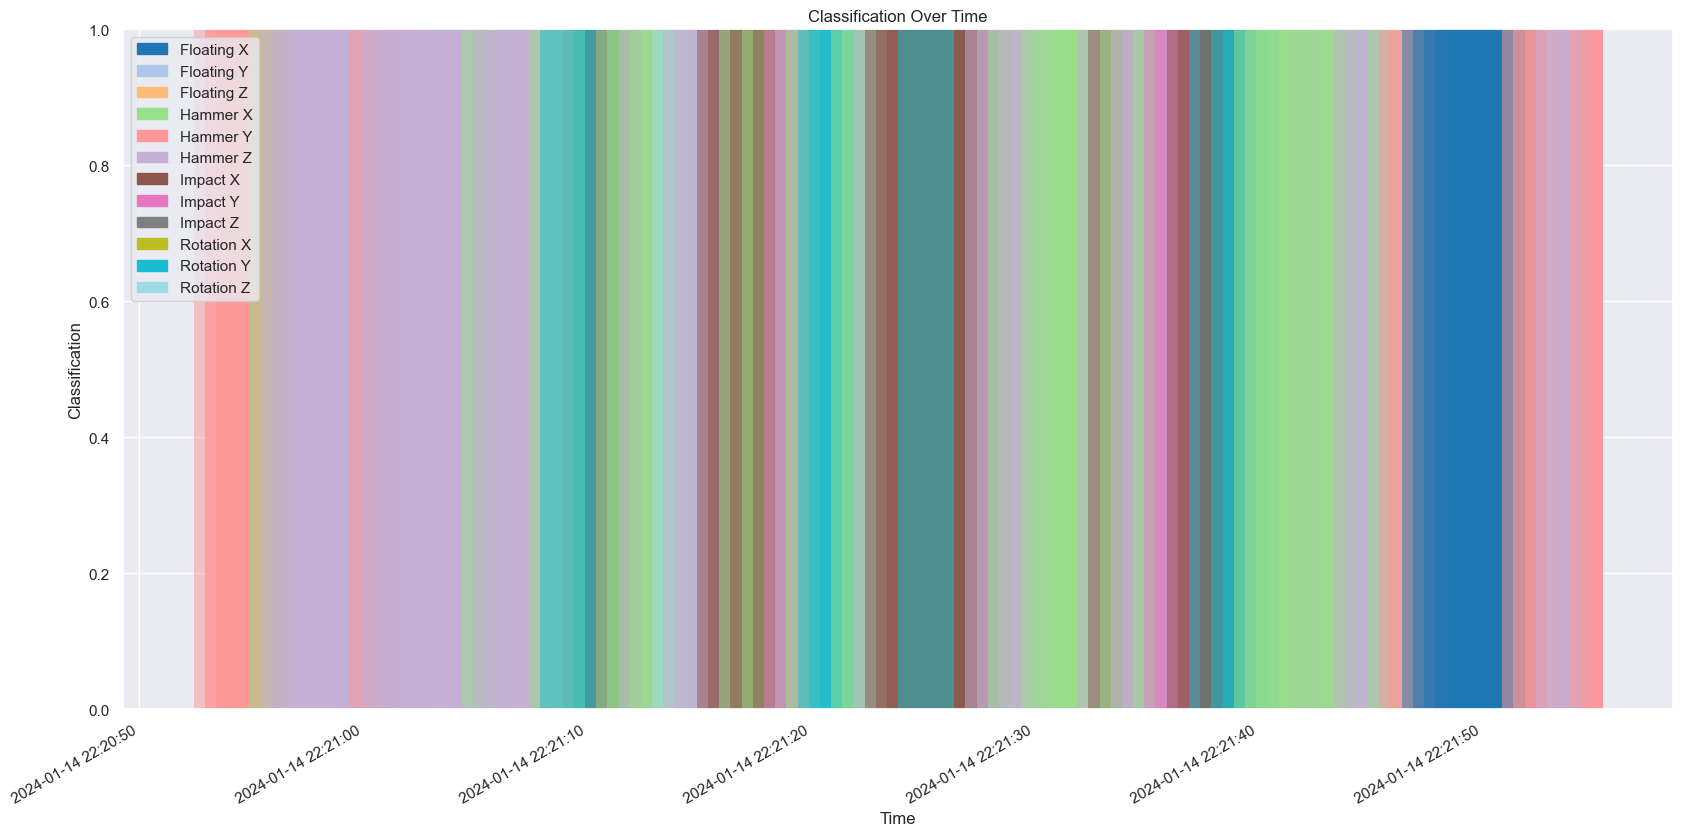

In [241]:
# Create a new DataFrame for plotting purposes
plot_df = pd.DataFrame(index=df_ref_over.index)

# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color for each classification
colors = plt.cm.tab20(np.linspace(0, 1, len(classes_names)))

# Plot a span for each window
for window_id, times in window_times.items():
    # Get the classifications for this window
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    for class_id in class_ids:
        class_name = classes_names[class_id]
        color = colors[class_id]
        plt.axvspan(times[0], times[1], facecolor=color, alpha=0.5, label=class_name, edgecolor='None')

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - we create a patch for each class
handles = [plt.Rectangle((0,0),1,1, color=colors[class_id], label=class_name) for class_id, class_name in enumerate(classes_names)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Classification Over Time")

plt.grid(True)

plt.show()


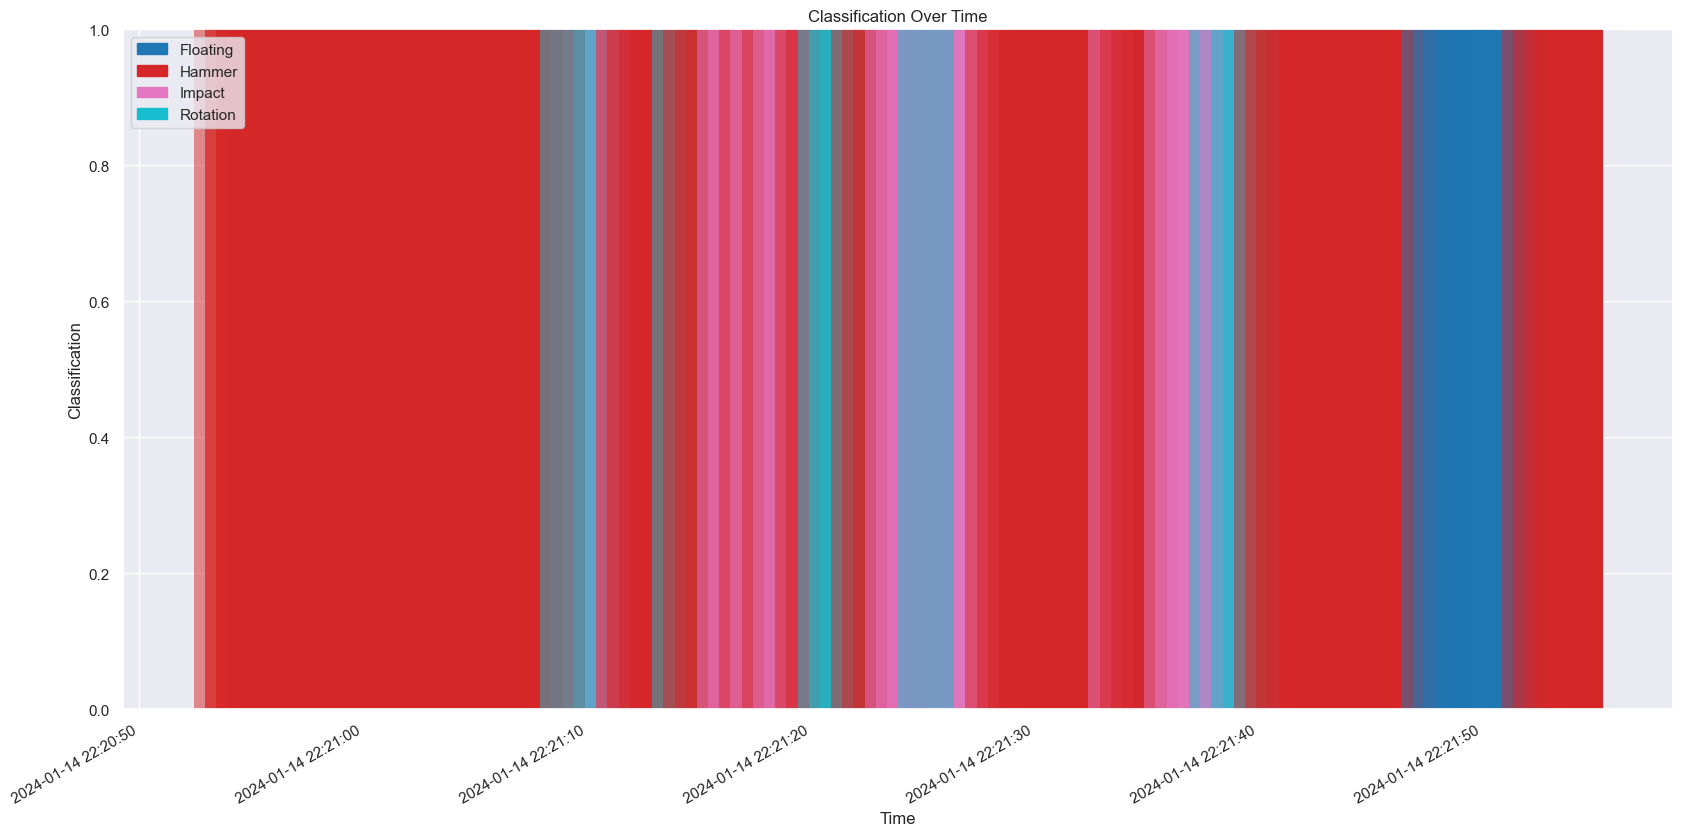

In [242]:
# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color for every three classes
group_size = 3  # Number of classes to merge into one color
num_groups = (len(classes_names) + group_size - 1) // group_size  # Calculate the number of groups
colors = plt.cm.tab10(np.linspace(0, 1, num_groups))  # Use tab10 or another colormap as needed

# Plot a span for each window
for window_id, times in window_times.items():
    # Ensure class_ids is a list, even if it's a single integer
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    if isinstance(class_ids, int):
        class_ids = [class_ids]  # Make it a list if it's not

    # Determine the group color for each class_id
    for class_id in class_ids:
        group_id = class_id // group_size  # Integer division to find the group
        color = colors[group_id]  # Assign color by group
        plt.axvspan(times[0], times[1], facecolor=color, alpha=0.5, edgecolor='None')

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - create a patch for each group of classes
handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=merged_classes_names[i]) for i in range(num_groups)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Classification Over Time")

plt.grid(True)

plt.show()

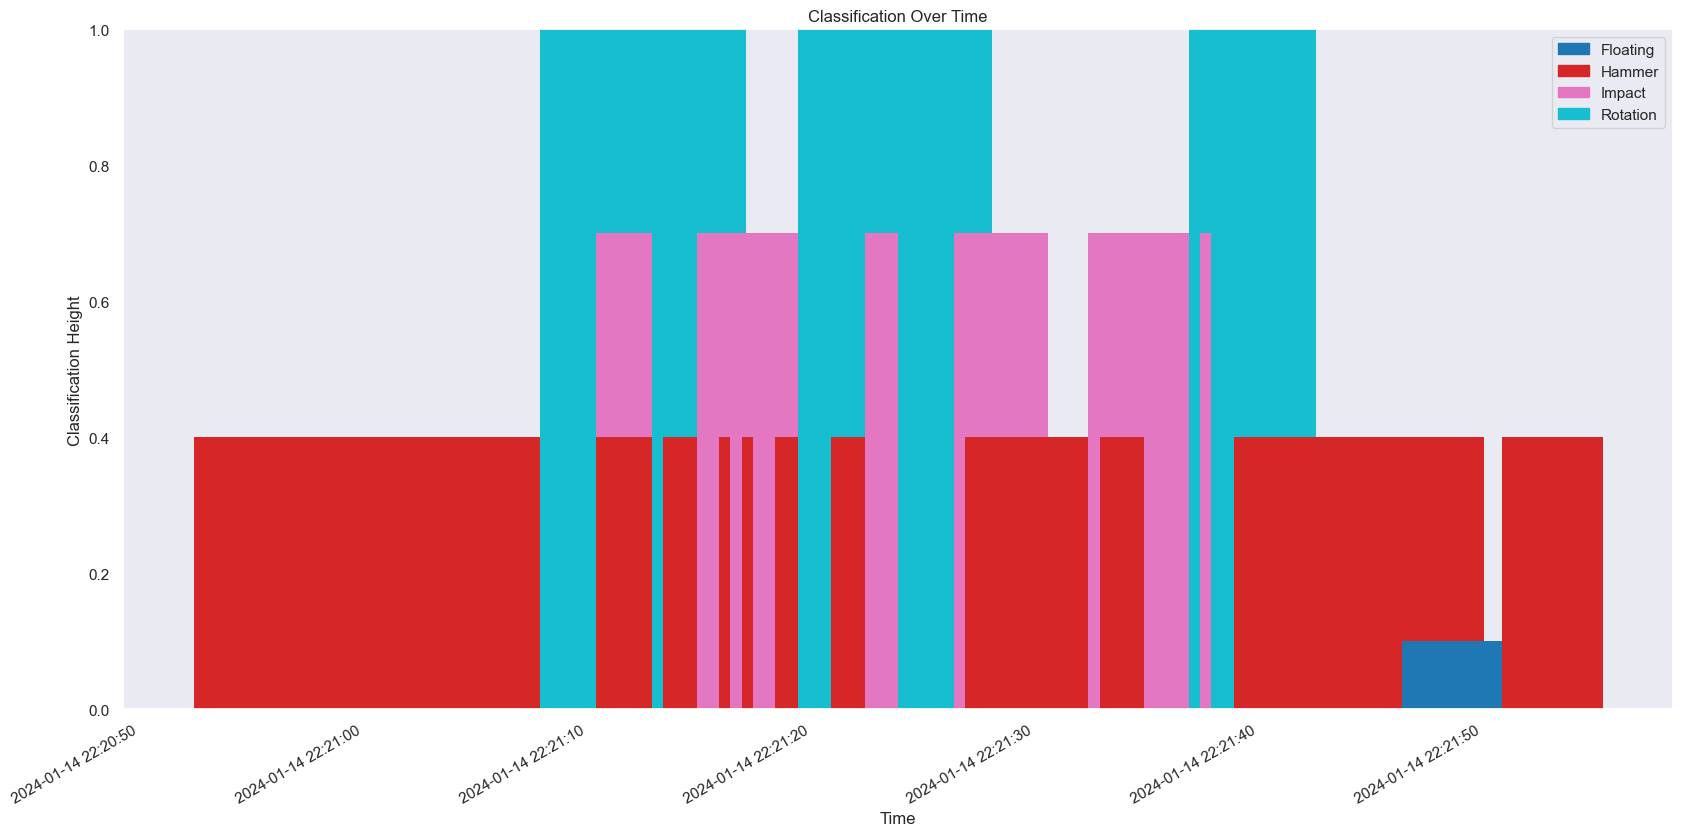

In [243]:
# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color and height for every three classes
group_size = 3  # Number of classes to merge into one group
num_groups = (len(classes_names) + group_size - 1) // group_size  # Calculate the number of groups
colors = plt.cm.tab10(np.linspace(0, 1, num_groups))  # Use tab10 or another colormap as needed

# Define the heights for each group
heights = np.linspace(0.1, 1, num_groups)

# Plot a span for each window
for window_id, times in window_times.items():
    # Ensure class_ids is a list, even if it's a single integer
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    if isinstance(class_ids, int):
        class_ids = [class_ids]  # Make it a list if it's not

    # Determine the group color and height for each class_id
    for class_id in class_ids:
        group_id = class_id // group_size  # Integer division to find the group
        color = colors[group_id]  # Assign color by group
        height = heights[group_id]  # Assign height by group
        plt.axvspan(times[0], times[1], ymin=0, ymax=height, facecolor=color, label=f'Group {group_id+1}', alpha=1, edgecolor='None')
        # plt.axvspan(times[0], times[1], ymin=0, ymax=height, facecolor=color, label=f'Group {group_id+1}', alpha=1, zorder=-group_id)

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - create a patch for each group of classes
handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=merged_classes_names[i]) for i in range(num_groups)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification Height")
plt.title("Classification Over Time")

plt.grid(False)

plt.show()

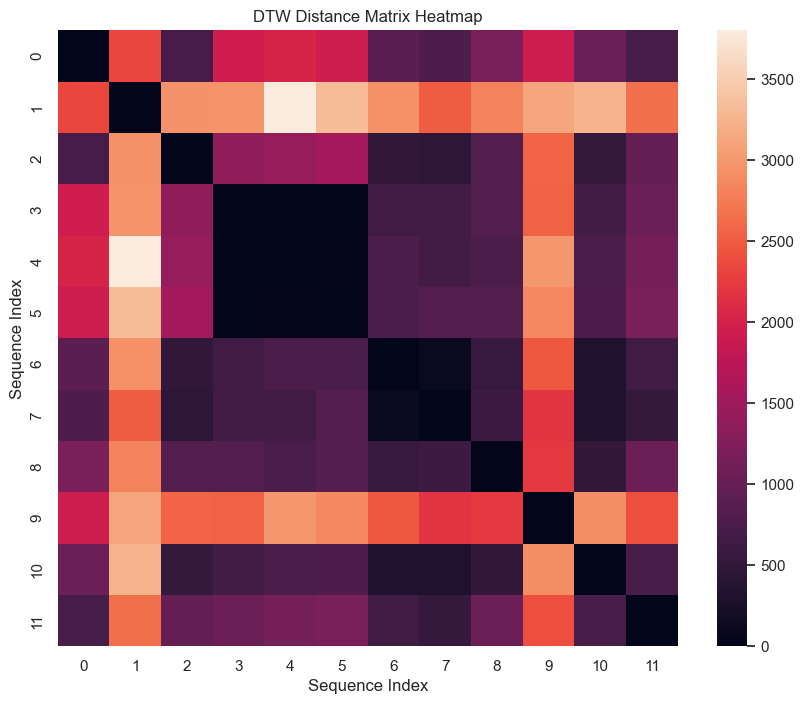

In [244]:

# Initialize a 12x12 matrix of zeros for the distances
distance_matrix = np.zeros((len(sequences_accel), len(sequences_accel)))

# Calculate the DTW distance between each pair of sequences
for i in range(len(sequences_accel)):
    for j in range(len(sequences_accel)):
        if i != j:  # No need to calculate when i == j since the distance is zero
            d_accel, paths_accel = dtw_ndim.warping_paths(sequences_accel[i], sequences_accel[j])
            d_gyro, paths_gyro = dtw_ndim.warping_paths(sequences_gyro[i], sequences_gyro[j])
            best_path_accel = dtw.best_path(paths_accel)
            best_path_gyro = dtw.best_path(paths_gyro)
            if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
                score = 99999999
            else:

                score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
                score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
                score = score_accel + score_gyro

            distance_matrix[i, j] = score

# Now, create a heatmap from the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f")
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.show()

# Real Data Analysis

## Data Overview

### Imports

In [41]:
# Load the dataset
file_path = "acquisitions/onsite_test/processed/20240215/apple1_test1.csv"
ref_file_path = "acquisitions/onsite_test/processed/20240215/apple1_test1.csv"
# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_ref = pd.read_csv(ref_file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_ref['_time'] = pd.to_datetime(df_ref['_time'])

### Raw Data Analysis

##### Functions

In [42]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, zone):

    # Getting the series ID for the action
    series_id = data[data['zone'] == zone]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['zone'] == zone)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Zones {zone}')
    plt.show()

In [43]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

##### Code

In [44]:
df.head()

measurement_id     gyro_x     gyro_y     gyro_z   accel_x   accel_y  \
0               0   7.987805  26.463415 -25.609756  0.131836  0.018555   
1               1   7.987805  26.463415 -25.609756  0.131836  0.018555   
2               2  10.060976   5.670732 -16.951220 -0.045898 -0.071045   
3               3  10.060976   5.670732 -16.951220 -0.045898 -0.071045   
4               4  22.500000 -35.975610  19.451220 -0.009521 -0.009766   

    accel_z  quat_x  quat_y  quat_z  quat_w  time_diff  accel_mag   gyro_mag  \
0 -0.944580    0.00    0.00     0.0    0.00   0.000000   0.953916  37.682581   
1 -0.944580    0.00    0.00     0.0    0.00   0.010603   0.953916  37.682581   
2  0.035156    0.12    0.61     0.6    0.50   0.348952   0.091597  20.511564   
3  0.035156    0.12    0.61     0.6    0.50   0.006993   0.091597  20.511564   
4 -0.112305    0.16    0.62     0.6    0.48   0.083494   0.113130  46.678094   

   zone                      _time  series_id  
0     0 2024-02-15 10:37:46.523849          0  
1     0 2024-02-15 10:37:46.534452          0  
2     0 2024-02-15 10:37:46.883404          0  
3     0 2024-02-15 10:37:46.890397          0  
4     0 2024-02-15 10:37:46.973891          0

In [45]:
df.describe()

measurement_id       gyro_x       gyro_y       gyro_z      accel_x  \
count     5801.000000  5801.000000  5801.000000  5801.000000  5801.000000   
mean      2900.000000   -22.833258   -37.654578     7.266357     0.004115   
min          0.000000  -857.804878  -751.829268  -620.731707    -7.725830   
25%       1450.000000   -15.670732   -32.317073   -10.304878    -0.048340   
50%       2900.000000    -0.243902    -0.792683     0.000000     0.000488   
75%       4350.000000     8.292683     5.060976    13.963415     0.059814   
max       5800.000000   653.658537   775.548781  1160.731707     5.948486   
std       1674.748787   125.621645   173.773205   131.515052     0.424600   

           accel_y      accel_z       quat_x       quat_y       quat_z  \
count  5801.000000  5801.000000  5801.000000  5801.000000  5801.000000   
mean     -0.007688     0.009305    -0.148037     0.213722     0.165111   
min      -7.430664    -7.281006    -0.930000    -0.970000    -0.990000   
25%      -0.048096    -0.054443    -0.400000    -0.040000    -0.430000   
50%       0.004150     0.005859    -0.120000     0.310000     0.300000   
75%       0.050049     0.071533     0.010000     0.620000     0.610000   
max       7.118408     6.625000     0.970000     0.990000     0.970000   
std       0.394355     0.409894     0.334422     0.456572     0.558520   

            quat_w    time_diff    accel_mag     gyro_mag         zone  \
count  5801.000000  5801.000000  5801.000000  5801.000000  5801.000000   
mean      0.455516     0.027282     0.333688   145.977564     2.759869   
min       0.000000     0.000000     0.001968     0.000000     0.000000   
25%       0.230000     0.005744     0.060816     6.171202     1.000000   
50%       0.480000     0.028204     0.128983    35.532304     3.000000   
75%       0.650000     0.043799     0.346032   227.010639     5.000000   
max       0.940000     0.674403    11.530512  1448.984141     5.000000   
std       0.255045     0.028529     0.626586   209.650610     2.027590   

                               _time    series_id  
count                           5801  5801.000000  
mean   2024-02-15 10:39:04.879816192     2.759869  
min       2024-02-15 10:37:46.523849     0.000000  
25%    2024-02-15 10:38:18.967994112     1.000000  
50%    2024-02-15 10:39:04.688307968     3.000000  
75%    2024-02-15 10:39:48.519068928     5.000000  
max       2024-02-15 10:40:24.789191     5.000000  
std                              NaN     2.027590

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5801 entries, 0 to 5800
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   measurement_id  5801 non-null   int64         
 1   gyro_x          5801 non-null   float64       
 2   gyro_y          5801 non-null   float64       
 3   gyro_z          5801 non-null   float64       
 4   accel_x         5801 non-null   float64       
 5   accel_y         5801 non-null   float64       
 6   accel_z         5801 non-null   float64       
 7   quat_x          5801 non-null   float64       
 8   quat_y          5801 non-null   float64       
 9   quat_z          5801 non-null   float64       
 10  quat_w          5801 non-null   float64       
 11  time_diff       5801 non-null   float64       
 12  accel_mag       5801 non-null   float64       
 13  gyro_mag        5801 non-null   float64       
 14  zone            5801 non-null   int64         
 15  _tim

In [47]:
# groupby by action
df_grouped = df.groupby('zone')

# Grouping data by series_id and action
df_grouped_id = df.groupby(['series_id', 'zone']).size().unstack(fill_value=0)
# show all the actions
# print(df_grouped.groups.keys())

Check how many samples there are in each sequence.

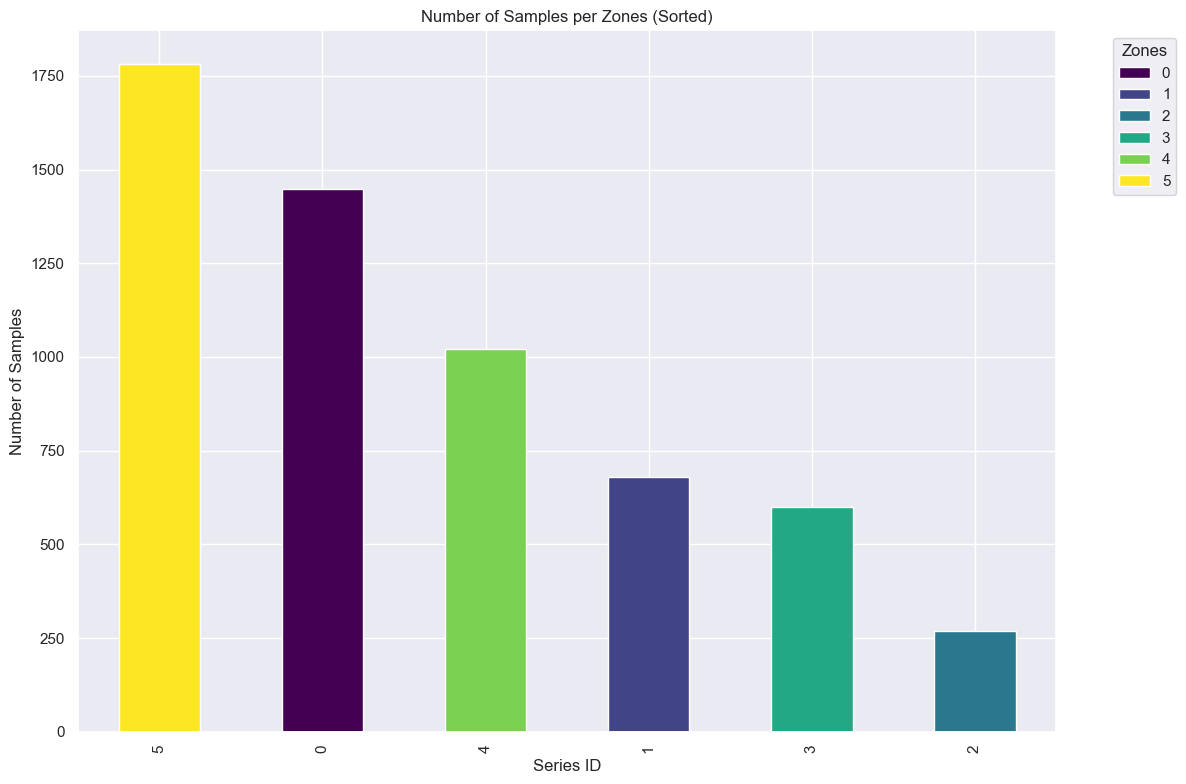

In [48]:

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = df_grouped_id.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = df_grouped_id.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Zones (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Zones', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

Correlation matrix to see the relations among features for each sequence

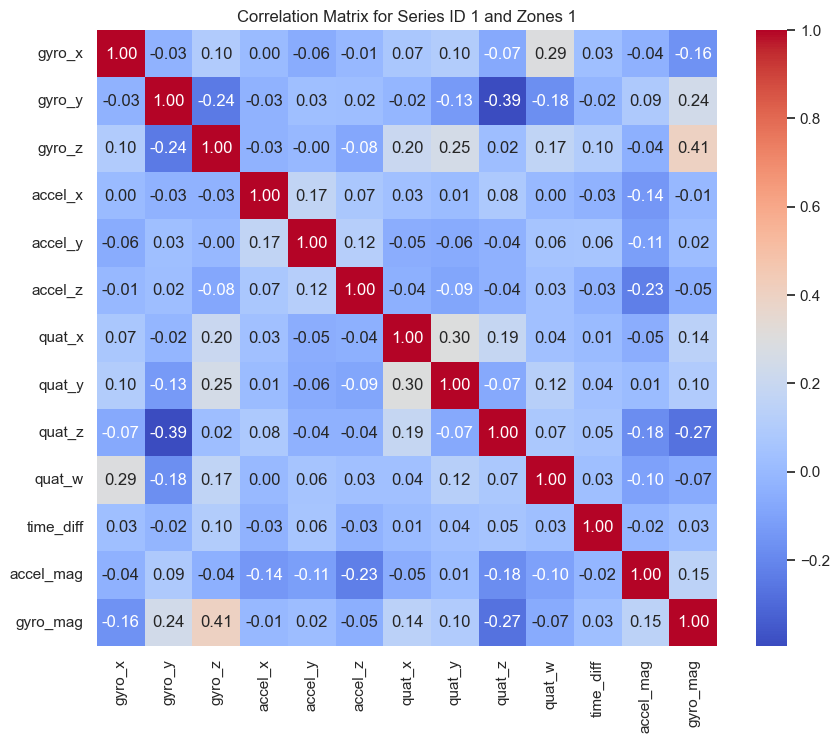

In [51]:
# plot_correlation_matrix(df,0)
plot_correlation_matrix(df,1)
# plot_correlation_matrix(df,2)
# plot_correlation_matrix(df,3)
# plot_correlation_matrix(df,4)
# plot_correlation_matrix(df,5)


In [52]:
df_time = df.copy()
df_time['time_diff'] = df_time.groupby('series_id')['_time'].diff()
df_time = df_time.dropna()
df_time['time_diff_seconds'] = df_time['time_diff'].dt.total_seconds()

Visualize the sampling time difference distribution for each sequence

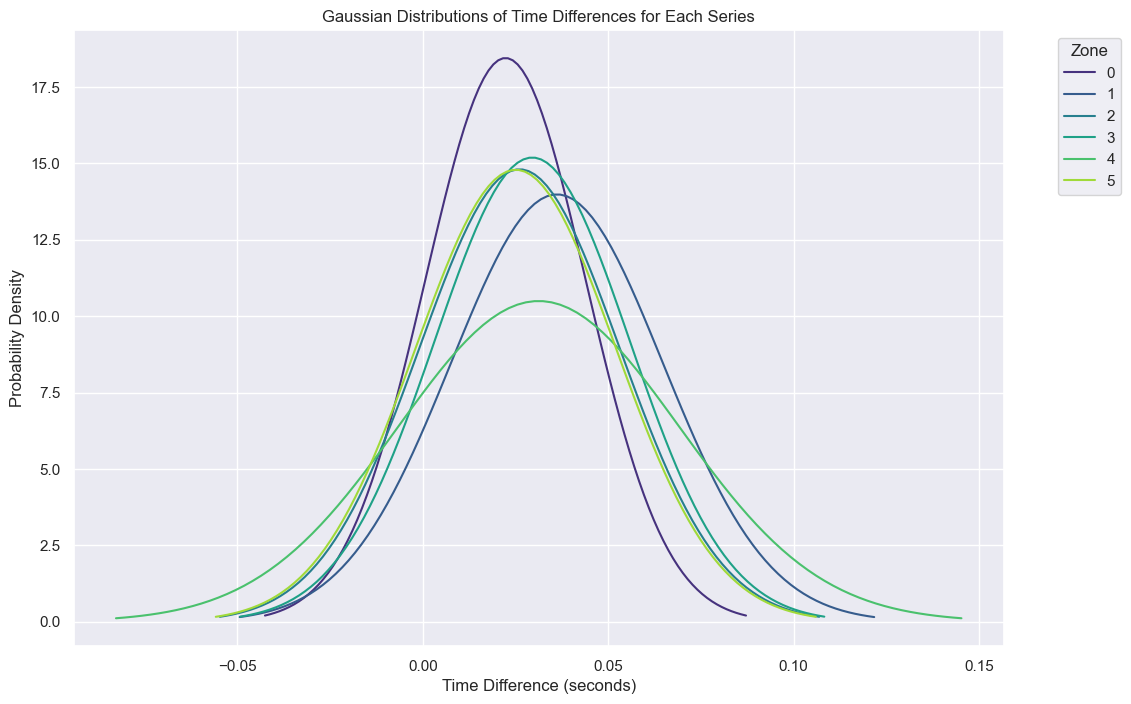

-------------------
Minimum mean: 0.02231252348066298
Maximum mean: 0.03618714138438881
Minimum std: 0.021624338775038592
Maximum std: 0.038005375474716115
-------------------
Slowest sampling time: 0.04 seconds
Fastest sampling time: 0.02 seconds


In [53]:
# Create a mapping of series_id to action
action_mapping = df_time.dropna().groupby('series_id')['zone'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(df_time['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(df_time['series_id'].unique())):
    # Selecting the series
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()

# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in df_time['series_id'].unique():
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    # print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

print(f'Slowest sampling time: {round(max(series_mean), 2)} seconds')
print(f'Fastest sampling time: {round(min(series_mean), 2)} seconds')

In [54]:
df_zone0 = df_grouped.get_group(0)
df_zone1 = df_grouped.get_group(1)
df_zone2 = df_grouped.get_group(2)
df_zone3 = df_grouped.get_group(3)
df_zone4 = df_grouped.get_group(4)
df_zone5 = df_grouped.get_group(5)

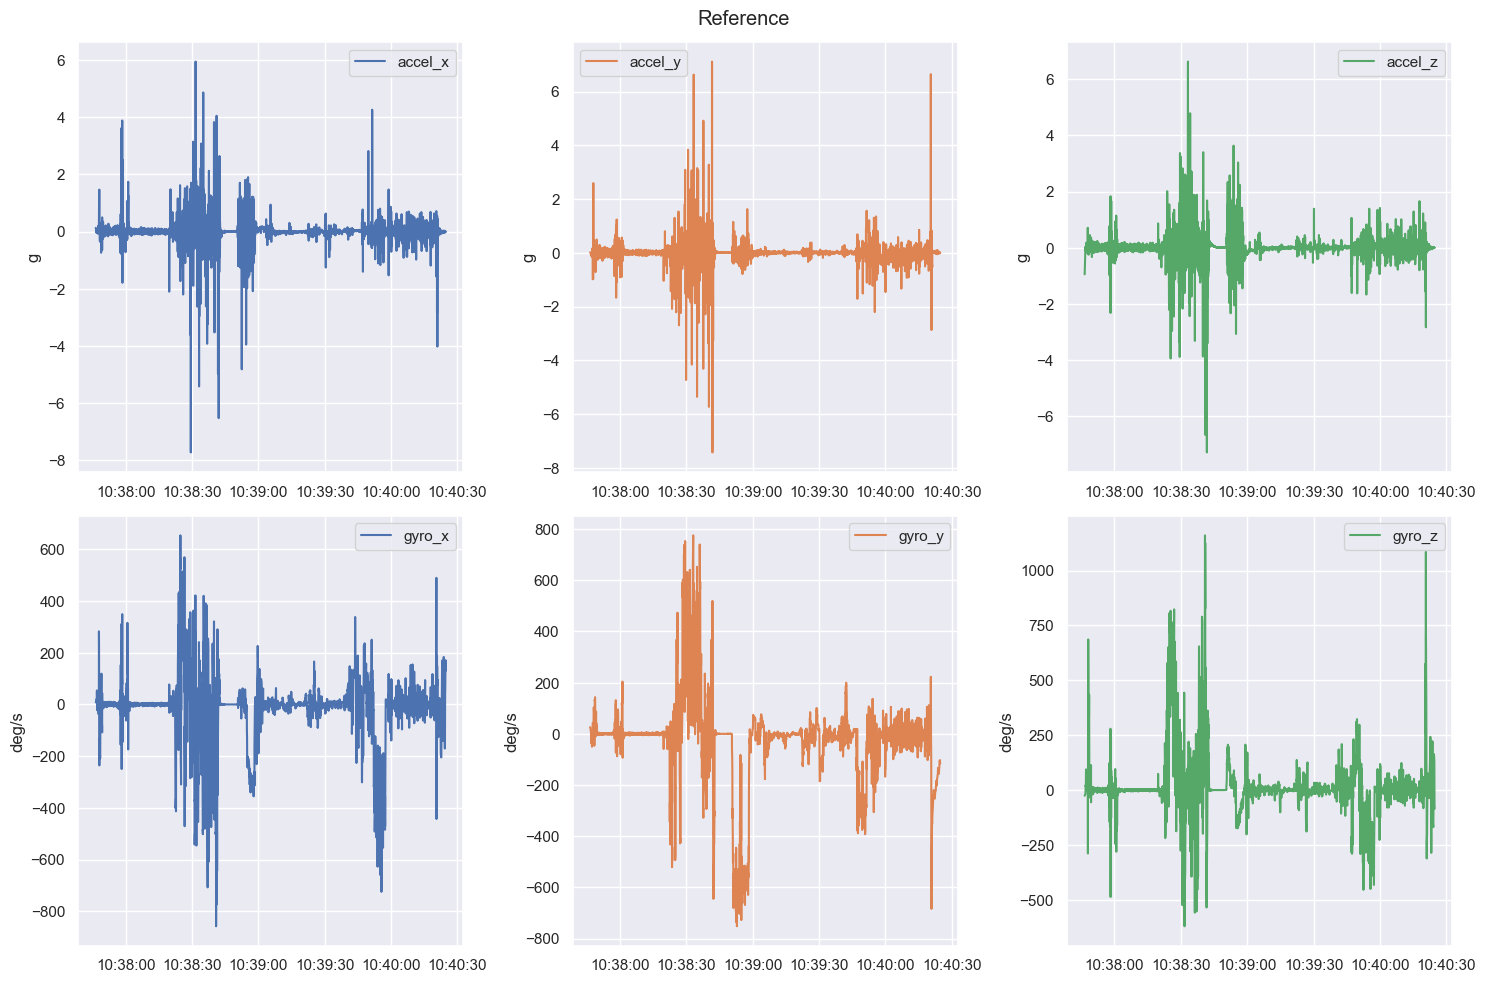

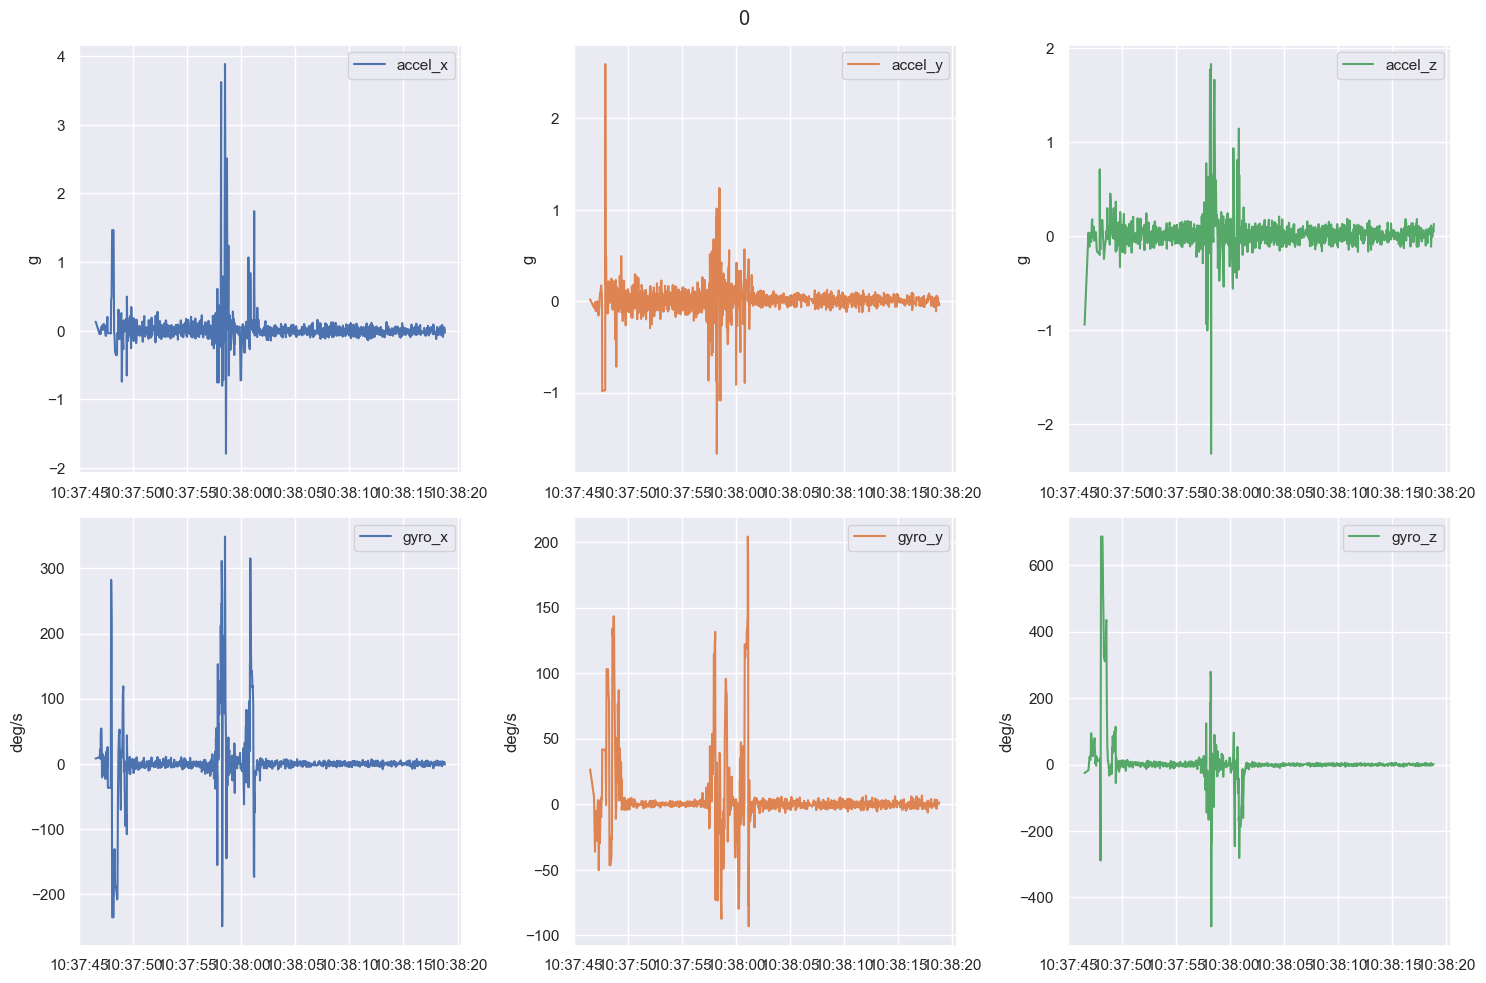

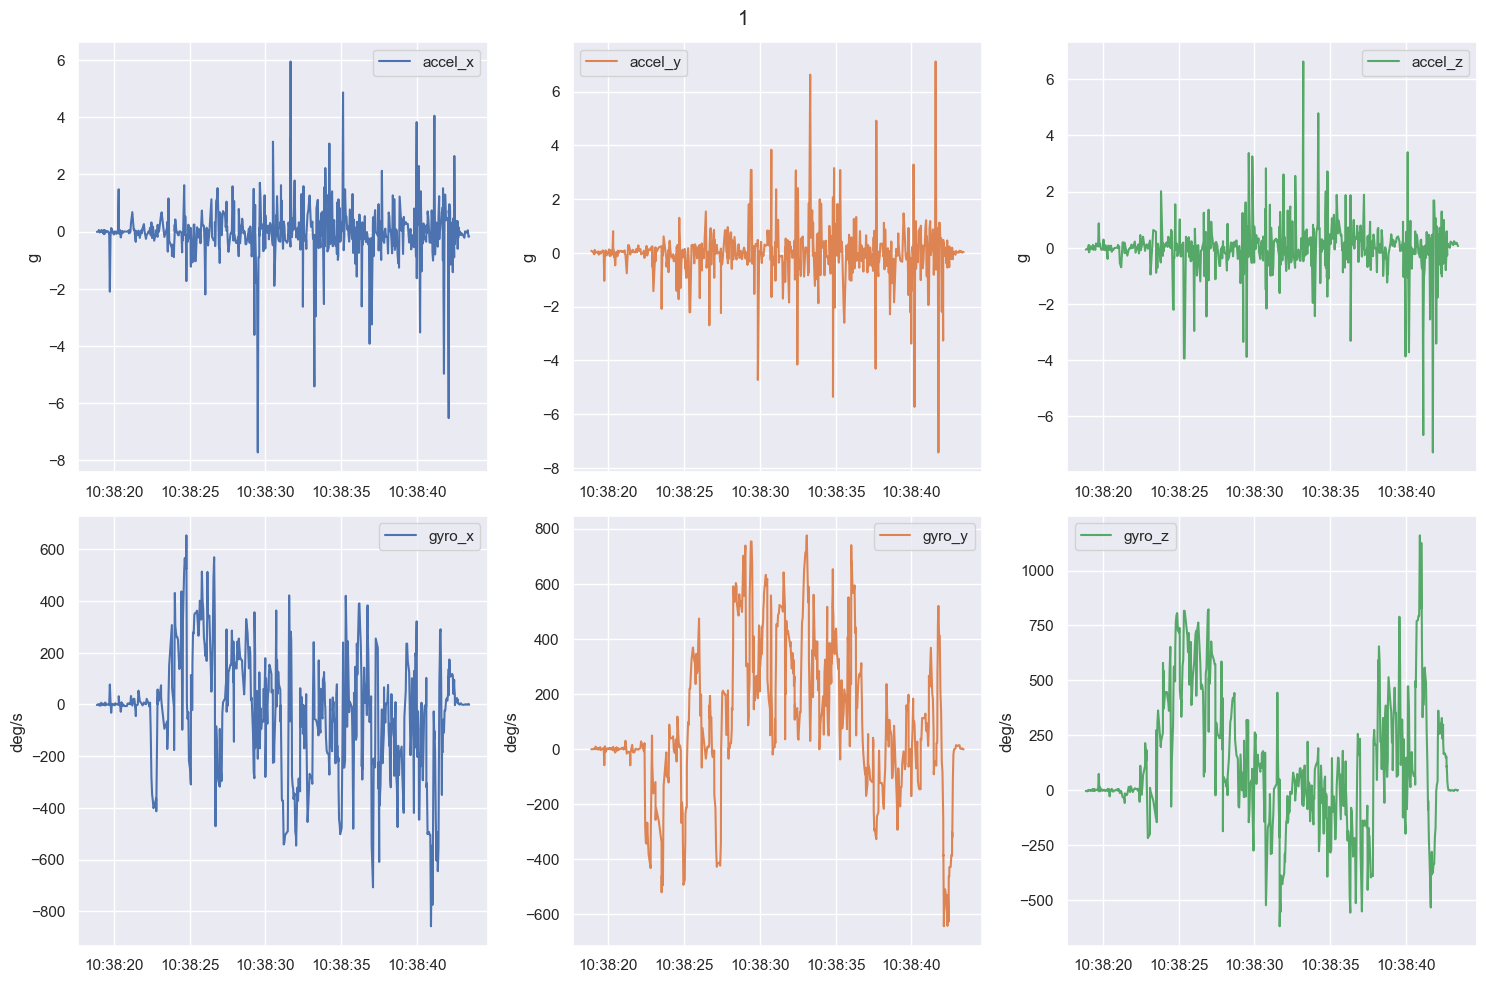

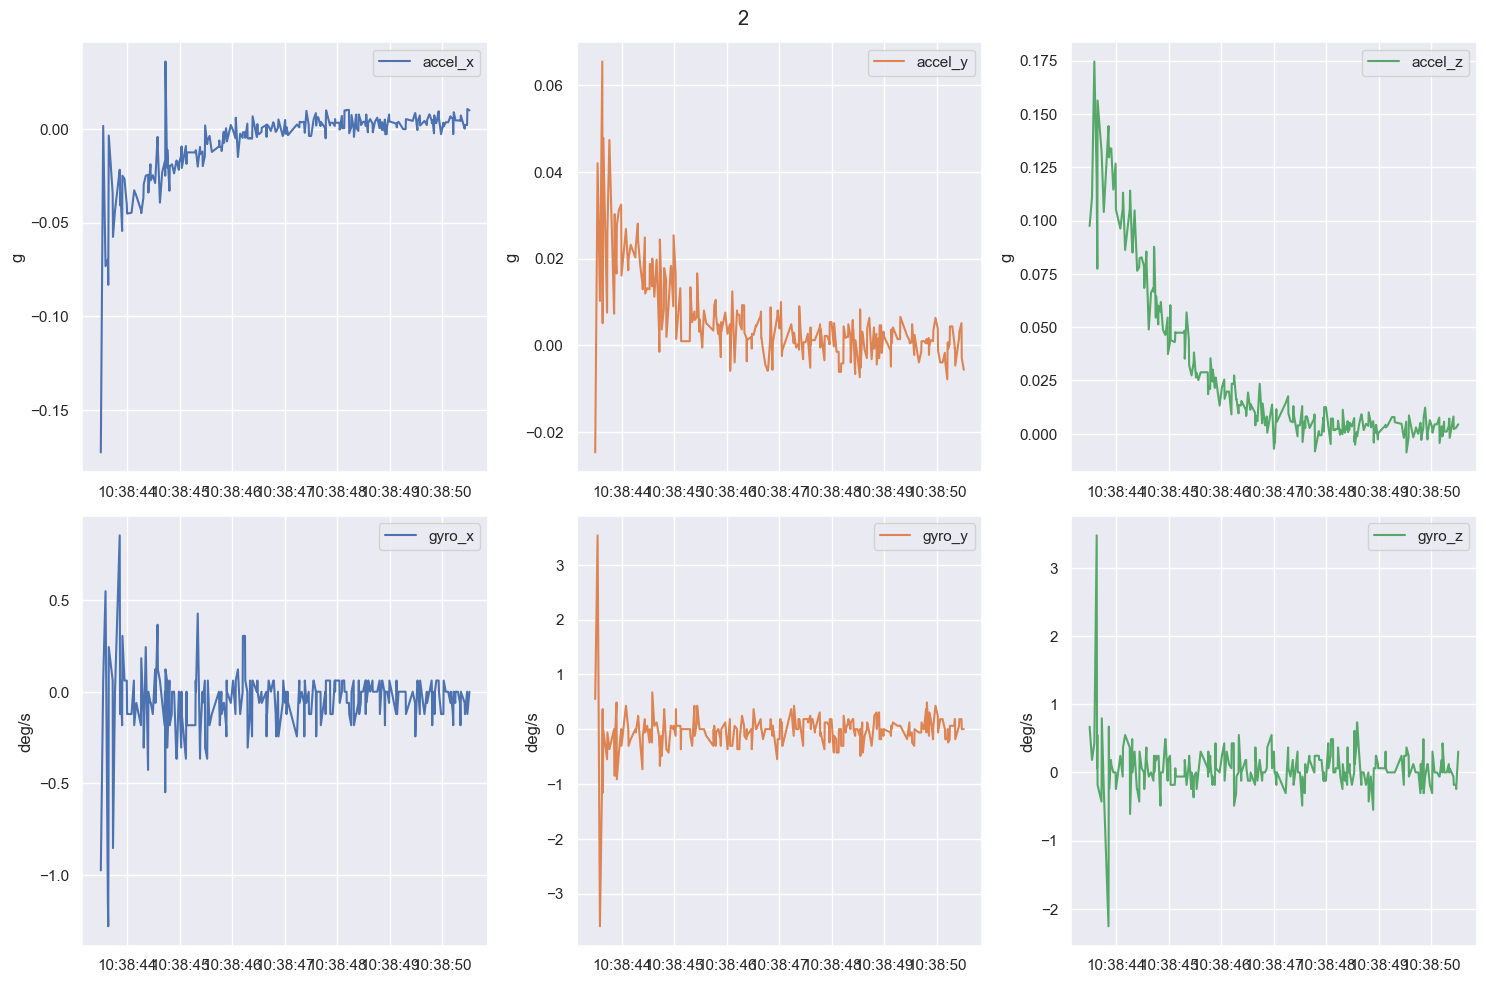

In [55]:
# plot reference data
plot_sensors_df(df_ref, "Reference", x_index='_time')

# plot all the actions

plot_sensors_df(df_zone0, 0, x_index='_time')
plot_sensors_df(df_zone1, 1, x_index='_time')
plot_sensors_df(df_zone2, 2, x_index='_time')
# plot_sensors_df(df_zone3, 3, x_index='_time')
# plot_sensors_df(df_zone4, 4, x_index='_time')
# plot_sensors_df(df_zone5, 5, x_index='_time')

## Data Manipulation

### Re-sampling

In [56]:
# resample the dataset to 0.01s
sampling_time = 0.01

# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']
df_ref_over = df_ref[columns].copy()
df_zone0_over = df_zone0[columns].copy()
df_zone1_over = df_zone1[columns].copy()
df_zone2_over = df_zone2[columns].copy()
df_zone3_over = df_zone3[columns].copy()
df_zone4_over = df_zone4[columns].copy()
df_zone5_over = df_zone5[columns].copy()

# resample the dataset
df_ref_over = df_ref_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone0_over = df_zone0_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone1_over = df_zone1_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone2_over = df_zone2_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone3_over = df_zone3_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone4_over = df_zone4_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_zone5_over = df_zone5_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

# get smallest length
min_window_length = min(len(df_zone0_over), len(df_zone1_over), len(df_zone2_over), len(df_zone3_over), len(df_zone4_over), len(df_zone5_over))
max_window_length = max(len(df_zone0_over), len(df_zone1_over), len(df_zone2_over), len(df_zone3_over), len(df_zone4_over), len(df_zone5_over))

print(f"Reference length: {len(df_ref_over)}")
print(f"Min window length: {min_window_length}")
print(f"Max window length: {max_window_length}")

Reference length: 15827
Min window length: 703
Max window length: 4469


Calculate magnitude of acceleration and angular velocity

In [57]:
sequences = [
    df_ref_over, df_zone0_over, df_zone1_over, df_zone2_over, df_zone3_over, df_zone4_over, df_zone5_over
]

# add a column with the magnitude of the acceleration and gyro
for i in range(len(sequences)):
    sequences[i]['accel_mag'] = np.sqrt(sequences[i]['accel_x']**2 + sequences[i]['accel_y']**2 + sequences[i]['accel_z']**2)
    sequences[i]['gyro_mag'] = np.sqrt(sequences[i]['gyro_x']**2 + sequences[i]['gyro_y']**2 + sequences[i]['gyro_z']**2)

### Spectrogram

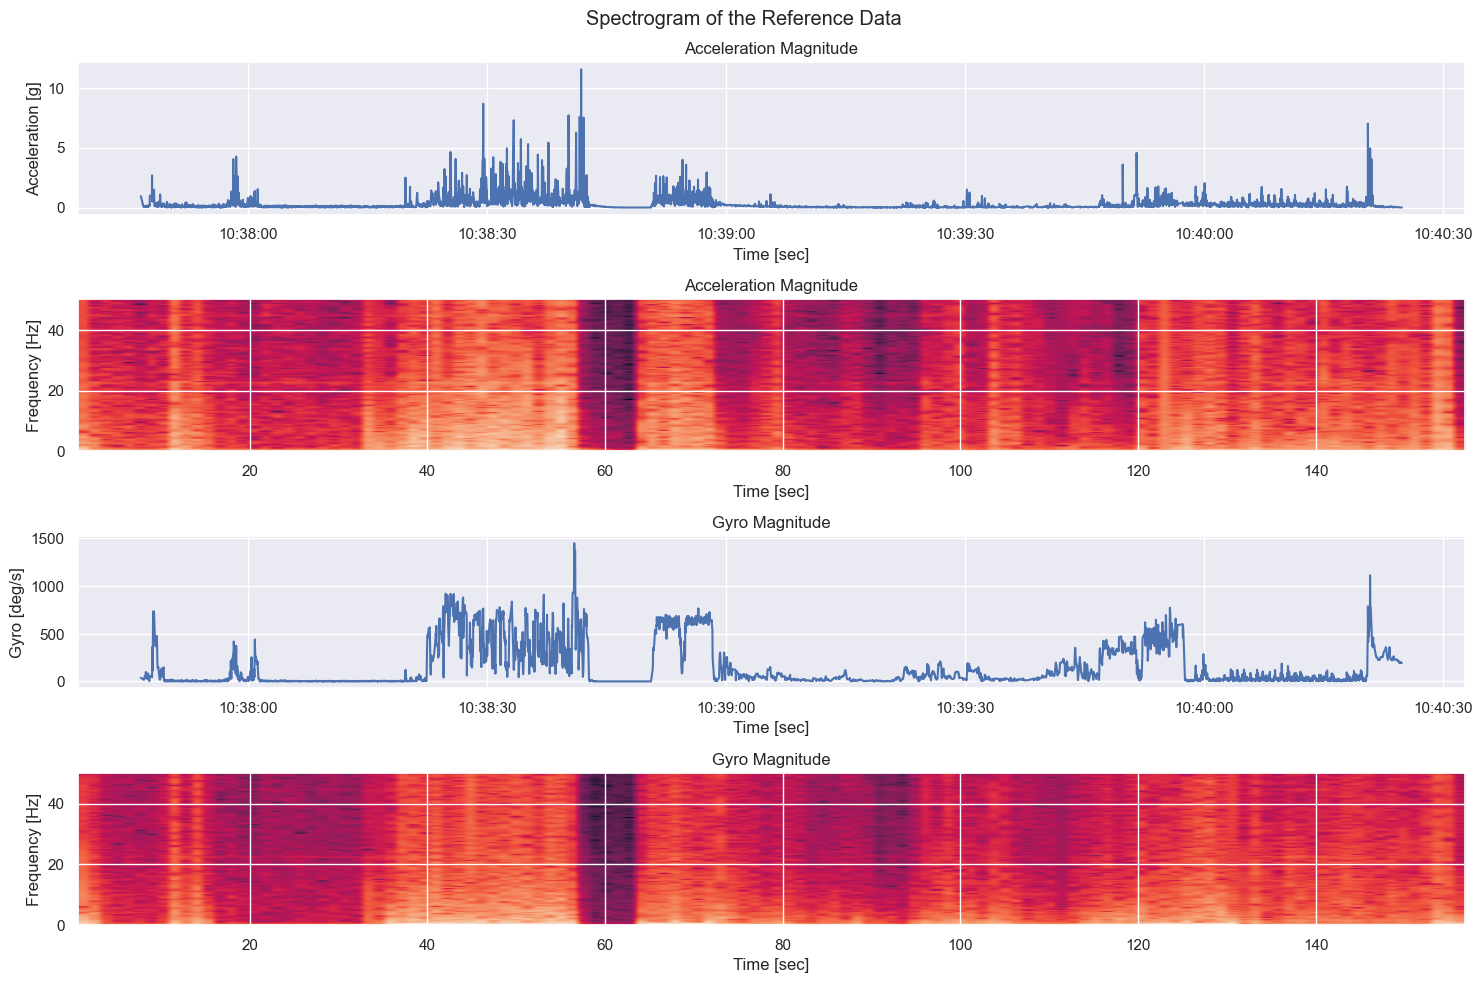

In [58]:
# calculate the spectrogram of the acceleration and gyro
fs = 1/sampling_time
f, t, Sxx_accel = spectrogram(df_ref_over['accel_mag'], fs)
f, t, Sxx_gyro = spectrogram(df_ref_over['gyro_mag'], fs)

# plot the signal, spectrogram of the acceleration and gyro in a 3x1 subplot
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Spectrogram of the Reference Data')

# plot the signal
axs[0].plot(df_ref_over['accel_mag'])
axs[0].set_ylabel('Acceleration [g]')
axs[0].set_xlabel('Time [sec]')
axs[0].set_title('Acceleration Magnitude')

# plot the spectrogram of the acceleration
# im = axs[0].pcolormesh(t, f, Sxx_accel, shading='gouraud')
im = axs[1].specgram(df_ref_over['accel_mag'], Fs=fs)
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[1].set_title('Acceleration Magnitude')
# fig.colorbar(im, ax=axs[0])

# plot the gyro
axs[2].plot(df_ref_over['gyro_mag'])
axs[2].set_ylabel('Gyro [deg/s]')
axs[2].set_xlabel('Time [sec]')
axs[2].set_title('Gyro Magnitude')

# plot the spectrogram of the gyro
# im = axs[3].pcolormesh(t, f, Sxx_gyro)
im = axs[3].specgram(df_ref_over['gyro_mag'], Fs=fs)
axs[3].set_ylabel('Frequency [Hz]')
axs[3].set_xlabel('Time [sec]')
axs[3].set_title('Gyro Magnitude')
# fig.colorbar(im, ax=axs[1])

# give more space between the subplots
fig.tight_layout(pad=1.0)
plt.show()



### Cross-correlation

In [59]:
# function to caldulate the 1d cross correlation
def crosscorrelation_1d(signal1, signal2, plot=True, title=""):
        
    # calculate the cross correlation
    corr = correlate(signal1, signal2, mode='full')
    # calculate the time lags
    lags = np.arange(1-len(signal1), len(signal2))

    # Find the lag with the maximum correlation
    max_corr_index = np.argmax(corr)
    max_corr_lag = lags[max_corr_index]

    # If max_corr_lag is positive, the second signal leads the reference signal
    if max_corr_lag > 0:
        match_sample_second = max_corr_lag
        match_sample_first = 0
    # If max_corr_lag is negative, the second signal lags the reference signal
    else:
        match_sample_second = 0
        match_sample_first = -max_corr_lag

    if plot:

        # drop _time index
        signal1 = signal1.reset_index(drop=True)
        signal2 = signal2.reset_index(drop=True)
        # Create the subplots
        fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 rows, 1 column

        # Plot the first signal
        axs[0].plot(signal1, label='First Signal', color='C0')
        axs[0].set_title('First Signal - ' + title)
        axs[0].set_xlabel('Samples')
        axs[0].set_ylabel('Magnitude')
        axs[0].grid(True)

        # Plot the second signal
        axs[1].plot(signal2, label='Second Signal - ' + title, color='C0')
        axs[1].set_title('Second Signal - ' + title)
        axs[1].set_xlabel('Samples')
        axs[1].set_ylabel('Magnitude')
        axs[1].grid(True)

        # Mark the points of maximum correlation on both signals
        axs[0].axvline(x=max_corr_index, color='r', linestyle='--', label='Maximum Correlation Lag')
        axs[1].axvline(x=match_sample_second, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Plot the cross-correlation
        axs[2].plot(lags, corr, label='Cross Correlation', color='C1')
        axs[2].set_title('Cross Correlation')
        axs[2].set_xlabel('Lag (Samples)')
        axs[2].set_ylabel('Cross Correlation')
        axs[2].grid(True)
        axs[2].axvline(x=max_corr_lag, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Add legends
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

    return corr, max_corr_lag, max_corr_index
    

In [60]:
# x axis sequences
corr_ref_zone0_accel, lag_ref_zone0_accel, max_corr_ref_zone0_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone0_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone0_gyro, lag_ref_zone0_gyro, max_corr_ref_zone0_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone0_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_zone1_accel, lag_ref_zone1_accel, max_corr_ref_zone1_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone1_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone1_gyro, lag_ref_zone1_gyro, max_corr_ref_zone1_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone1_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_zone2_accel, lag_ref_zone2_accel, max_corr_ref_zone2_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone2_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone2_gyro, lag_ref_zone2_gyro, max_corr_ref_zone2_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone2_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_zone3_accel, lag_ref_zone3_accel, max_corr_ref_zone3_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone3_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone3_gyro, lag_ref_zone3_gyro, max_corr_ref_zone3_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone3_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_zone4_accel, lag_ref_zone4_accel, max_corr_ref_zone4_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone4_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone4_gyro, lag_ref_zone4_gyro, max_corr_ref_zone4_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone4_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_zone5_accel, lag_ref_zone5_accel, max_corr_ref_zone5_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_zone5_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_zone5_gyro, lag_ref_zone5_gyro, max_corr_ref_zone5_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_zone5_over['gyro_mag'], plot=False, title="Gyro")

In [61]:
max_corr_indices_accel = [
    max_corr_ref_zone0_accel, max_corr_ref_zone1_accel, max_corr_ref_zone2_accel,
    max_corr_ref_zone3_accel, max_corr_ref_zone4_accel, max_corr_ref_zone5_accel
]

max_corr_indices_gyro = [
    max_corr_ref_zone0_gyro, max_corr_ref_zone1_gyro, max_corr_ref_zone2_gyro,
    max_corr_ref_zone3_gyro, max_corr_ref_zone4_gyro, max_corr_ref_zone5_gyro
]

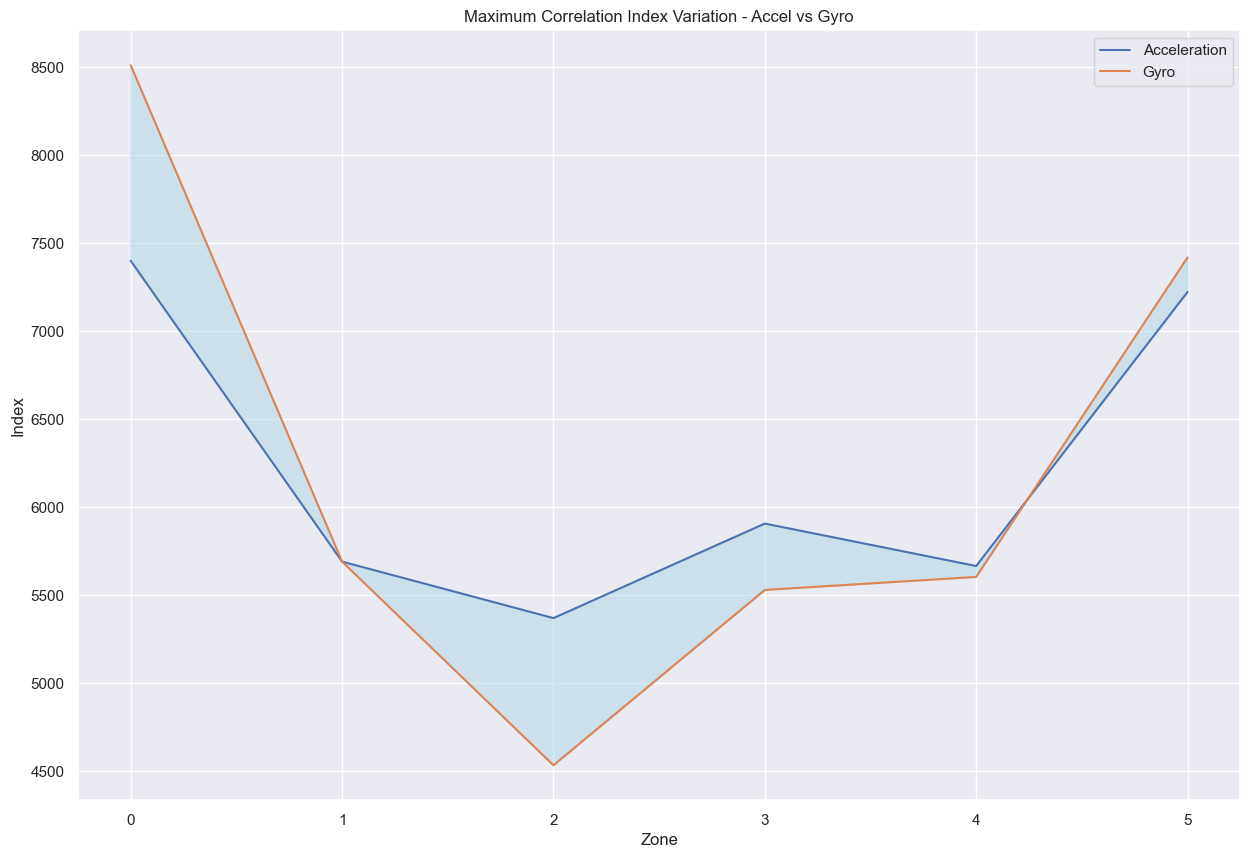

In [62]:
# plot the variation of the maximum correlation index for acceleration and gyro
plt.figure(figsize=(15, 10))
plt.plot(max_corr_indices_accel, label='Acceleration')
plt.plot(max_corr_indices_gyro, label='Gyro')
plt.fill_between(range(len(max_corr_indices_accel)), max_corr_indices_accel, max_corr_indices_gyro, color='lightblue', alpha=0.5)
plt.title('Maximum Correlation Index Variation - Accel vs Gyro')
plt.xlabel('Zone')
plt.ylabel('Index')
plt.legend()
plt.grid(True)
plt.show()


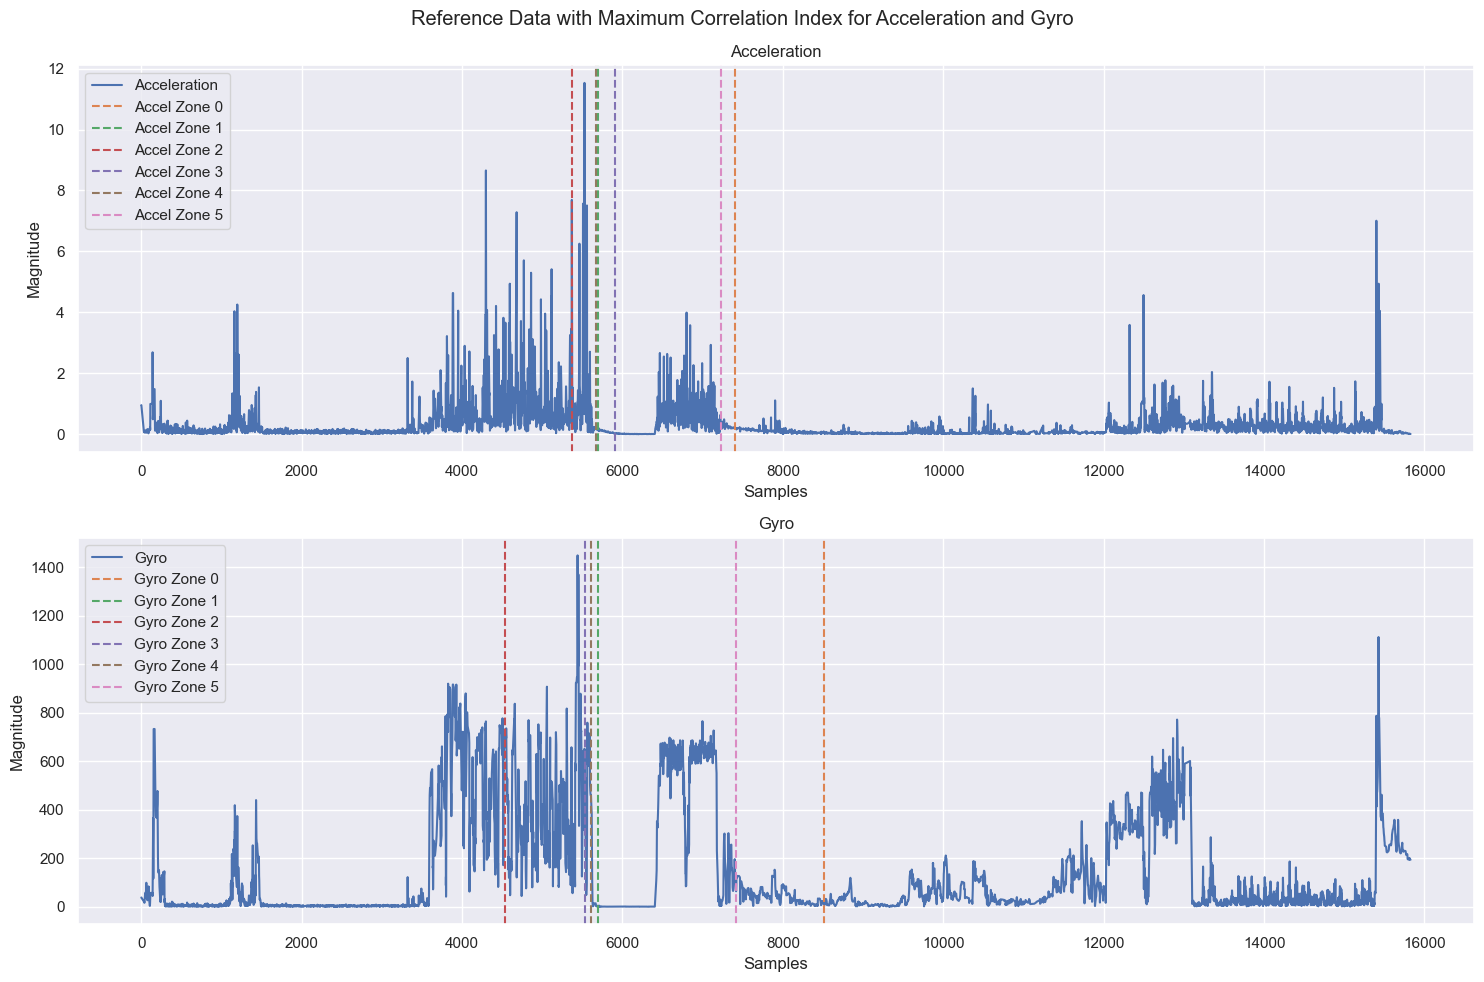

In [63]:
# plot the reference data with the maximum correlation index for acceleration and gyro for all the actions
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Reference Data with Maximum Correlation Index for Acceleration and Gyro')

signal = df_ref_over.copy()
signal = signal.reset_index(drop=True)

# plot the reference data with the maximum correlation index for acceleration
axs[0].plot(signal['accel_mag'], label='Acceleration')
axs[0].set_title('Acceleration')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)
for i in range(0, len(max_corr_indices_accel)):
    axs[0].axvline(x=max_corr_indices_accel[i], color=f'C{i+1}', linestyle='--', label=f'Accel Zone {i}')

# plot the reference data with the maximum correlation index for gyro
axs[1].plot(signal['gyro_mag'], label='Gyro')
axs[1].set_title('Gyro')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Magnitude')

axs[1].grid(True)
for i in range(0, len(max_corr_indices_gyro)):
    axs[1].axvline(x=max_corr_indices_gyro[i], color=f'C{i+1}', linestyle='--', label=f'Gyro Zone {i}')
# Add legends
axs[0].legend()
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

### FFT

##### Functions

In [64]:
def get_fft_peaks(df, sampling_time, title="", plot=False, window=0, shift=0):
    """Get the fft peaks of the dataframe

    Args:
        df (): pandas dataframe
        sampling_time (float): sampling time
        title (str, optional): title of the plot. Defaults to "".
        plot (bool, optional): plot the fft. Defaults to False.
        window (int, optional): number of samples to split the dataframe and calculate the fft on each window. Defaults to 0.
        shift (int, optional): number of samples to shift the window and recalculate the fft. Defaults to 0.

    Returns:
        data_struct: struct with fft values, frequency and peaks
    """
    
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    num_peaks = 5
    order_peaks = 8
    
    df_window = []
    index_window_pairs = []  # Initialize a list to store index-window pairs

    if window > 0:
        # get a new index before resampling
        df = df.reset_index(drop=True)

        # split the dataframe in windows of size window, every new window is shifted by shift from the last sample of the previous window
        for i in range(0, len(df), shift):
            # if the size of the window is less than window, add 0 paddings
            if i+window > len(df):
                diff = i+window - len(df)
                padded_window = df[i:].copy()
                padded_window = padded_window.reindex(range(diff), fill_value=0.0)
                # start the index from the last sample of the previous window
                last_index = df[i:].index[-1]
                padded_window.index = range(last_index+1, last_index+1+diff)
                # add the padded window to the list
                padded_window = pd.concat([df[i:], padded_window])
                
                # add the window to the list
                df_window.append(padded_window)
            else:
                # add the window to the list
                df_window.append(df[i:i+window])
            
            window_end = min(i + window, len(df))
            current_window = df[i:window_end]

            # Generate index-window pairs for the current window
            for idx in current_window.index:
                index_window_pairs.append([idx, i // shift])  # Divide by shift to get sequential window numbers
    else:
        df_window.append(df)
        for idx in df.index:
            index_window_pairs.append([idx, 0])  # If no windowing, all samples belong to window 0

    # Initialize a dictionary to aggregate window IDs by index
    index_to_windows = {}

    # Aggregate window IDs for each index
    for idx, window_id in index_window_pairs:
        if idx not in index_to_windows:
            index_to_windows[idx] = set()
        index_to_windows[idx].add(window_id)

    # Convert the dictionary to the desired list format
    index_windows_list = [list(window_ids) for idx, window_ids in index_to_windows.items()]
    
    # print("Number of windows: ", len(df_window))
    # print(df_window)     

    # create struct to return
    data_struct = {}

    for i in range(len(df_window)):
        # add a new key to the struct
        data_struct[i] = {}

    if plot:
        fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
        fig.suptitle("FFT with peaks " + title)
    
    for i, df in enumerate(df_window):
        # print("Window: ", i)
        # print(df)
        # variable to store the accel and gyro peak values
        accel_peak_values = []
        gyro_peak_values = []
        # variable to store the accel and gyro peak frequencies
        accel_peak_freq = []
        gyro_peak_freq = []

        for j, column in enumerate(columns):
            # get the fft
            fft_values = fft(df[column].values)
            # get the frequency
            freq = fftfreq(len(df[column].values), d=sampling_time)
            # get the peaks
            peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            while len(peaks) < num_peaks and order_peaks > 1:
                # reduce the order
                order_peaks = order_peaks - 1
                # get the peaks
                peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            
            # if there are less than num_peaks peaks, add 0 paddings
            if len(peaks) == 0:
                diff = num_peaks - len(peaks)
                padded_peaks = np.zeros(diff, dtype=int)
                # add the padded peaks to the peaks
                peaks = np.concatenate((peaks, padded_peaks))
            
            else:
                # take the top 5 peaks which are greater than 0
                peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
                # sort the peaks
                peaks.sort()            
            
            # update the struct
            data_struct[i][column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

            # add the peaks to the list
            if 'accel' in column:
                accel_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                accel_peak_freq.append(freq[peaks])
            else:
                gyro_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                gyro_peak_freq.append(freq[peaks])

            if plot:
                # plot the fft
                axs[j//3, j%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(j%3), label=column)
                # plot the peaks
                axs[j//3, j%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
                if window == 0:
                    axs[j//3, j%3].legend()

                # set the y label
                if 'accel' in column:
                    axs[j//3, j%3].set_ylabel('g')
                else:
                    axs[j//3, j%3].set_ylabel('deg/s')
        
        # concatenate the peaks
        accel_peak_values = np.concatenate(accel_peak_values)
        gyro_peak_values = np.concatenate(gyro_peak_values)
        accel_peak_freq = np.concatenate(accel_peak_freq)
        gyro_peak_freq = np.concatenate(gyro_peak_freq)
        # check if there are duplicated frequencies and remove them together with the values
        accel_peak_freq, index = np.unique(accel_peak_freq, return_index=True)
        accel_peak_values = accel_peak_values[index]
        gyro_peak_freq, index = np.unique(gyro_peak_freq, return_index=True)
        gyro_peak_values = gyro_peak_values[index]
        # sort the peaks
        accel_peak_values = accel_peak_values[np.argsort(accel_peak_freq)]
        gyro_peak_values = gyro_peak_values[np.argsort(gyro_peak_freq)]
        accel_peak_freq = accel_peak_freq[np.argsort(accel_peak_freq)]
        gyro_peak_freq = gyro_peak_freq[np.argsort(gyro_peak_freq)]

        # add the peaks to the struct
        data_struct[i]['accel_peaks'] = accel_peak_values
        data_struct[i]['accel_peaks_freq'] = accel_peak_freq
        data_struct[i]['gyro_peaks'] = gyro_peak_values
        data_struct[i]['gyro_peaks_freq'] = gyro_peak_freq

    if window > 0:
        return data_struct, index_windows_list
    else:
        return data_struct

In [65]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [66]:
def plot_peaks_combined(sensor_struct, title=""):

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    axs[0].stem(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', color='C0', alpha=0.5)
    axs[1].stem(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [67]:
# zip peaks and frequencies
def zip_peaks_freq(freq, peaks):
    return np.array(list(zip(freq, peaks)))

##### Code

In [68]:
df_ref_over

accel_x   accel_y   accel_z      gyro_x      gyro_y  \
_time                                                                           
2024-02-15 10:37:46.520  0.131836  0.018555 -0.944580    7.987805   26.463415   
2024-02-15 10:37:46.530  0.131836  0.018555 -0.944580    7.987805   26.463415   
2024-02-15 10:37:46.540  0.126758  0.015995 -0.916588    8.047038   25.869338   
2024-02-15 10:37:46.550  0.121680  0.013435 -0.888595    8.106272   25.275261   
2024-02-15 10:37:46.560  0.116602  0.010875 -0.860603    8.165505   24.681185   
...                           ...       ...       ...         ...         ...   
2024-02-15 10:40:24.740 -0.003662 -0.010498  0.000732  137.012195 -114.817073   
2024-02-15 10:40:24.750 -0.004089 -0.009766  0.000732  135.442073 -114.969512   
2024-02-15 10:40:24.760 -0.004517 -0.009033  0.000732  133.871951 -115.121951   
2024-02-15 10:40:24.770 -0.004944 -0.008301  0.000732  132.301829 -115.274390   
2024-02-15 10:40:24.780 -0.005371 -0.007568  0.000732  130.731707 -115.426829   

                            gyro_z    quat_x    quat_y    quat_z    quat_w  \
_time                                                                        
2024-02-15 10:37:46.520 -25.609756  0.000000  0.000000  0.000000  0.000000   
2024-02-15 10:37:46.530 -25.609756  0.000000  0.000000  0.000000  0.000000   
2024-02-15 10:37:46.540 -25.362369  0.003429  0.017429  0.017143  0.014286   
2024-02-15 10:37:46.550 -25.114983  0.006857  0.034857  0.034286  0.028571   
2024-02-15 10:37:46.560 -24.867596  0.010286  0.052286  0.051429  0.042857   
...                            ...       ...       ...       ...       ...   
2024-02-15 10:40:24.740 -78.170732 -0.250000 -0.520000  0.810000  0.100000   
2024-02-15 10:40:24.750 -79.725610 -0.247500 -0.517500  0.812500  0.100000   
2024-02-15 10:40:24.760 -81.280488 -0.245000 -0.515000  0.815000  0.100000   
2024-02-15 10:40:24.770 -82.835366 -0.242500 -0.512500  0.817500  0.100000   
2024-02-15 10:40:24.780 -84.390244 -0.240000 -0.510000  0.820000  0.100000   

                         accel_mag    gyro_mag  
_time                                           
2024-02-15 10:37:46.520   0.953916   37.682581  
2024-02-15 10:37:46.530   0.953916   37.682581  
2024-02-15 10:37:46.540   0.925449   37.111013  
2024-02-15 10:37:46.550   0.896988   36.541932  
2024-02-15 10:37:46.560   0.868534   35.975459  
...                            ...         ...  
2024-02-15 10:40:24.740   0.011143  195.105011  
2024-02-15 10:40:24.750   0.010613  194.727288  
2024-02-15 10:40:24.760   0.010126  194.374074  
2024-02-15 10:40:24.770   0.009689  194.045502  
2024-02-15 10:40:24.780   0.009309  193.741698  

[15827 rows x 12 columns]

In [69]:
ref_fft, window_ids_list = get_fft_peaks(df_ref_over, sampling_time, title="Reference", plot=False, window=2000, shift=100)
zone0_fft = get_fft_peaks(df_zone0_over, sampling_time, title="Zone 0", plot=False)
zone1_fft = get_fft_peaks(df_zone1_over, sampling_time, title="Zone 1", plot=False)
zone2_fft = get_fft_peaks(df_zone2_over, sampling_time, title="Zone 2", plot=False)
zone3_fft = get_fft_peaks(df_zone3_over, sampling_time, title="Zone 3", plot=False)
zone4_fft = get_fft_peaks(df_zone4_over, sampling_time, title="Zone 4", plot=False)
zone5_fft = get_fft_peaks(df_zone5_over, sampling_time, title="Zone 5", plot=False)

In [70]:
# append the window ids to the reference dataframe
df_ref_over['window_id'] = window_ids_list

In [71]:
df_ref_over

accel_x   accel_y   accel_z      gyro_x      gyro_y  \
_time                                                                           
2024-02-15 10:37:46.520  0.131836  0.018555 -0.944580    7.987805   26.463415   
2024-02-15 10:37:46.530  0.131836  0.018555 -0.944580    7.987805   26.463415   
2024-02-15 10:37:46.540  0.126758  0.015995 -0.916588    8.047038   25.869338   
2024-02-15 10:37:46.550  0.121680  0.013435 -0.888595    8.106272   25.275261   
2024-02-15 10:37:46.560  0.116602  0.010875 -0.860603    8.165505   24.681185   
...                           ...       ...       ...         ...         ...   
2024-02-15 10:40:24.740 -0.003662 -0.010498  0.000732  137.012195 -114.817073   
2024-02-15 10:40:24.750 -0.004089 -0.009766  0.000732  135.442073 -114.969512   
2024-02-15 10:40:24.760 -0.004517 -0.009033  0.000732  133.871951 -115.121951   
2024-02-15 10:40:24.770 -0.004944 -0.008301  0.000732  132.301829 -115.274390   
2024-02-15 10:40:24.780 -0.005371 -0.007568  0.000732  130.731707 -115.426829   

                            gyro_z    quat_x    quat_y    quat_z    quat_w  \
_time                                                                        
2024-02-15 10:37:46.520 -25.609756  0.000000  0.000000  0.000000  0.000000   
2024-02-15 10:37:46.530 -25.609756  0.000000  0.000000  0.000000  0.000000   
2024-02-15 10:37:46.540 -25.362369  0.003429  0.017429  0.017143  0.014286   
2024-02-15 10:37:46.550 -25.114983  0.006857  0.034857  0.034286  0.028571   
2024-02-15 10:37:46.560 -24.867596  0.010286  0.052286  0.051429  0.042857   
...                            ...       ...       ...       ...       ...   
2024-02-15 10:40:24.740 -78.170732 -0.250000 -0.520000  0.810000  0.100000   
2024-02-15 10:40:24.750 -79.725610 -0.247500 -0.517500  0.812500  0.100000   
2024-02-15 10:40:24.760 -81.280488 -0.245000 -0.515000  0.815000  0.100000   
2024-02-15 10:40:24.770 -82.835366 -0.242500 -0.512500  0.817500  0.100000   
2024-02-15 10:40:24.780 -84.390244 -0.240000 -0.510000  0.820000  0.100000   

                         accel_mag    gyro_mag  \
_time                                            
2024-02-15 10:37:46.520   0.953916   37.682581   
2024-02-15 10:37:46.530   0.953916   37.682581   
2024-02-15 10:37:46.540   0.925449   37.111013   
2024-02-15 10:37:46.550   0.896988   36.541932   
2024-02-15 10:37:46.560   0.868534   35.975459   
...                            ...         ...   
2024-02-15 10:40:24.740   0.011143  195.105011   
2024-02-15 10:40:24.750   0.010613  194.727288   
2024-02-15 10:40:24.760   0.010126  194.374074   
2024-02-15 10:40:24.770   0.009689  194.045502   
2024-02-15 10:40:24.780   0.009309  193.741698   

                                                                 window_id  
_time                                                                       
2024-02-15 10:37:46.520                                                [0]  
2024-02-15 10:37:46.530                                                [0]  
2024-02-15 10:37:46.540                                                [0]  
2024-02-15 10:37:46.550                                                [0]  
2024-02-15 10:37:46.560                                                [0]  
...                                                                    ...  
2024-02-15 10:40:24.740  [139, 140, 141, 142, 143, 144, 145, 146, 147, ...  
2024-02-15 10:40:24.750  [139, 140, 141, 142, 143, 144, 145, 146, 147, ...  
2024-02-15 10:40:24.760  [139, 140, 141, 142, 143, 144, 145, 146, 147, ...  
2024-02-15 10:40:24.770  [139, 140, 141, 142, 143, 144, 145, 146, 147, ...  
2024-02-15 10:40:24.780  [139, 140, 141, 142, 143, 144, 145, 146, 147, ...  

[15827 rows x 13 columns]

In [73]:
plot_stem_peaks(ref_fft[400], title="Reference")
# plot_stem_peaks(zone0_fft[0], title="Zone 0")
# plot_stem_peaks(zone1_fft[0], title="Zone 1")
# plot_stem_peaks(zone2_fft[0], title="Zone 2")
plot_stem_peaks(zone3_fft[0], title="Zone 3")
# plot_stem_peaks(zone4_fft[0], title="Zone 4")
# plot_stem_peaks(zone5_fft[0], title="Zone 5")

KeyError: 400

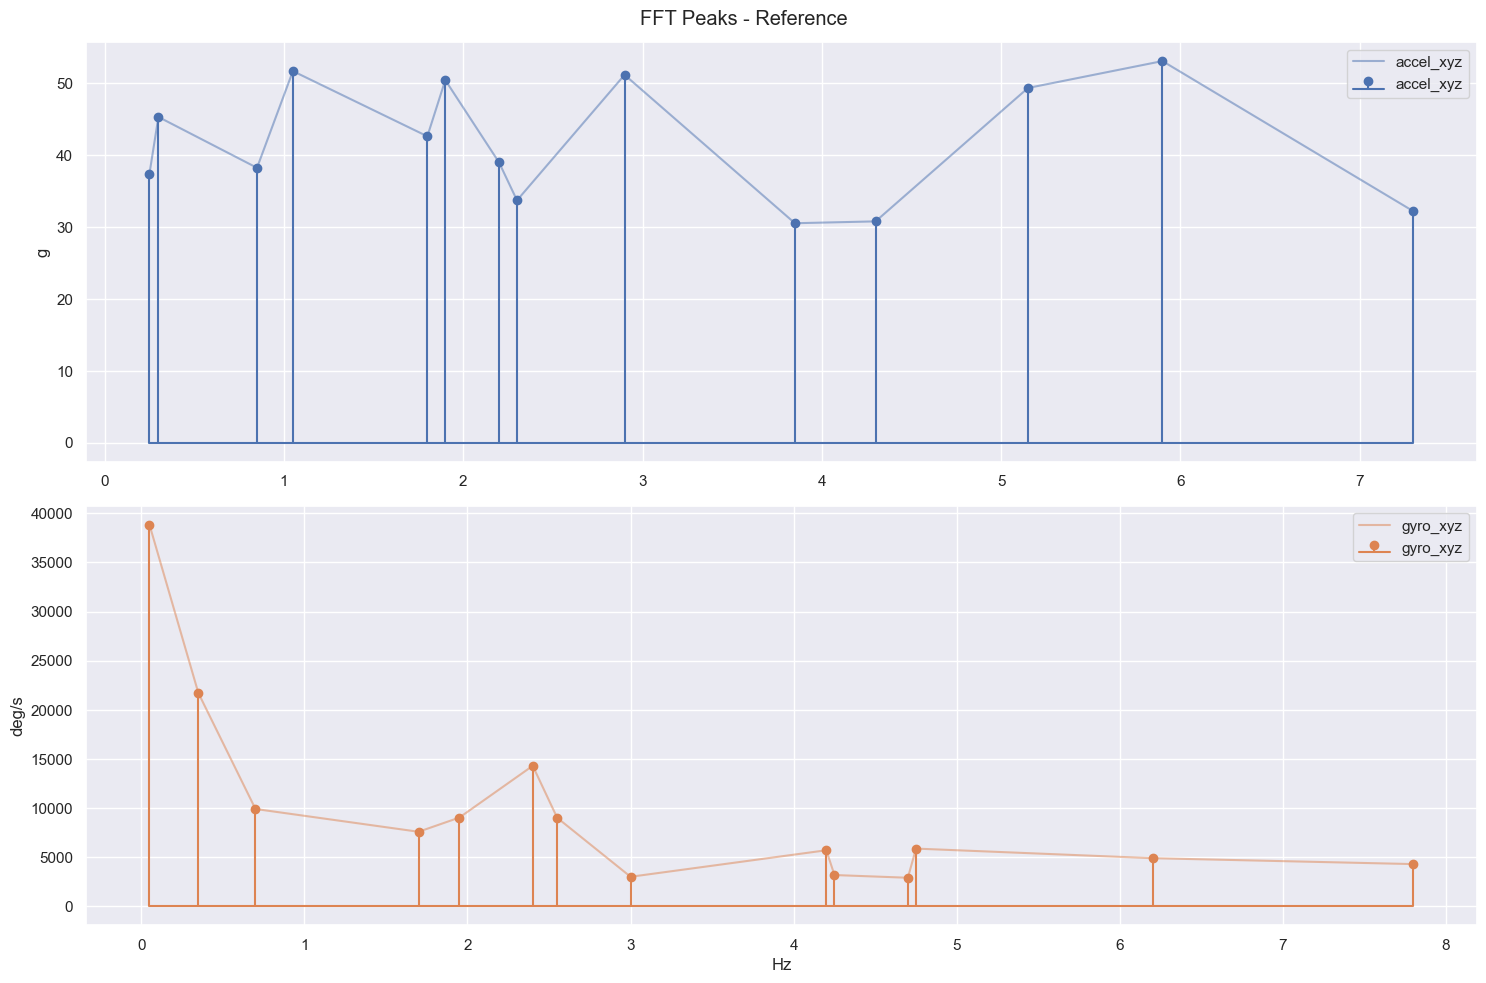

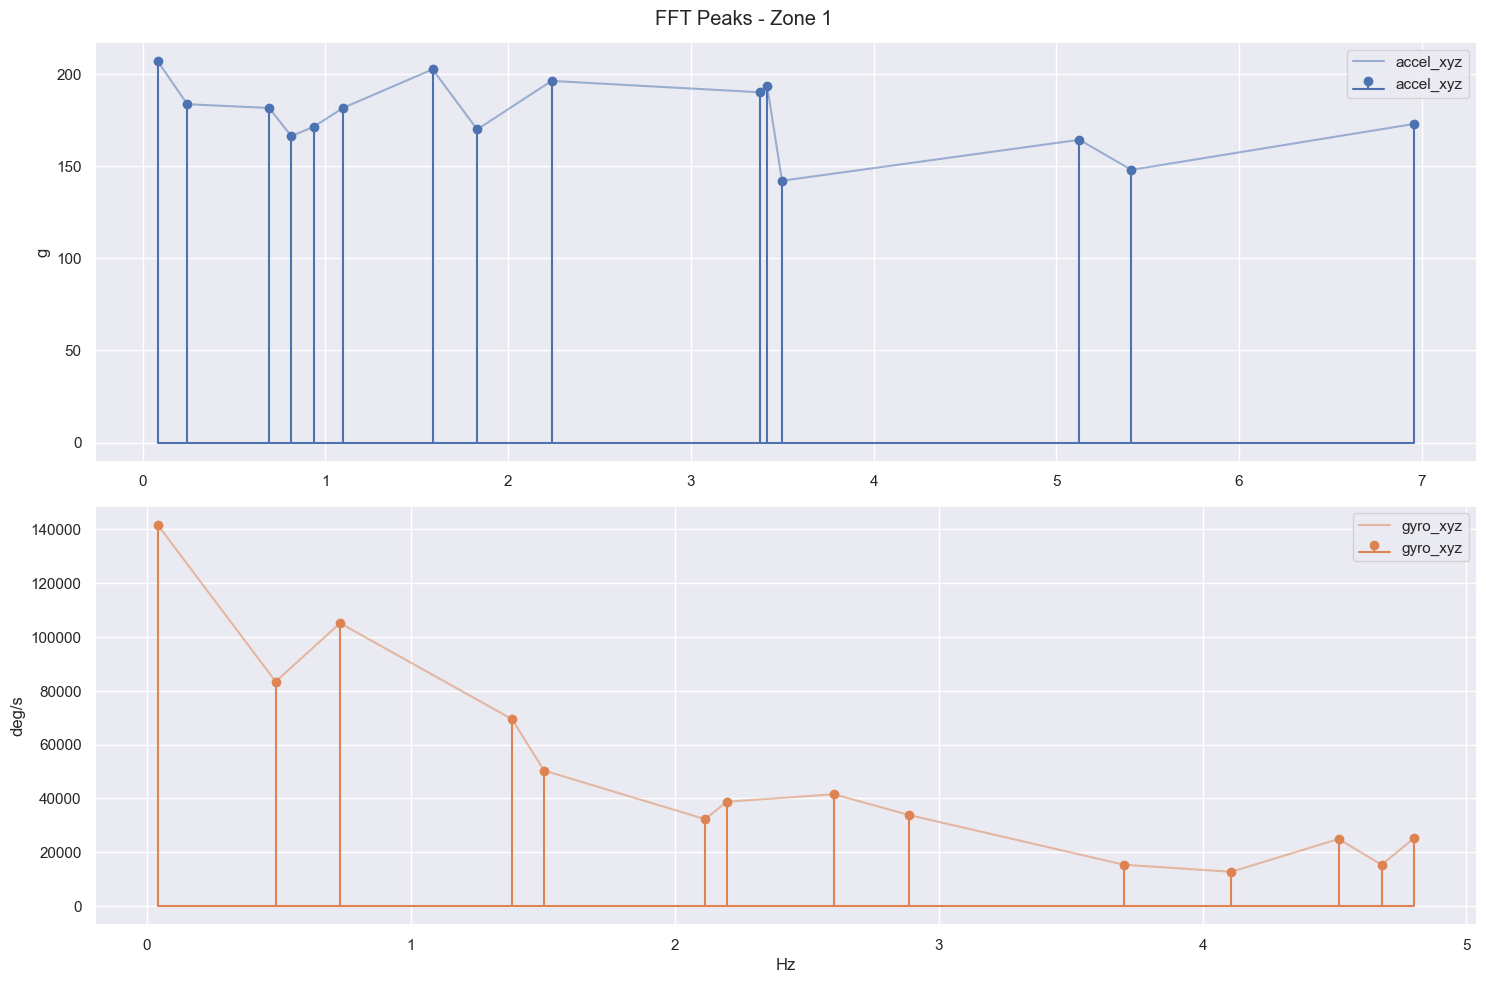

In [75]:
plot_peaks_combined(ref_fft[0], title="Reference")
# plot_peaks_combined(zone0_fft[0], title="Zone 0")
plot_peaks_combined(zone1_fft[0], title="Zone 1")
# plot_peaks_combined(zone2_fft[0], title="Zone 2")
# plot_peaks_combined(zone3_fft[0], title="Zone 3")
# plot_peaks_combined(zone4_fft[0], title="Zone 4")
# plot_peaks_combined(zone5_fft[0], title="Zone 5")

In [76]:
accel_zone0_zip = zip_peaks_freq(zone0_fft[0]['accel_peaks_freq'], zone0_fft[0]['accel_peaks'])
gyro_zone0_zip = zip_peaks_freq(zone0_fft[0]['gyro_peaks_freq'], zone0_fft[0]['gyro_peaks'])
accel_zone1_zip = zip_peaks_freq(zone1_fft[0]['accel_peaks_freq'], zone1_fft[0]['accel_peaks'])
gyro_zone1_zip = zip_peaks_freq(zone1_fft[0]['gyro_peaks_freq'], zone1_fft[0]['gyro_peaks'])
accel_zone2_zip = zip_peaks_freq(zone2_fft[0]['accel_peaks_freq'], zone2_fft[0]['accel_peaks'])
gyro_zone2_zip = zip_peaks_freq(zone2_fft[0]['gyro_peaks_freq'], zone2_fft[0]['gyro_peaks'])
accel_zone3_zip = zip_peaks_freq(zone3_fft[0]['accel_peaks_freq'], zone3_fft[0]['accel_peaks'])
gyro_zone3_zip = zip_peaks_freq(zone3_fft[0]['gyro_peaks_freq'], zone3_fft[0]['gyro_peaks'])
accel_zone4_zip = zip_peaks_freq(zone4_fft[0]['accel_peaks_freq'], zone4_fft[0]['accel_peaks'])
gyro_zone4_zip = zip_peaks_freq(zone4_fft[0]['gyro_peaks_freq'], zone4_fft[0]['gyro_peaks'])
accel_zone5_zip = zip_peaks_freq(zone5_fft[0]['accel_peaks_freq'], zone5_fft[0]['accel_peaks'])
gyro_zone5_zip = zip_peaks_freq(zone5_fft[0]['gyro_peaks_freq'], zone5_fft[0]['gyro_peaks'])

sequences_accel = [
    accel_zone0_zip, accel_zone1_zip, accel_zone2_zip, accel_zone3_zip, accel_zone4_zip, accel_zone5_zip
]

sequences_gyro = [
    gyro_zone0_zip, gyro_zone1_zip, gyro_zone2_zip, gyro_zone3_zip, gyro_zone4_zip, gyro_zone5_zip
]

## Data Classification

### Dynamic Time Warping

##### Functions

##### Code

DTW Univariate Distance:  36.42411163202528
DTW Multivariate Distance:  36.5865946724508
DTW Multivariate Normalized Distance:  2.277709999963191


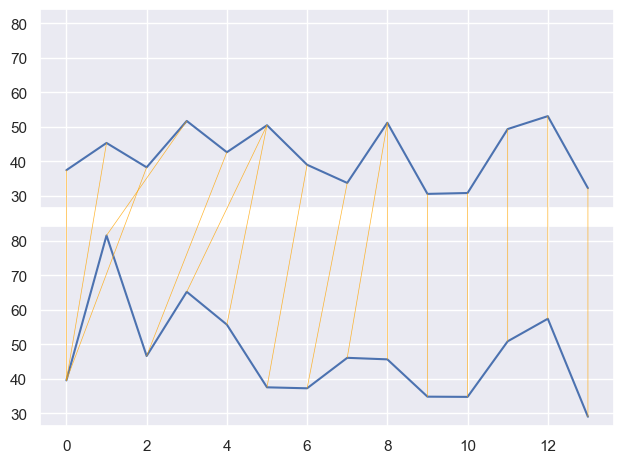

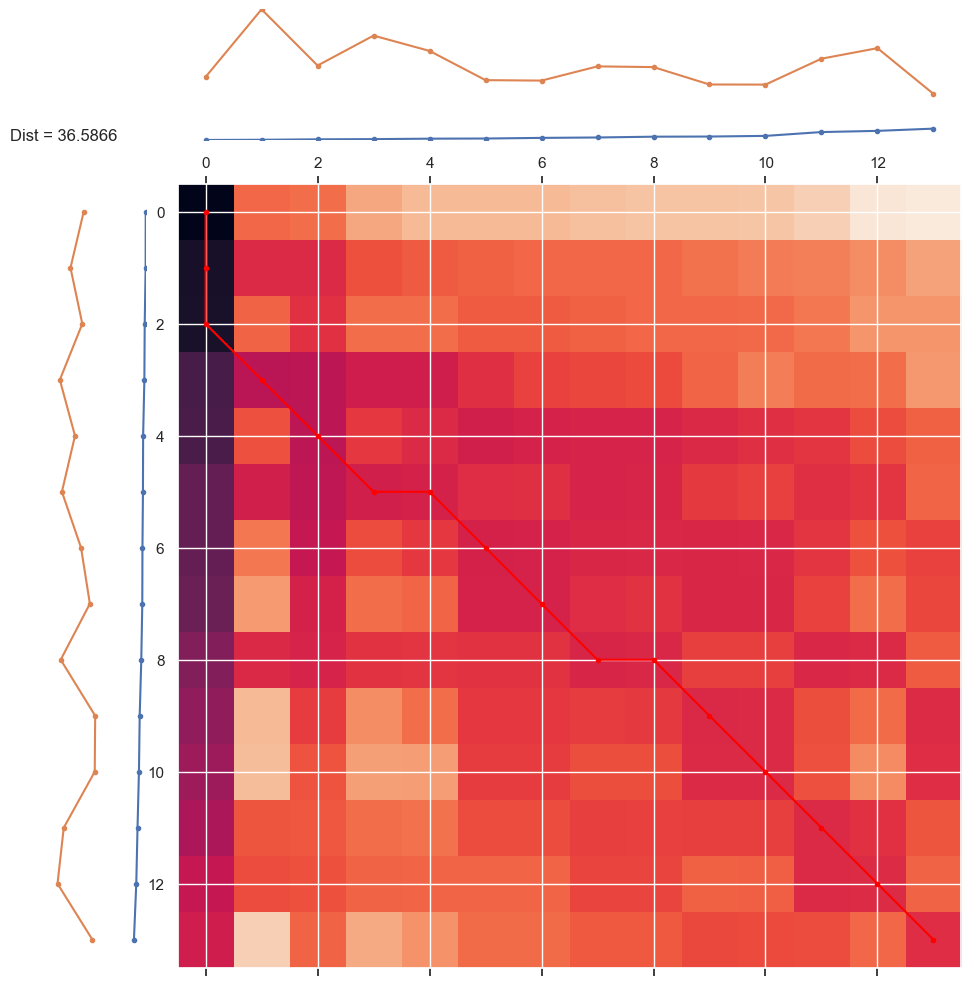

In [77]:
# Calculate the DTW distance between the two sequences
distance = dtw_ndim.distance(ref_fft[0]['accel_peaks'], zone0_fft[0]['accel_peaks'])
distance_zip = dtw_ndim.distance(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_zone0_zip)
print("DTW Univariate Distance: ", distance)
print("DTW Multivariate Distance: ", distance_zip)

# plot the univariate warp path
single_path = dtw.warping_path(ref_fft[0]['accel_peaks'], zone0_fft[0]['accel_peaks'])
dtwvis.plot_warping(ref_fft[0]['accel_peaks'], zone0_fft[0]['accel_peaks'], single_path)

# plot the cost matrix and the best path
d, paths = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_zone0_zip)
best_path = dtw.best_path(paths)

dtwvis.plot_warpingpaths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_zone0_zip, paths, best_path)

# normalize the score by dividing the last value of the best path by the length of the best path
score = paths[best_path[-1][0], best_path[-1][1]] / len(best_path)
print("DTW Multivariate Normalized Distance: ", score)

In [78]:
# calculate the DTW distance between the reference and all the other sequences

best_scores = []
for i in range(len(ref_fft)):

    distances = []
    for j in range(len(sequences_accel)):
        d_accel, paths_accel = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['accel_peaks_freq'], ref_fft[i]['accel_peaks']), sequences_accel[j])
        d_gyro, paths_gyro = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['gyro_peaks_freq'], ref_fft[i]['gyro_peaks']), sequences_gyro[j])
        best_path_accel = dtw.best_path(paths_accel)
        best_path_gyro = dtw.best_path(paths_gyro)
        if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
            score = 99999999
        else:

            score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
            score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
            score = score_accel + score_gyro
            # score = d_accel + d_gyro
        distances.append(score)
    # print(distances)
    best_score = [min(distances), distances.index(min(distances))]
    # print(f"Best score: {best_score[0]} with sequence {best_score[1]}")

    best_scores.append(best_score)

print(f"Lenght scores: {len(best_scores)} - Best scores: {best_scores}")


Lenght scores: 159 - Best scores: [[703.3083774107918, 0], [785.6640664596724, 4], [535.5030000152616, 4], [534.6993318178488, 4], [507.2392027320154, 4], [528.5591826599286, 4], [523.6254849595801, 4], [534.5590174854365, 4], [530.9625338942975, 4], [534.5934240008813, 4], [544.4347058518025, 4], [559.7710506112671, 4], [888.5177429804002, 4], [744.9356578030494, 2], [657.511064892415, 2], [213.09745305754404, 2], [704.394359850395, 2], [783.0190017322274, 4], [946.6485301850726, 0], [1003.0827094166737, 3], [797.5252498570329, 3], [790.3146039379501, 3], [1469.3383288895668, 3], [2296.078111029245, 3], [3491.0999981284795, 1], [2011.939955951245, 1], [3070.372696081771, 1], [4248.4773302145595, 1], [5139.990991710587, 1], [3122.8549410301644, 1], [2620.461200762352, 3], [2668.100926850328, 1], [2831.6625140534316, 1], [3100.9011119308016, 1], [2559.506911633558, 1], [1950.7713643388252, 1], [1571.223349788627, 1], [1476.9621598672768, 1], [2263.1893181853343, 1], [2778.537036919603, 

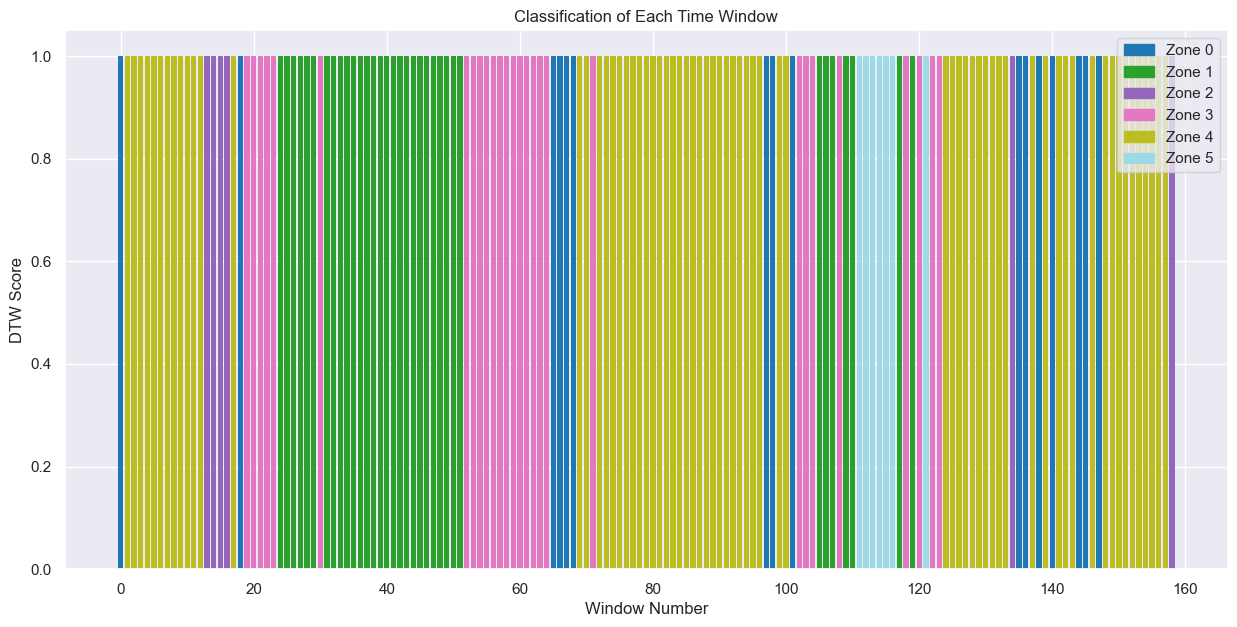

In [79]:
classes_names = [
    'Zone 0', 'Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'
]

# Extract classifications from best_scores
classifications = [item[1] for item in best_scores]

# Create a dictionary mapping window ID to classification
window_to_classification = {i: class_id for i, class_id in enumerate(classifications)}

# Define a function to map window IDs to classifications
def get_classifications(window_ids):
    return [window_to_classification.get(window_id) for window_id in window_ids]

# Apply the function to the 'window_id' column to create the 'infer_classes' column
df_ref_over['infer_classes'] = df_ref_over['window_id'].apply(get_classifications)

# Generate a unique color for each classification
unique_classifications = list(set(classifications))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classifications)))  # Using 'tab20' for more distinct colors
color_map = dict(zip(unique_classifications, colors))

# Plotting the histogram with height of 1.0 for each bar
plt.figure(figsize=(15, 7))
for i, classification in enumerate(classifications):
    plt.bar(i, 1.0, color=color_map[classification], edgecolor='None')

# Creating the legend
legend_handles = [mpatches.Patch(color=color_map[cls], label=classes_names[cls]) for cls in unique_classifications]
plt.legend(handles=legend_handles)

# Setting up the axes and labels
plt.xlabel("Window Number")
plt.ylabel("DTW Score")
plt.title("Classification of Each Time Window")
# plt.xticks(range(len(scores)))  # Set x-ticks to be the window numbers

plt.show()


c:\Users\MegaN\Desktop\Thesis\SmartApple-Thesis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


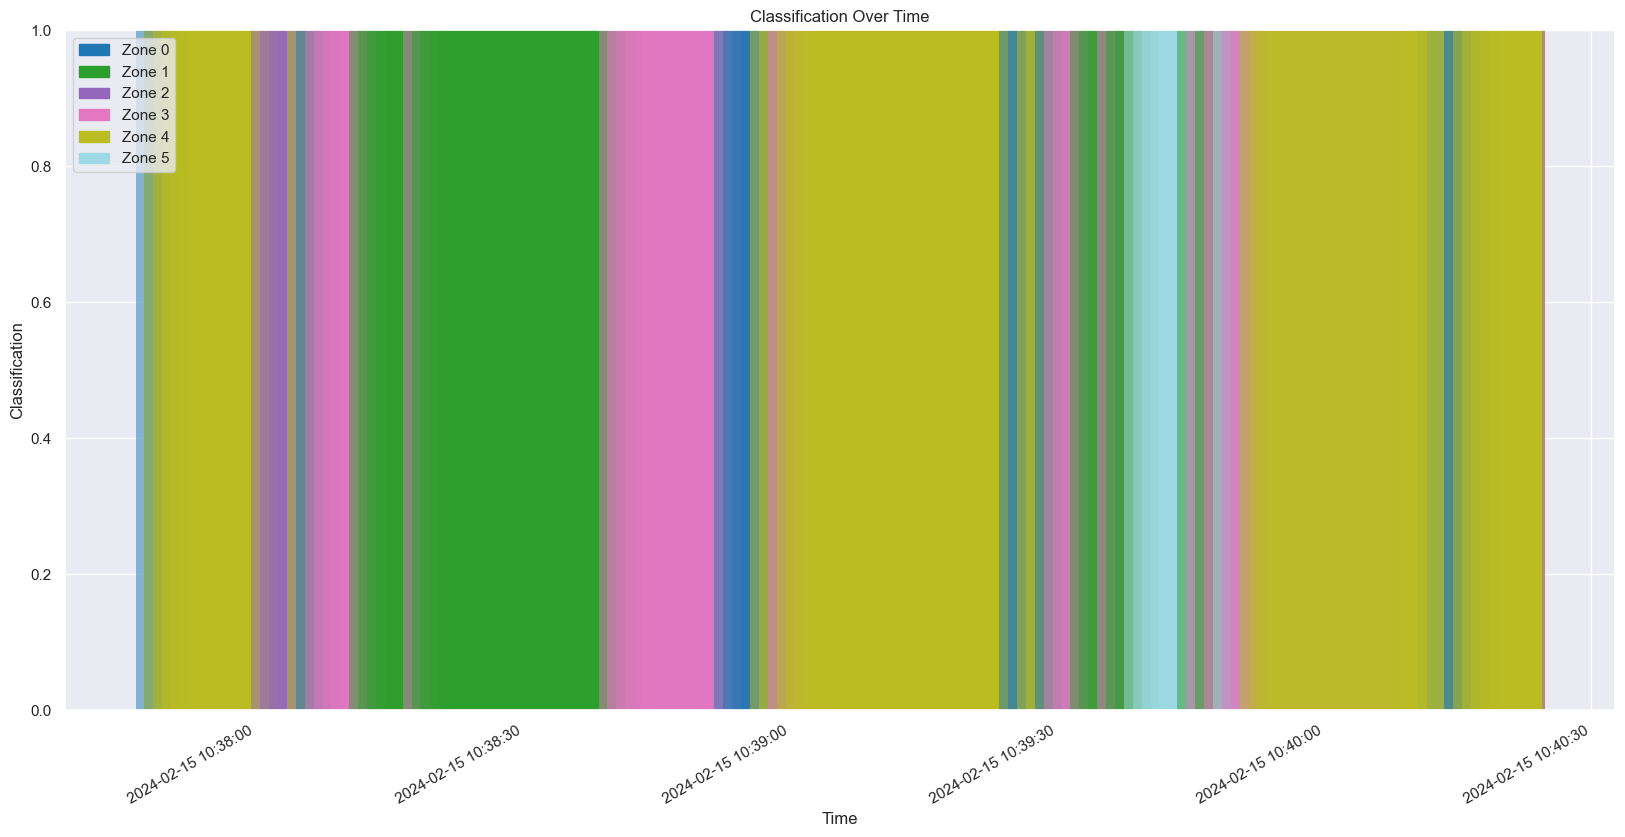

In [80]:
# Create a new DataFrame for plotting purposes
plot_df = pd.DataFrame(index=df_ref_over.index)

# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color for each classification
colors = plt.cm.tab20(np.linspace(0, 1, len(classes_names)))

# Plot a span for each window
for window_id, times in window_times.items():
    # Get the classifications for this window
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    for class_id in class_ids:
        class_name = classes_names[class_id]
        color = colors[class_id]
        plt.axvspan(times[0], times[1], facecolor=color, alpha=0.5, label=class_name, edgecolor='None')

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - we create a patch for each class
handles = [plt.Rectangle((0,0),1,1, color=colors[class_id], label=class_name) for class_id, class_name in enumerate(classes_names)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Classification Over Time")

plt.grid(True)

plt.show()


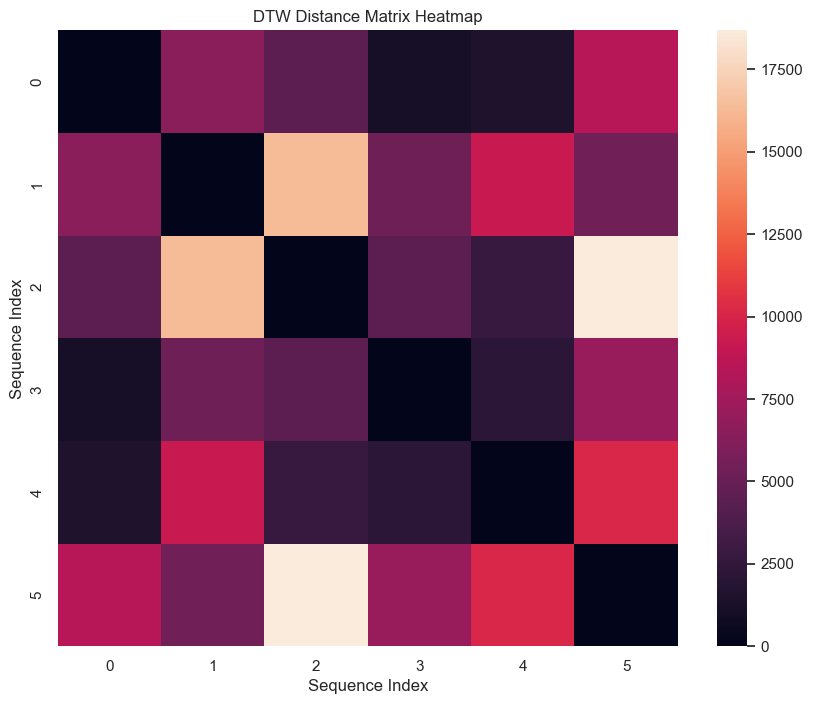

In [81]:

# Initialize a 12x12 matrix of zeros for the distances
distance_matrix = np.zeros((len(sequences_accel), len(sequences_accel)))

# Calculate the DTW distance between each pair of sequences
for i in range(len(sequences_accel)):
    for j in range(len(sequences_accel)):
        if i != j:  # No need to calculate when i == j since the distance is zero
            d_accel, paths_accel = dtw_ndim.warping_paths(sequences_accel[i], sequences_accel[j])
            d_gyro, paths_gyro = dtw_ndim.warping_paths(sequences_gyro[i], sequences_gyro[j])
            best_path_accel = dtw.best_path(paths_accel)
            best_path_gyro = dtw.best_path(paths_gyro)
            if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
                score = 99999999
            else:

                score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
                score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
                score = score_accel + score_gyro

            distance_matrix[i, j] = score

# Now, create a heatmap from the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f")
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.show()

## K-means Clustering

In [85]:
# packet id for the oversampled data
packet_id_over = np.arange(0, len(df_ref_over), 1)
# add it to the dataframe
df_ref_over['packet_id'] = packet_id_over

# Selecting the features for clustering
data = df_ref_over[['accel_mag', 'gyro_mag', 'packet_id']].values

num_zones = 6

# Compute K-means clustering
centroids, distortion = kmeans(data, num_zones)

# Assign each sample to a cluster
idx, _ = vq(data, centroids)

# Add the cluster information to the original dataframe
df_ref_over['cluster'] = idx

# print the lenght of the clusters
# for i in range(num_zones):
#     print(f"Cluster {i}: {len(df_ref_over[df_ref_over['cluster'] == i])}")


In [86]:
# Create a new column 'infer_zones' that increments each time the 'cluster' value changes
df_ref_over['infer_zones'] = (df_ref_over['cluster'] != df_ref_over['cluster'].shift()).cumsum()

# Adjust 'infer_zones' to start from zero
df_ref_over['infer_zones'] -= 1

# Display the DataFrame to verify the results
# print(df_ref_over[['cluster', 'infer_zones']])

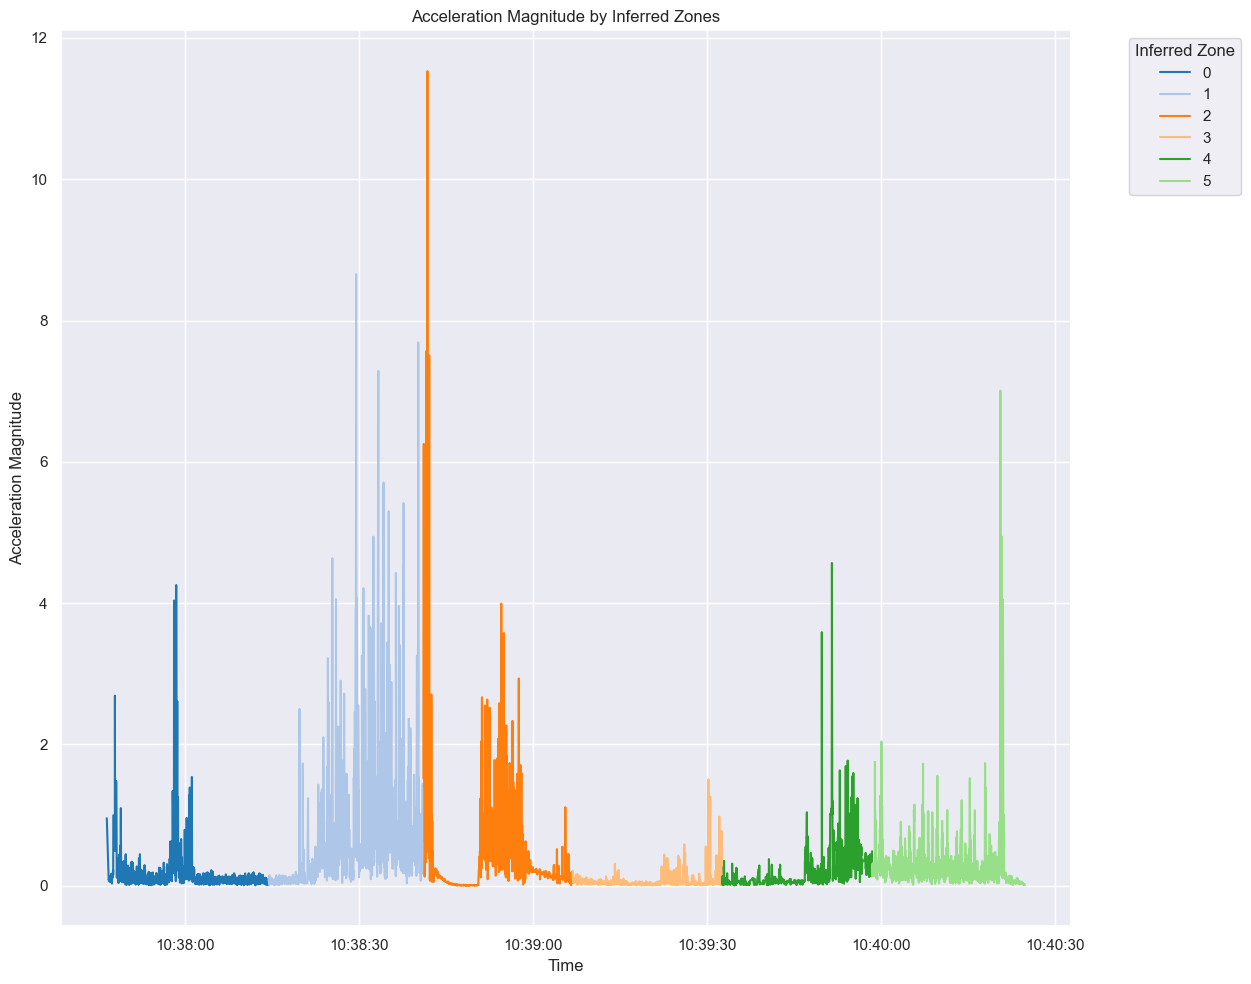

In [87]:
plt.figure(figsize=(15, 10))

# Use seaborn to create a line plot with different colors for each 'infer_zones' value
sns.lineplot(data=df_ref_over, x='_time', y='accel_mag', hue='infer_zones', palette='tab20', legend='full')

# Beautify the plot with titles and labels
plt.title('Acceleration Magnitude by Inferred Zones')
plt.xlabel('Time')
plt.ylabel('Acceleration Magnitude')

# Adjust legend
plt.legend(title='Inferred Zone', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure the plot is displayed properly with the legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

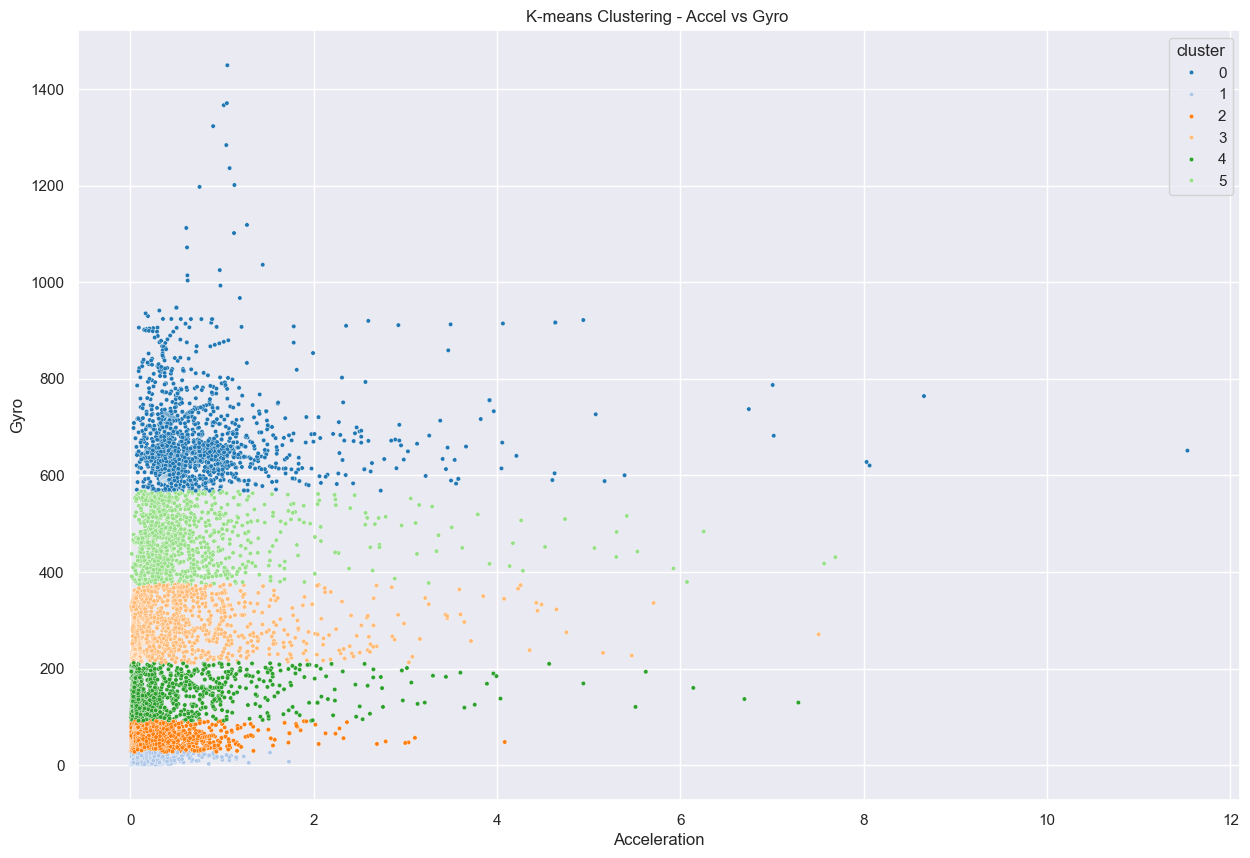

In [90]:
# Selecting the features for clustering
data = df_ref_over[['accel_mag', 'gyro_mag']].values

# Compute K-means clustering
centroids, distortion = kmeans(data, 6)

# Assign each sample to a cluster
idx, _ = vq(data, centroids)

# Add the cluster information to the original dataframe
df_ref_over['cluster'] = idx

# plot the clusters
plt.figure(figsize=(15, 10))
sns.scatterplot(x='accel_mag', y='gyro_mag', hue='cluster', data=df_ref_over, palette='tab20', s=10)
plt.title('K-means Clustering - Accel vs Gyro ')
plt.xlabel('Acceleration')
plt.ylabel('Gyro')
plt.show()


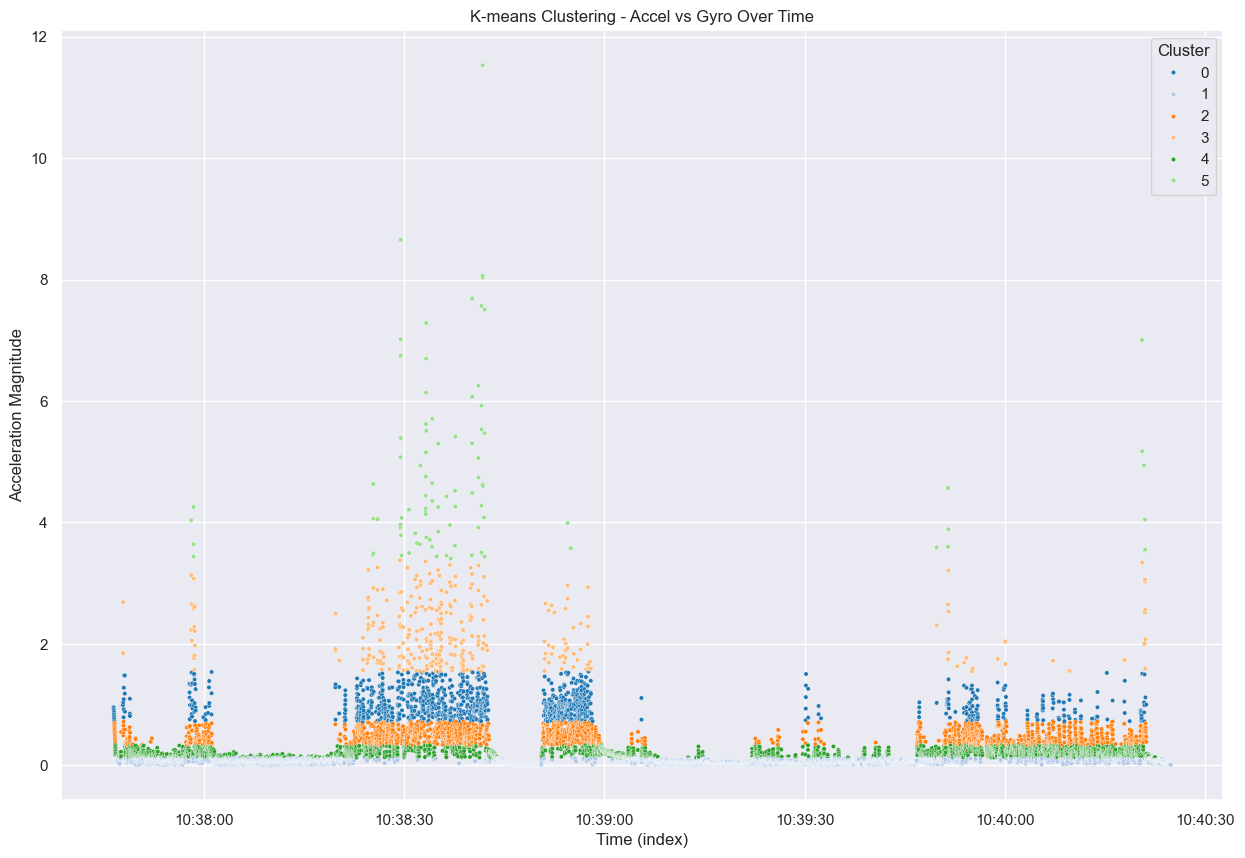

In [91]:
# Selecting only the 'accel_mag' feature for clustering
data = df_ref_over['accel_mag'].values.reshape(-1, 1)

# Compute K-means clustering with the desired number of clusters, say 12
centroids, distortion = kmeans(data, 6)

# Assign each sample to a cluster
idx, _ = vq(data, centroids)

# Add the cluster information to the original dataframe
df_ref_over['cluster'] = idx

# Plot the time series data with different colors for each cluster
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_ref_over.index, y='accel_mag', hue='cluster', data=df_ref_over, palette='tab20', s=10)
plt.title('K-means Clustering - Accel vs Gyro Over Time')
plt.xlabel('Time (index)')
plt.ylabel('Acceleration Magnitude')
plt.legend(title='Cluster')
plt.show()

## Clustering with Ruptures

Detected change points: [520, 1700, 2015, 2105, 2410, 5801]


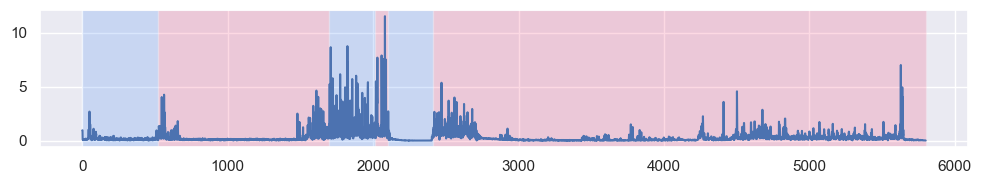

In [93]:
# calculate the magnitude of the acceleration and gyro
df_ref['accel_mag'] = np.sqrt(df_ref['accel_x']**2 + df_ref['accel_y']**2 + df_ref['accel_z']**2)
df_ref['gyro_mag'] = np.sqrt(df_ref['gyro_x']**2 + df_ref['gyro_y']**2 + df_ref['gyro_z']**2)

# Prepare your time series data: make sure it's a 1D array.
data = df_ref['accel_mag'].values

# Define the model. Here, 'l2' indicates we're looking for changes in mean.
# model = rpt.Pelt(model='l2').fit(data)
# model = rpt.Binseg(model='l2').fit(data)
model = rpt.Window(model='l2').fit(data)
# model = rpt.Dynp(model='l2').fit(data)

# Predict change points. This method takes the penalty value as an argument.
change_points = model.predict(n_bkps=5)

# Display the detected change points
print("Detected change points:", change_points)

# Visualizing the results
rpt.display(data, change_points)
plt.show()

In [94]:
# Create an array of zone labels based on the change points
zone_labels = np.arange(len(change_points))

# Initialize a new column 'infer_zone' in the DataFrame with zeros
df_ref['infer_zone'] = 0

# Loop through the change points and assign the appropriate zone labels
for i, change_point in enumerate(change_points):
    if i == 0:
        df_ref.loc[:change_point, 'infer_zone'] = zone_labels[i]
    else:
        df_ref.loc[change_points[i-1]:change_point, 'infer_zone'] = zone_labels[i]


In [95]:
# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w', 'infer_zone']
df_ref_over_infer = df_ref[columns].copy()

# resample the dataset
df_ref_over_infer = df_ref_over_infer.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

# turn the infer_zone column into int
df_ref_over_infer['infer_zone'] = df_ref_over_infer['infer_zone'].astype(int)

# Calculate acceleration magnitude and gyro magnitude for each row
df_ref_over_infer['accel_mag'] = np.sqrt(df_ref_over_infer['accel_x']**2 + df_ref_over_infer['accel_y']**2 + df_ref_over_infer['accel_z']**2)
df_ref_over_infer['gyro_mag'] = np.sqrt(df_ref_over_infer['gyro_x']**2 + df_ref_over_infer['gyro_y']**2 + df_ref_over_infer['gyro_z']**2)

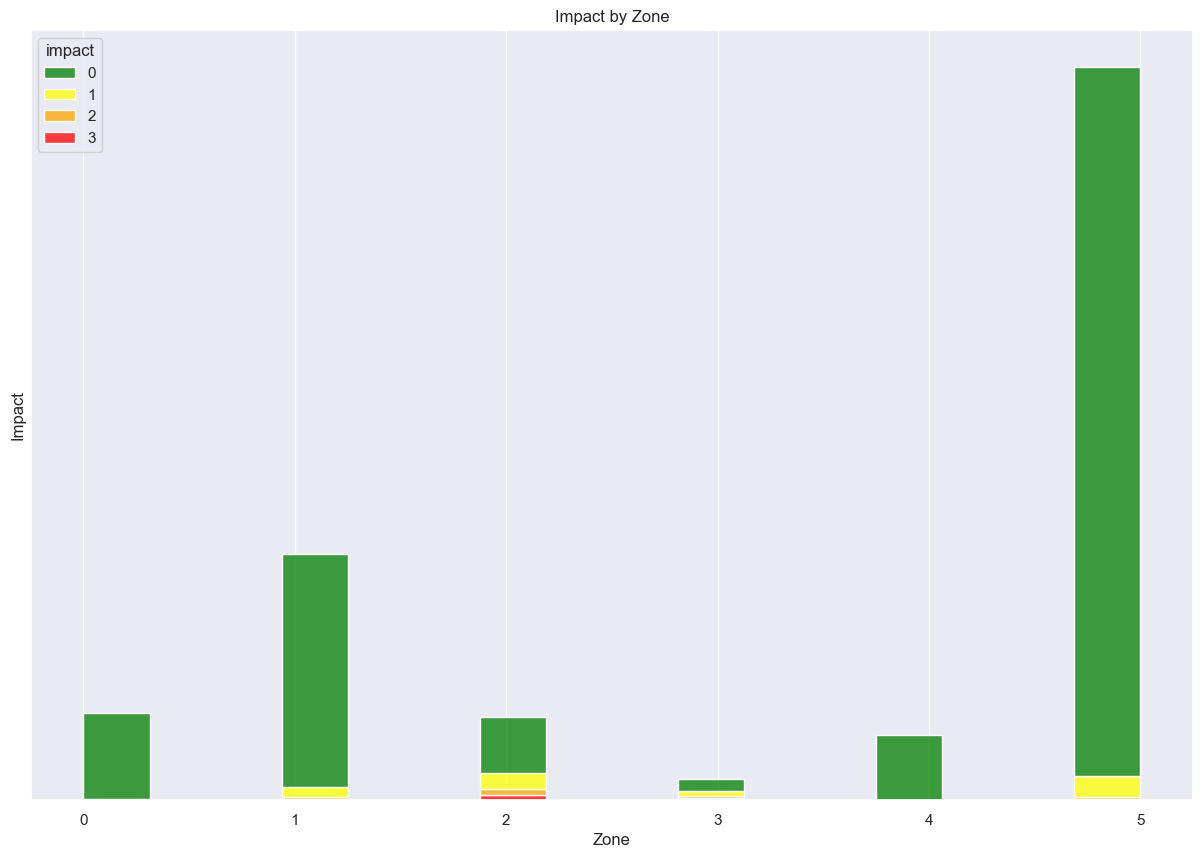

In [96]:
# Define impact thresholds
critical_thresholds = [1.0, 2.0, 3.0]

# Create a new column 'impact' with default value 0
df_ref_over_infer['impact'] = 0

# Loop through the thresholds and assign the appropriate impact values
for i, threshold in enumerate(critical_thresholds):
    if i == 0:
        df_ref_over_infer.loc[df_ref_over_infer['accel_mag'] > threshold, 'impact'] = i + 1
    else:
        df_ref_over_infer.loc[df_ref_over_infer['accel_mag'] > threshold, 'impact'] = i + 1

# set colors [green, yellow, orange, red]
colors = ['green', 'yellow', 'orange', 'red']

# plot histogram of the impact for each zone, zones are the x axis and the impact is the y axis
plt.figure(figsize=(15, 10))
sns.histplot(data=df_ref_over_infer, x='infer_zone', hue='impact', multiple='stack', palette=colors)
plt.title('Impact by Zone')
plt.xlabel('Zone')
plt.ylabel('Impact')
# hide y axis ticks
plt.yticks([])
# show x axis ticks
plt.xticks(np.arange(0, len(df_ref_over_infer['infer_zone'].unique()), 1))
plt.show()



## Datasets Comparison

In [25]:
# dataset folder
dataset_folder = "acquisitions/onsite_test/processed/20240215/"

# create a list with the names of the datasets
datasets_names = [
    'apple1_test1.csv',
    'apple2_test1.csv',
]

# create a list with the datasets
apple_datasets = []

# loop through the names and append the datasets to the list
for name in datasets_names:
    apple_datasets.append(pd.read_csv(dataset_folder+name))
    # convert the _time column to datetime
    apple_datasets[-1]['_time'] = pd.to_datetime(apple_datasets[-1]['_time'])


In [26]:
# add magnitude columns
for i in range(len(apple_datasets)):
    # if it doesn't have the magnitude columns
    if 'accel_mag' not in apple_datasets[i].columns:
        # calculate acceleration magnitude and gyro magnitude for each row
        apple_datasets[i]['accel_mag'] = np.sqrt(apple_datasets[i]['accel_x']**2 + apple_datasets[i]['accel_y']**2 + apple_datasets[i]['accel_z']**2)
        apple_datasets[i]['gyro_mag'] = np.sqrt(apple_datasets[i]['gyro_x']**2 + apple_datasets[i]['gyro_y']**2 + apple_datasets[i]['gyro_z']**2)

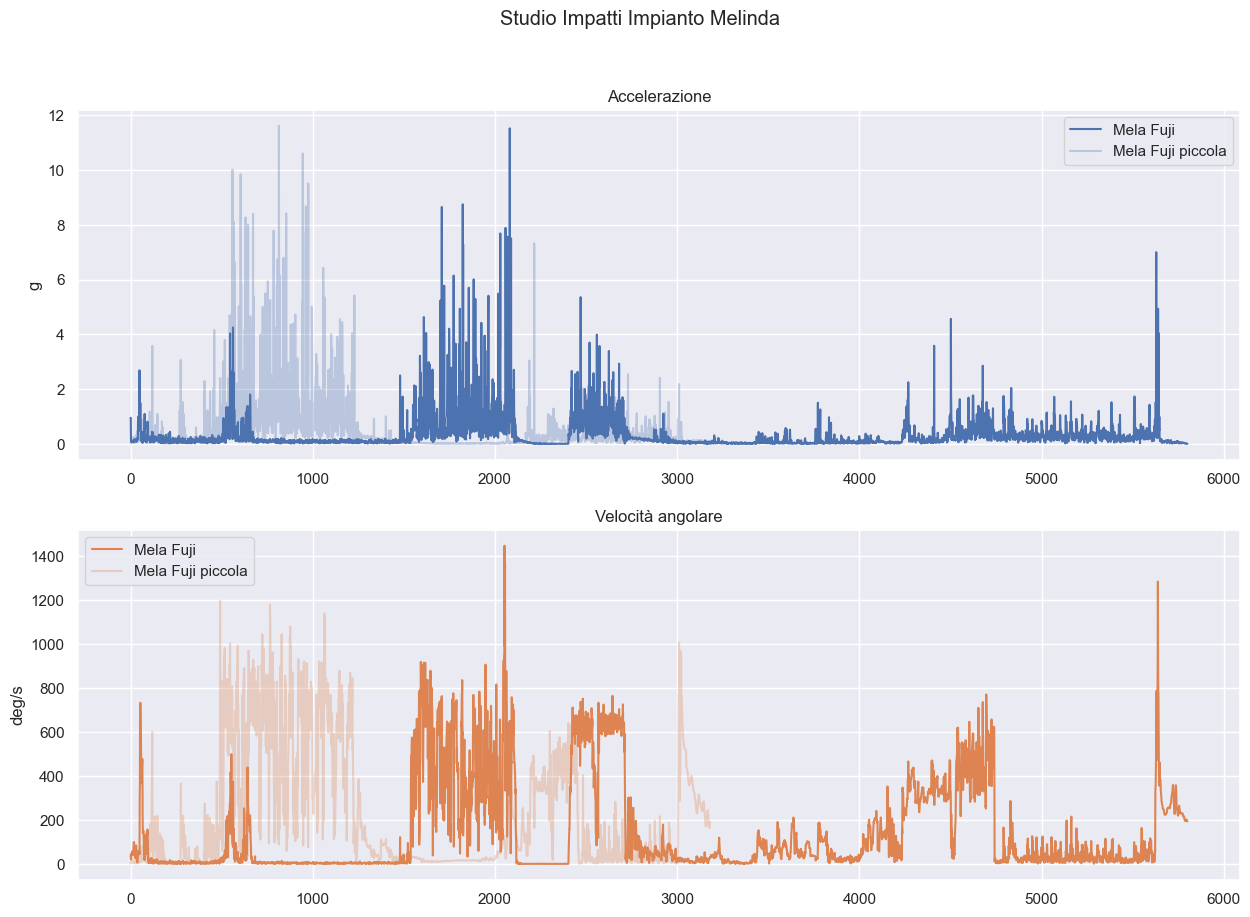

In [27]:
# plot the magnitude of the acceleration of the first dataset
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Studio Impatti Impianto Melinda")

axs[0].set_title('Accelerazione')
axs[0].plot(apple_datasets[0]['accel_mag'], label='Mela Fuji', color='C0')
axs[0].plot(apple_datasets[1]['accel_mag'], label='Mela Fuji piccola', color='C0', alpha=0.3)
axs[0].set_ylabel('g')
axs[0].legend()

axs[1].set_title('Velocità angolare')
axs[1].plot(apple_datasets[0]['gyro_mag'], label='Mela Fuji', color='C1')
axs[1].plot(apple_datasets[1]['gyro_mag'], label='Mela Fuji piccola', color='C1', alpha=0.3)
axs[1].set_ylabel('deg/s')
axs[1].legend()

plt.show()

0. rullo trasportatore - mela sta immobile, rimane bloccata tra due rulli ciliindrici - accelerazioni e velocità angolare sono nulle
1. macchinario 1 - mela inizia a ruotare e traslare lateralmente saltellando tra i rulli, si scontra con le altre mele e con i rulli -  accelerazioni più elevate, velocità angolare più elevata
2. curva a 90 con acqua - le mele galleggiano con il picciolo verso l'alto e occassionalmente si scontrano tra loro, verso la fine della curva si accumulano per entrare nel prossimo macchinario - accelerazioni e velocità ancgolari poco elevate
3. macchinario 2 - smista le mele in dei canali con un rullo a pettine rotante - accelerazioni e velocità angolari elevate
4. guida lineare - le mele ruotano e si spostano lateralmente su una guida lineare - accelerazioni non elevate ma velocità angolari elevate
5. macchinario 3 - vengono fatte 70 foto a ciacuna mela venendo trasportate su dei carrelli - accelerazioni e velocità angolari molto basse

In [28]:
# add a zone column to the first dataset and set it to 0 and set the zones
# apple_datasets[0]['zone'] = 0
# apple_datasets[0].loc[0:465, 'zone'] = 0
# apple_datasets[0].loc[401:1600, 'zone'] = 1
# apple_datasets[0].loc[1601:2515, 'zone'] = 2
# apple_datasets[0].loc[2516:2625, 'zone'] = 3
# apple_datasets[0].loc[2626:3105, 'zone'] = 4
# apple_datasets[0].loc[3106:, 'zone'] = 5

# remove rows from 3680
# apple_datasets[0] = apple_datasets[0].iloc[:3680]

# save the dataset
# apple_datasets[0].to_csv("acquisitions/onsite_test/processed/processed_5_apple_plant_2024-01-26.csv", index=False)


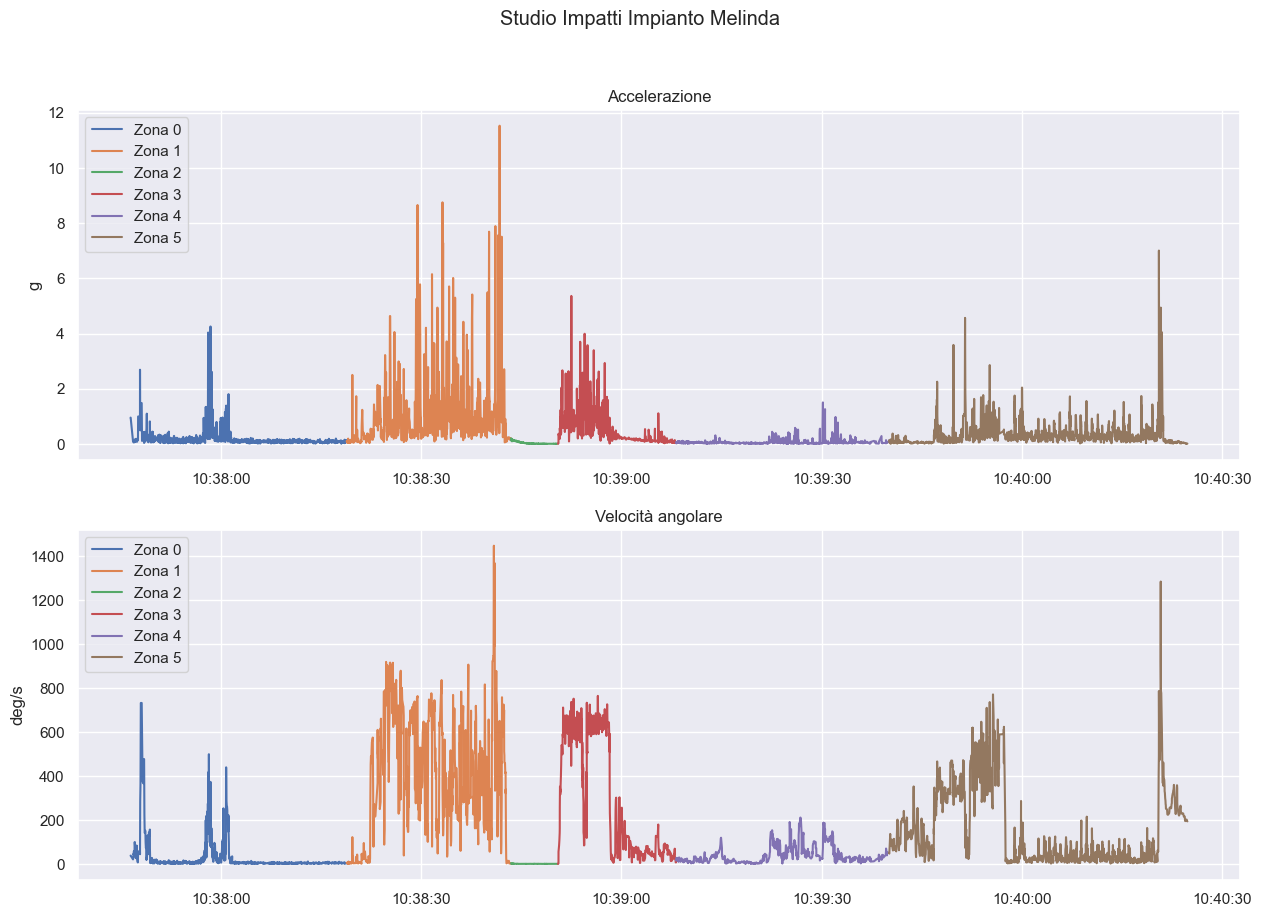

In [29]:
# group by zone and get the mean
grouped_byzone = apple_datasets[0].groupby('zone')
# plot each zone against _time, accel_mag and gyro_mag
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Studio Impatti Impianto Melinda")

for name, group in grouped_byzone:
    axs[0].plot(group['_time'], group['accel_mag'], label=f'Zona {name}')
    axs[1].plot(group['_time'], group['gyro_mag'], label=f'Zona {name}')

axs[0].set_title('Accelerazione')
axs[0].set_ylabel('g')
axs[0].legend()

axs[1].set_title('Velocità angolare')
axs[1].set_ylabel('deg/s')
axs[1].legend()

plt.show()


In [30]:
# statistical study for each zone

# To store statistical results for each zone
zone_stats = {}

for name, group in grouped_byzone:

    # Outlier detection using Z-score
    z_scores = np.abs(stats.zscore(group['accel_mag']))
    outliers = group[z_scores > 3]  # Considering points with Z-score >3 as outliers

    # Descriptive statistics
    mean_val = group['accel_mag'].mean()
    median_val = group['accel_mag'].median()
    std_dev = group['accel_mag'].std()
    # IQR
    Q1 = group['accel_mag'].quantile(0.25)
    Q3 = group['accel_mag'].quantile(0.75)
    IQR = Q3 - Q1
    # Outliers based on IQR
    outlier_condition = ((group['accel_mag'] < (Q1 - 1.5 * IQR)) | (group['accel_mag'] > (Q3 + 1.5 * IQR)))
    outliers_iqr = group[outlier_condition]

    # Store results in the dictionary
    zone_stats[name] = {
        'mean': mean_val,
        'median': median_val,
        'std_dev': std_dev,
        'IQR': IQR,
        'outliers_z_score': outliers,
        'outliers_iqr': outliers_iqr,
    }

    # Print the results for each zone
    print(f"Zone {name} analysis:")
    print(f"Mean acceleration magnitude: {mean_val:.2f}")
    print(f"Median acceleration magnitude: {median_val:.2f}")
    print(f"Standard deviation: {std_dev:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Number of outliers (Z-score method): {len(outliers)}")
    print(f"Number of outliers (IQR method): {len(outliers_iqr)}")
    print("\n")

Zone 0 analysis:
Mean acceleration magnitude: 0.17
Median acceleration magnitude: 0.10
Standard deviation: 0.29
IQR: 0.08
Number of outliers (Z-score method): 28
Number of outliers (IQR method): 146


Zone 1 analysis:
Mean acceleration magnitude: 1.02
Median acceleration magnitude: 0.61
Standard deviation: 1.29
IQR: 0.81
Number of outliers (Z-score method): 17
Number of outliers (IQR method): 65


Zone 2 analysis:
Mean acceleration magnitude: 0.03
Median acceleration magnitude: 0.01
Standard deviation: 0.04
IQR: 0.03
Number of outliers (Z-score method): 4
Number of outliers (IQR method): 36


Zone 3 analysis:
Mean acceleration magnitude: 0.59
Median acceleration magnitude: 0.35
Standard deviation: 0.63
IQR: 0.80
Number of outliers (Z-score method): 13
Number of outliers (IQR method): 16


Zone 4 analysis:
Mean acceleration magnitude: 0.07
Median acceleration magnitude: 0.04
Standard deviation: 0.10
IQR: 0.04
Number of outliers (Z-score method): 19
Number of outliers (IQR method): 83




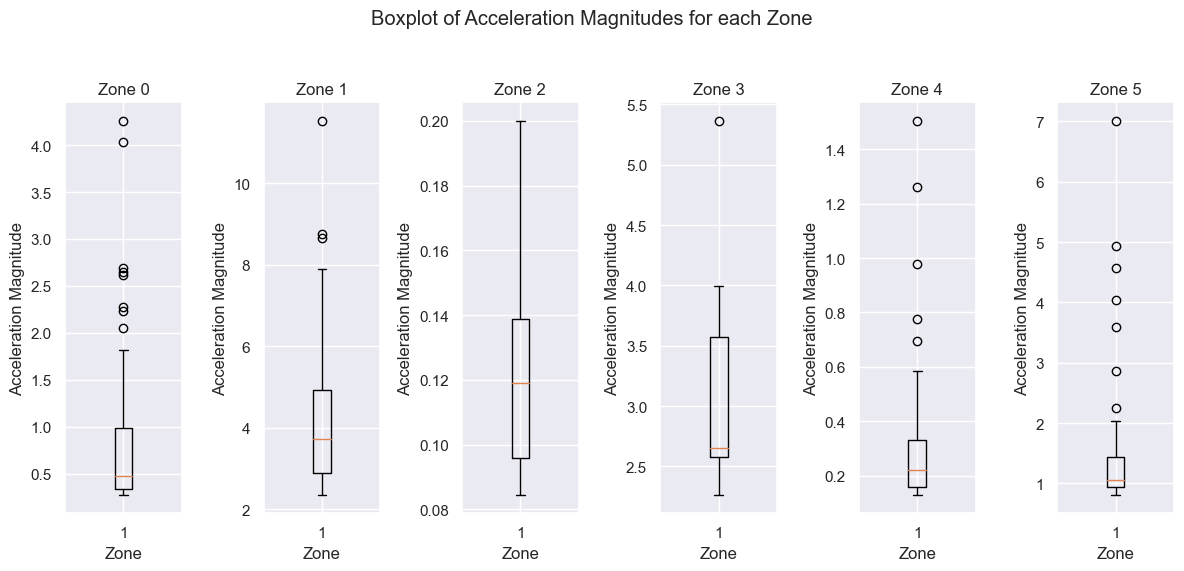

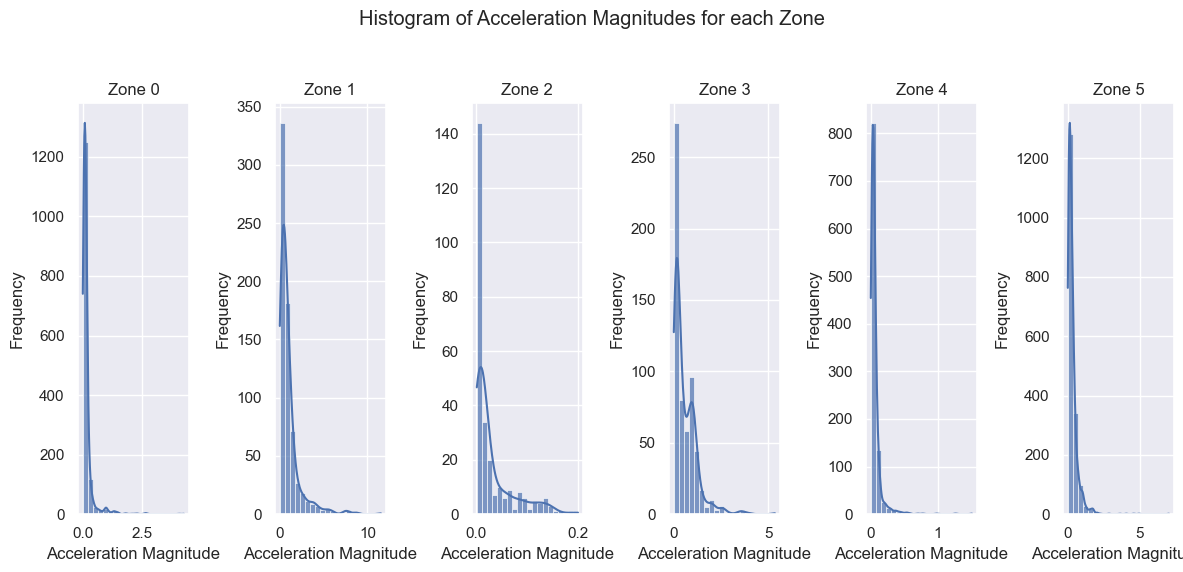

In [31]:
# Number of zones for plotting
num_zones = len(zone_stats)

# Set up the matplotlib figure for boxplots
plt.figure(figsize=(12, 6))
plt.suptitle('Boxplot of Acceleration Magnitudes for each Zone')
for i, (zone, status) in enumerate(zone_stats.items(), 1):
    plt.subplot(1, num_zones, i)
    plt.boxplot(status['outliers_iqr']['accel_mag'])
    plt.title(f'Zone {zone}')
    plt.xlabel('Zone')
    plt.ylabel('Acceleration Magnitude')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Set up the matplotlib figure for histograms without considering outliers
plt.figure(figsize=(12, 6))
plt.suptitle('Histogram of Acceleration Magnitudes for each Zone')
for i, (zone, group) in enumerate(grouped_byzone, 1):
    plt.subplot(1, num_zones, i)
    sns.histplot(group['accel_mag'], kde=True, bins=20, alpha=0.7)
    plt.title(f'Zone {zone}')
    plt.xlabel('Acceleration Magnitude')
    plt.ylabel('Frequency')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Set up the matplotlib figure for histograms
# plt.figure(figsize=(12, 6))
# plt.suptitle('Histogram of Acceleration Outliers for each Zone')
# for i, (zone, stats) in enumerate(zone_stats.items(), 1):
#     plt.subplot(1, num_zones, i)
#     plt.hist(stats['outliers_iqr']['accel_mag'], bins=20, alpha=0.7)
#     plt.title(f'Zone {zone}')
#     plt.xlabel('Acceleration Magnitude')
#     plt.ylabel('Frequency')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


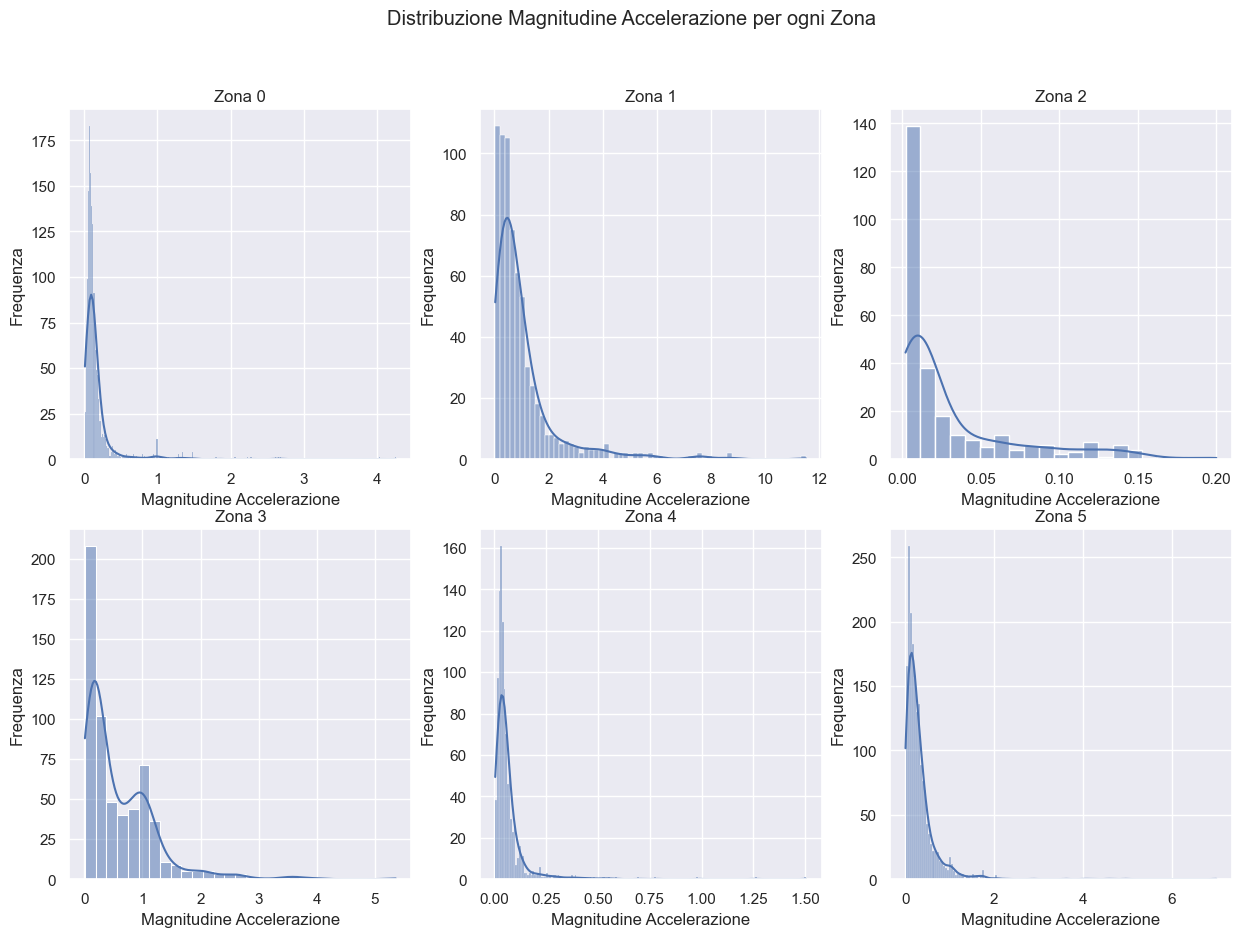

In [32]:
# plot the distribution of the acceleration magnitude for each zone, without outliers
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribuzione Magnitudine Accelerazione per ogni Zona")

for name, group in grouped_byzone:
    sns.histplot(group['accel_mag'], kde=True, ax=axs[name//3, name%3])
    axs[name//3, name%3].set_title(f'Zona {name}')
    axs[name//3, name%3].set_xlabel('Magnitudine Accelerazione')
    axs[name//3, name%3].set_ylabel('Frequenza')

plt.show()

From the Boxplots:

- You can see the median (the line in the middle of the box), which gives you a sense of the central tendency for acceleration magnitudes in each zone.
- The boxes represent the interquartile range (IQR), showing the middle 50% of the data.
- The "whiskers" extend to the furthest points that are not considered outliers, and the dots represent outlier values.
- Zone 1 appears to have a significantly higher range and variability in acceleration magnitudes compared to other zones, as well as numerous outliers.
- Zone 2 has a much tighter distribution, with outliers that appear quite far from the main cluster of data.
- Zones 0, 3, 4, and 5 show variability with some outliers, but not to the extent of Zone 1.

From the Histograms:

- These provide a sense of the distribution of acceleration magnitudes within each zone.
- Zone 1 shows a right-skewed distribution, with a long tail of higher magnitudes, which corresponds with the boxplot showing many outliers.
- Zones 2 seems to have a very narrow distribution, which is consistent with the low IQR and standard deviation, although outliers are still present.
- The other zones (0, 3, 4, and 5) have more normally distributed data, with some skewness and outliers.

Overall Analysis:

- Zone 1 stands out with a higher average acceleration magnitude and a larger number of outliers, indicating more frequent or more intense impacts in that zone.
- Zone 2, while having a consistent range of magnitudes, also has some extreme outliers that could be worth investigating further to understand their cause.
- The rest of the zones show varying degrees of impact intensity and frequency.

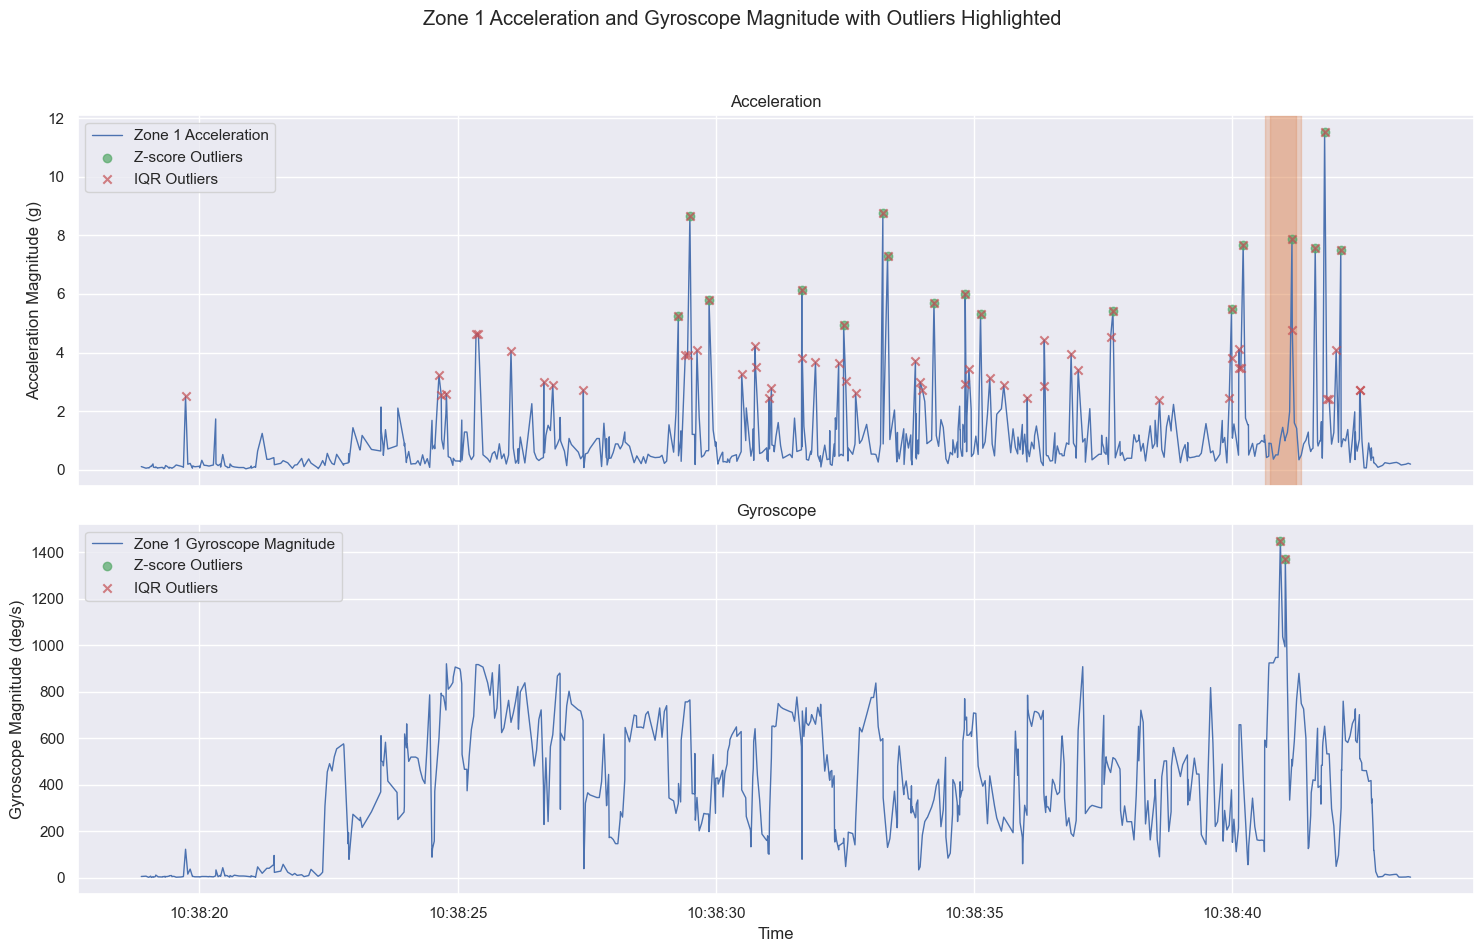

In [33]:
# Filter for Zone 1 data
zone_1_data = apple_datasets[0][apple_datasets[0]['zone'] == 1]

# Calculate Z-scores and IQR for both acceleration and gyroscope magnitudes
z_scores_accel = np.abs(stats.zscore(zone_1_data['accel_mag']))
z_threshold_accel = 3
outliers_z_accel = zone_1_data[z_scores_accel > z_threshold_accel]

Q1_accel = zone_1_data['accel_mag'].quantile(0.25)
Q3_accel = zone_1_data['accel_mag'].quantile(0.75)
IQR_accel = Q3_accel - Q1_accel
outliers_iqr_accel = zone_1_data[(zone_1_data['accel_mag'] < (Q1_accel - 1.5 * IQR_accel)) | (zone_1_data['accel_mag'] > (Q3_accel + 1.5 * IQR_accel))]

z_scores_gyro = np.abs(stats.zscore(zone_1_data['gyro_mag']))
z_threshold_gyro = 3
outliers_z_gyro = zone_1_data[z_scores_gyro > z_threshold_gyro]

Q1_gyro = zone_1_data['gyro_mag'].quantile(0.25)
Q3_gyro = zone_1_data['gyro_mag'].quantile(0.75)
IQR_gyro = Q3_gyro - Q1_gyro
outliers_iqr_gyro = zone_1_data[(zone_1_data['gyro_mag'] < (Q1_gyro - 1.5 * IQR_gyro)) | (zone_1_data['gyro_mag'] > (Q3_gyro + 1.5 * IQR_gyro))]

# Set up the plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Zone 1 Acceleration and Gyroscope Magnitude with Outliers Highlighted')

# Plot acceleration data with highlighted outliers in the first subplot
axs[0].plot(zone_1_data['_time'], zone_1_data['accel_mag'], label='Zone 1 Acceleration', linewidth=1)
axs[0].scatter(outliers_z_accel['_time'], outliers_z_accel['accel_mag'], color='C2', label='Z-score Outliers', zorder=5, alpha=0.7)
axs[0].scatter(outliers_iqr_accel['_time'], outliers_iqr_accel['accel_mag'], color='C3', label='IQR Outliers', zorder=5, alpha=0.7, marker='x')
axs[0].set_title('Acceleration')
axs[0].set_ylabel('Acceleration Magnitude (g)')
axs[0].legend()

# Plot gyroscope data with highlighted outliers in the second subplot
axs[1].plot(zone_1_data['_time'], zone_1_data['gyro_mag'], label='Zone 1 Gyroscope Magnitude', linewidth=1)
axs[1].scatter(outliers_z_gyro['_time'], outliers_z_gyro['gyro_mag'], color='C2', label='Z-score Outliers', zorder=5, alpha=0.7)
axs[1].scatter(outliers_iqr_gyro['_time'], outliers_iqr_gyro['gyro_mag'], color='C3', label='IQR Outliers', zorder=5, alpha=0.7, marker='x')
axs[1].set_title('Gyroscope')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Gyroscope Magnitude (deg/s)')
axs[1].legend()

# Define a time delta for making the band wider
time_delta = pd.Timedelta(seconds=0.3)

# Highlight periods with gyroscope outliers on the acceleration plot
for outlier_time in outliers_z_gyro['_time']:
    axs[0].axvspan(outlier_time - time_delta, outlier_time + time_delta, color='C1', alpha=0.3)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [34]:
zone_1_data['_time'] = pd.to_datetime(zone_1_data['_time'])
zone_1_data.set_index('_time', inplace=True)

C:\Users\MegaN\AppData\Local\Temp\ipykernel_2164\386170177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_1_data['_time'] = pd.to_datetime(zone_1_data['_time'])


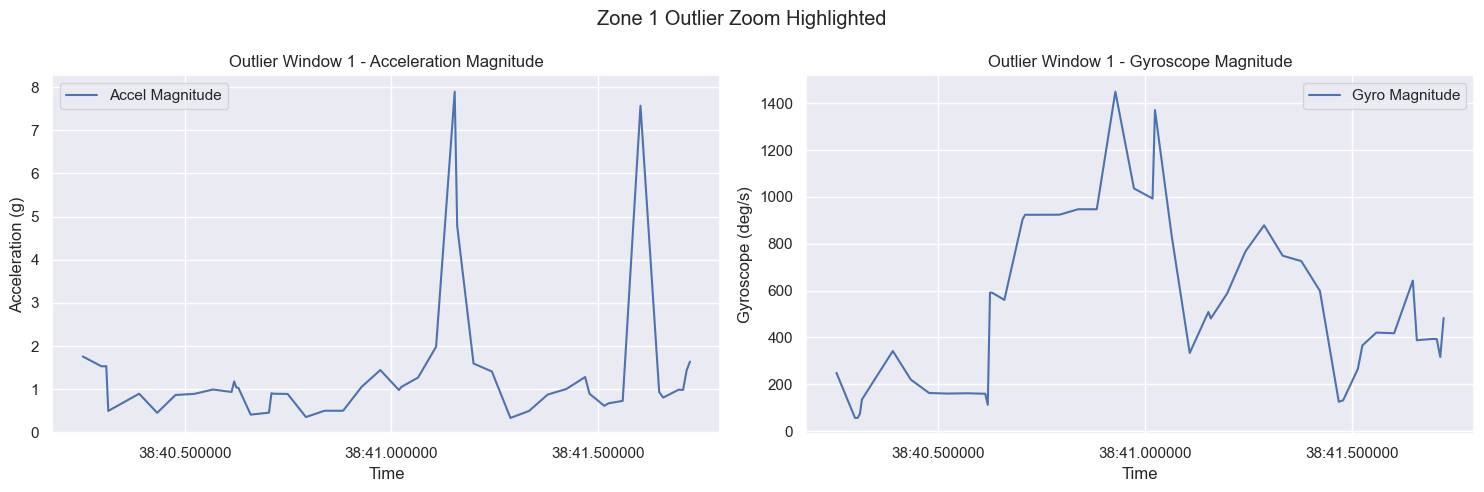

In [14]:
# Calculate Z-scores for the gyroscope magnitudes
z_scores_gyro = np.abs(stats.zscore(zone_1_data['gyro_mag']))
z_threshold = 3
outliers_z_gyro = zone_1_data[z_scores_gyro > z_threshold]

# Define a time delta for the window around each outlier
time_delta = pd.Timedelta(seconds=0.7)

# Cluster outliers that are close to each other
clustered_outliers = []
last_time = None

for outlier_time in outliers_z_gyro.index:
    if last_time and outlier_time - last_time <= time_delta:
        clustered_outliers[-1].append(outlier_time)
    else:
        clustered_outliers.append([outlier_time])
    last_time = outlier_time

# Determine outlier windows, ensuring no overlap
outlier_windows = []
for cluster in clustered_outliers:
    start_time = cluster[0] - time_delta
    end_time = cluster[-1] + time_delta
    # Add window if it does not overlap with previous one
    if not outlier_windows or start_time > outlier_windows[-1][1]:
        outlier_windows.append((start_time, end_time))

# Create subplots for each outlier window
num_windows = len(outlier_windows)
fig, axs = plt.subplots(num_windows, 2, figsize=(15, 5 * num_windows))
# add a title to the figure
fig.suptitle('Zone 1 Outlier Zoom Highlighted')
# If only one window, adjust the indexing
if num_windows == 1:
    axs = axs.reshape(1, -1)

# Loop through each window and plot the accel and gyro data
for i, (start_time, end_time) in enumerate(outlier_windows):
    # Select the data for the current window
    window_data = zone_1_data.loc[start_time:end_time]

    if window_data.empty:
        continue  # Skip this window if there's no data

    # # Plot acceleration data for x, y, z axes in the first column
    # axs[i, 0].plot(window_data.index, window_data['accel_x'], label='Accel X')
    # axs[i, 0].plot(window_data.index, window_data['accel_y'], label='Accel Y')
    # axs[i, 0].plot(window_data.index, window_data['accel_z'], label='Accel Z')
    # axs[i, 0].set_title(f'Outlier Window {i+1} - Acceleration')
    # axs[i, 0].legend()

    # # Plot gyroscope data for x, y, z axes in the second column
    # axs[i, 1].plot(window_data.index, window_data['gyro_x'], label='Gyro X')
    # axs[i, 1].plot(window_data.index, window_data['gyro_y'], label='Gyro Y')
    # axs[i, 1].plot(window_data.index, window_data['gyro_z'], label='Gyro Z')
    # axs[i, 1].set_title(f'Outlier Window {i+1} - Gyroscope')
    # axs[i, 1].legend()

    # plot the magnitude of the acceleration and the gyroscope
    axs[i, 0].plot(window_data.index, window_data['accel_mag'], label='Accel Magnitude')
    axs[i, 0].set_title(f'Outlier Window {i+1} - Acceleration Magnitude')
    axs[i, 0].legend()

    axs[i, 1].plot(window_data.index, window_data['gyro_mag'], label='Gyro Magnitude')
    axs[i, 1].set_title(f'Outlier Window {i+1} - Gyroscope Magnitude')
    axs[i, 1].legend()

# Set labels for axes
for ax in axs[:, 0]:
    ax.set_ylabel('Acceleration (g)')
for ax in axs[:, 1]:
    ax.set_ylabel('Gyroscope (deg/s)')
for ax in axs[-1, :]:
    ax.set_xlabel('Time')

# Adjust layout
plt.tight_layout()
plt.show()

## Impact Detection 

In [17]:
# dataset folder
acquisition_path = "acquisitions/onsite_test/processed/20240215/apple1_test1.csv"
impacts_path = "acquisitions/synthetic_test/processed/impacts_dataset.csv"

# create the datasets
df = pd.read_csv(acquisition_path)
df_impacts = pd.read_csv(impacts_path)

# convert the _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_impacts['_time'] = pd.to_datetime(df_impacts['_time'])



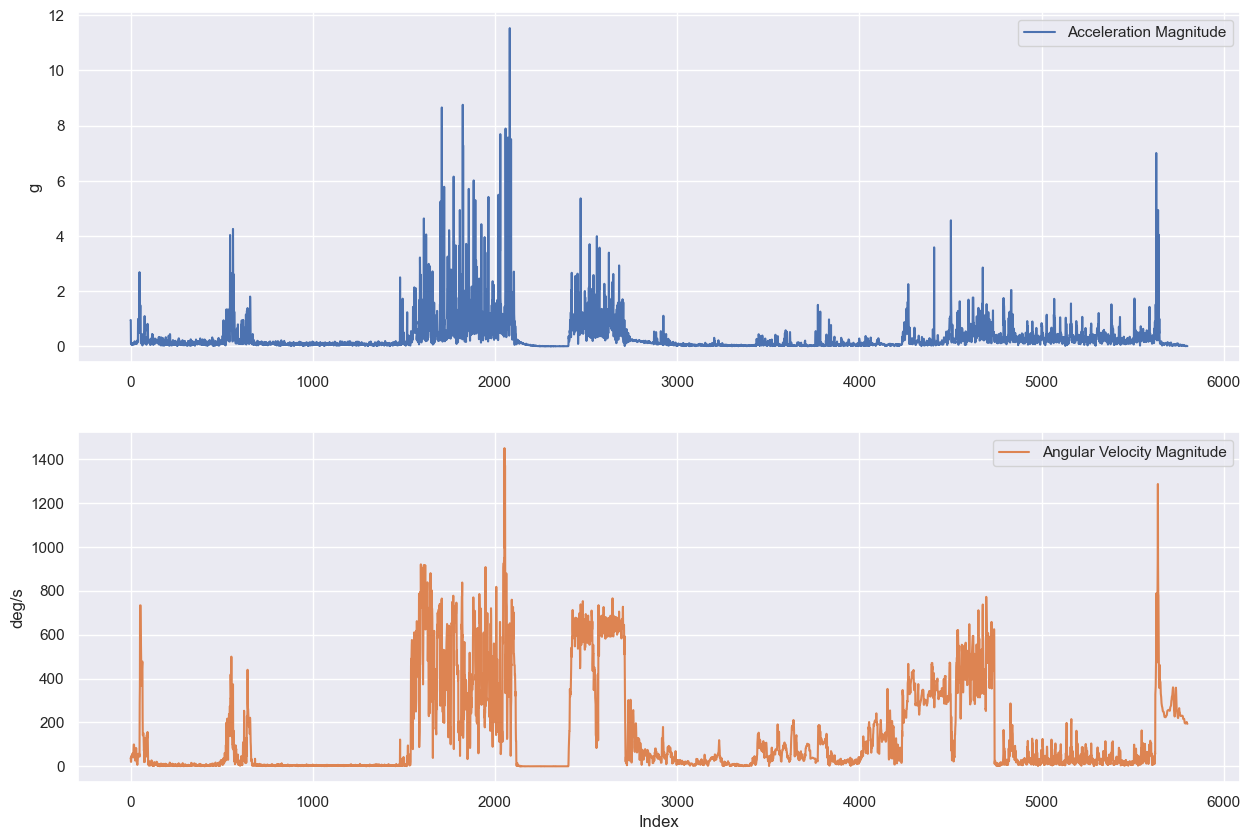

In [22]:
# plot magnitude of the acceleration and the gyro
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].plot(df['accel_mag'], label='Acceleration Magnitude', color='C0')
axs[0].set_ylabel('g')
axs[0].legend()

axs[1].plot(df['gyro_mag'], label='Angular Velocity Magnitude', color='C1')
axs[1].set_ylabel('deg/s')
axs[1].set_xlabel('Index')
axs[1].legend()

plt.show()


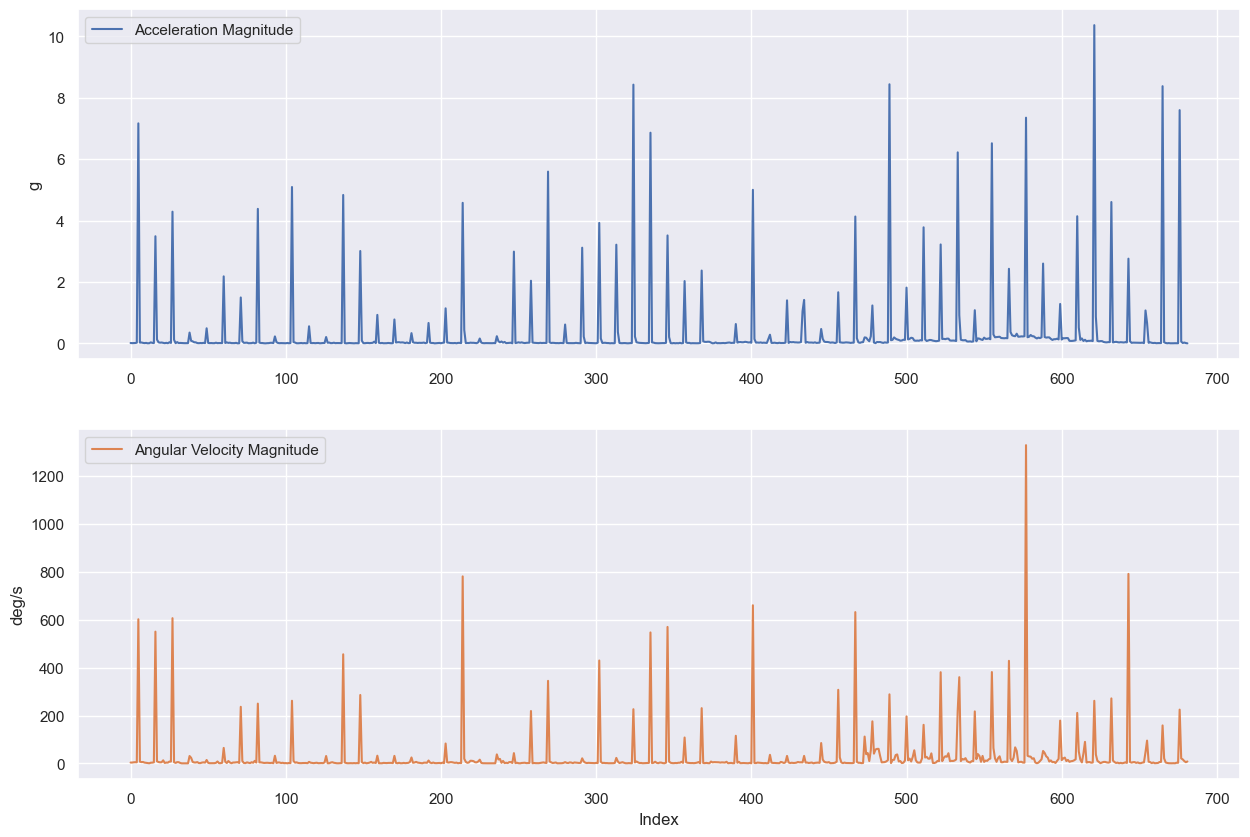

In [23]:
# plot the magnitude of the acceleration and the gyro of the impacts
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].plot(df_impacts['accel_mag'], label='Acceleration Magnitude', color='C0')
axs[0].set_ylabel('g')
axs[0].legend()

axs[1].plot(df_impacts['gyro_mag'], label='Angular Velocity Magnitude', color='C1')
axs[1].set_ylabel('deg/s')
axs[1].set_xlabel('Index')
axs[1].legend()

plt.show()

In [57]:
impact0 = df_impacts[df_impacts['impact_id'] == 1]

In [58]:
# zip acceleration and gyro magnitudes
accel_zip = np.array(list(zip(df['accel_mag'], df['gyro_mag'])))
impacts_zip = np.array(list(zip(impact0['accel_mag'], impact0['gyro_mag'])))

In [59]:
# Calculate the DTW distance between the two sequences
distance_zip = dtw_ndim.distance(accel_zip, impacts_zip)
print("DTW Multivariate Distance: ", distance_zip)

# plot the cost matrix and the best path
d, paths = dtw_ndim.warping_paths(accel_zip, impacts_zip)
best_path = dtw.best_path(paths)

# dtwvis.plot_warpingpaths(accel_zip, impacts_zip, paths, best_path)

# normalize the score by dividing the last value of the best path by the length of the best path
score = paths[best_path[-1][0], best_path[-1][1]] / len(best_path)
print("DTW Multivariate Normalized Distance: ", score)

DTW Multivariate Distance:  15451.347569293477
DTW Multivariate Normalized Distance:  2.676427135075815


In [82]:
def sliding_window(sequence, window_size=11, overlap=5):
    start = 0
    while start + window_size <= len(sequence):
        yield sequence[start:start+window_size]
        start += window_size - overlap

In [61]:
# Initialize variables for DTW calculation
window_size = 11
overlap = 0
normalized_scores = []
windows_start_indices = []
current_start_index = 0  # Correct initialization

# Example DTW calculation for each window (pseudo-code context)
for window in sliding_window(accel_zip, window_size, overlap):
    distance = dtw_ndim.distance(window, impacts_zip)
    normalized_score = distance / window_size  # Example normalization
    normalized_scores.append(normalized_score)
    windows_start_indices.append(current_start_index)
    current_start_index += window_size - overlap  # Update the start index for the next window

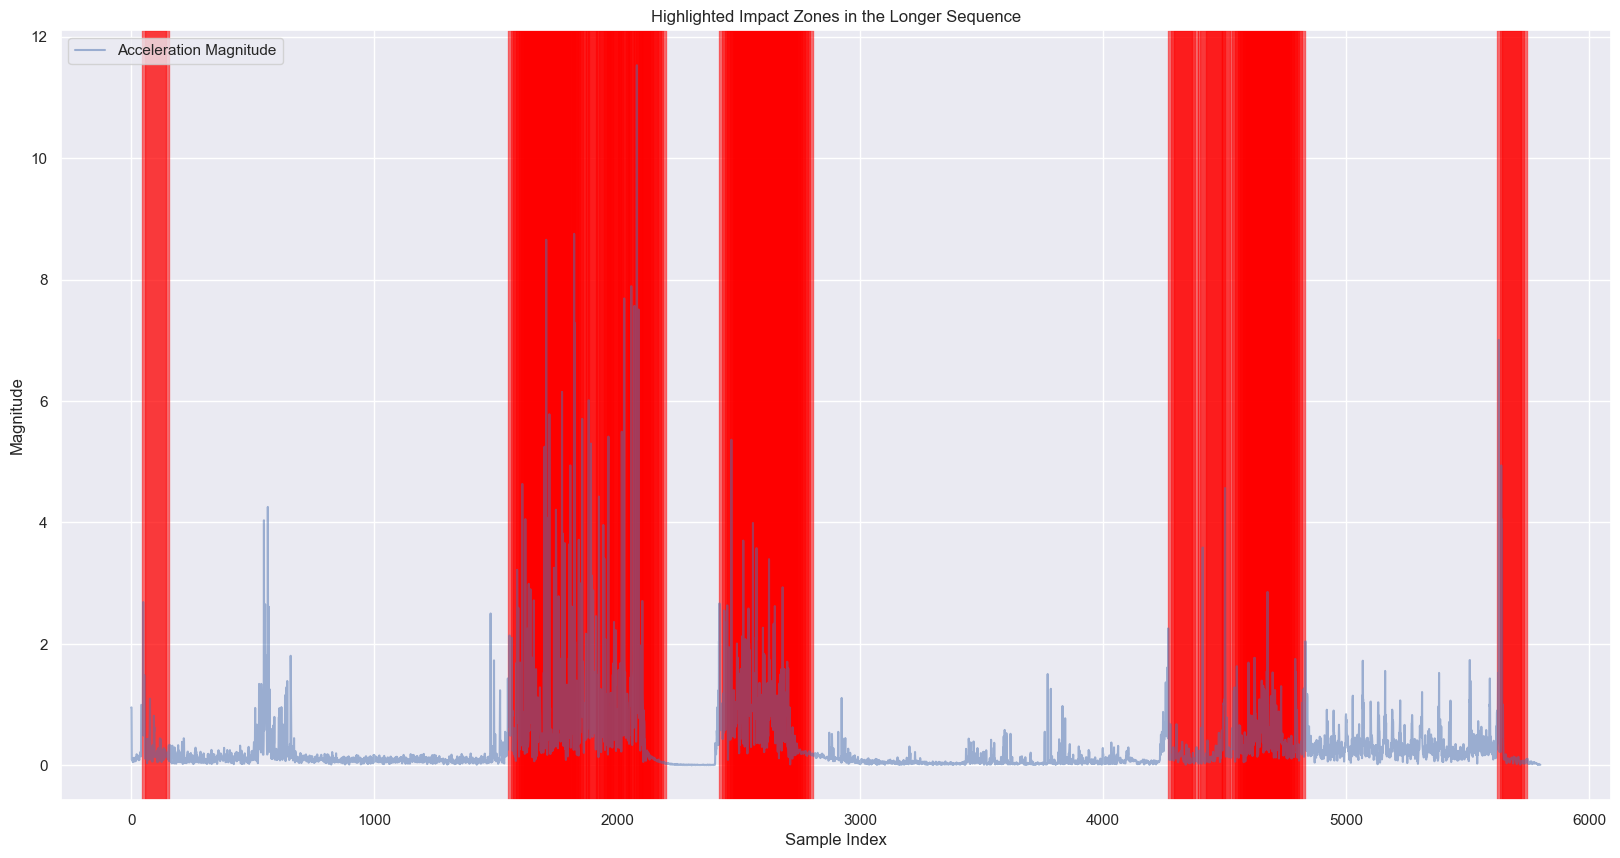

In [86]:
# Plot settings
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['accel_mag'], label='Acceleration Magnitude', alpha=0.5)  # Example plot

# Highlight matching zones
threshold = 100.0  # Example threshold, adjust based on your analysis
for start_index, score in zip(windows_start_indices, normalized_scores):
    if score > threshold:  # Assuming lower scores indicate closer matches
        plt.axvspan(start_index, start_index + window_size, color='red', alpha=0.5)

plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.title('Highlighted Impact Zones in the Longer Sequence')
plt.legend()
plt.show()

In [89]:
# Assume df is the long sequence and df_impacts contains all impacts
num_impacts = df_impacts['impact_id'].max() + 1  # Adjust based on your dataset
window_size = 11
overlap = 10

# Initialize a matrix to store DTW scores
dtw_scores_matrix = np.zeros((num_impacts, len(df) // (window_size - overlap)))

for impact_id in range(num_impacts):
    impact_data = df_impacts[df_impacts['impact_id'] == impact_id]
    impacts_zip = np.array(list(zip(impact_data['accel_mag'], impact_data['gyro_mag'])))
    
    for i, window in enumerate(sliding_window(df[['accel_mag', 'gyro_mag']].to_numpy(), window_size, overlap)):
        if len(window) < window_size:  # Skip incomplete windows
            continue
        distance = dtw_ndim.distance(window, impacts_zip)
        normalized_score = distance / window_size
        dtw_scores_matrix[impact_id, i] = normalized_score


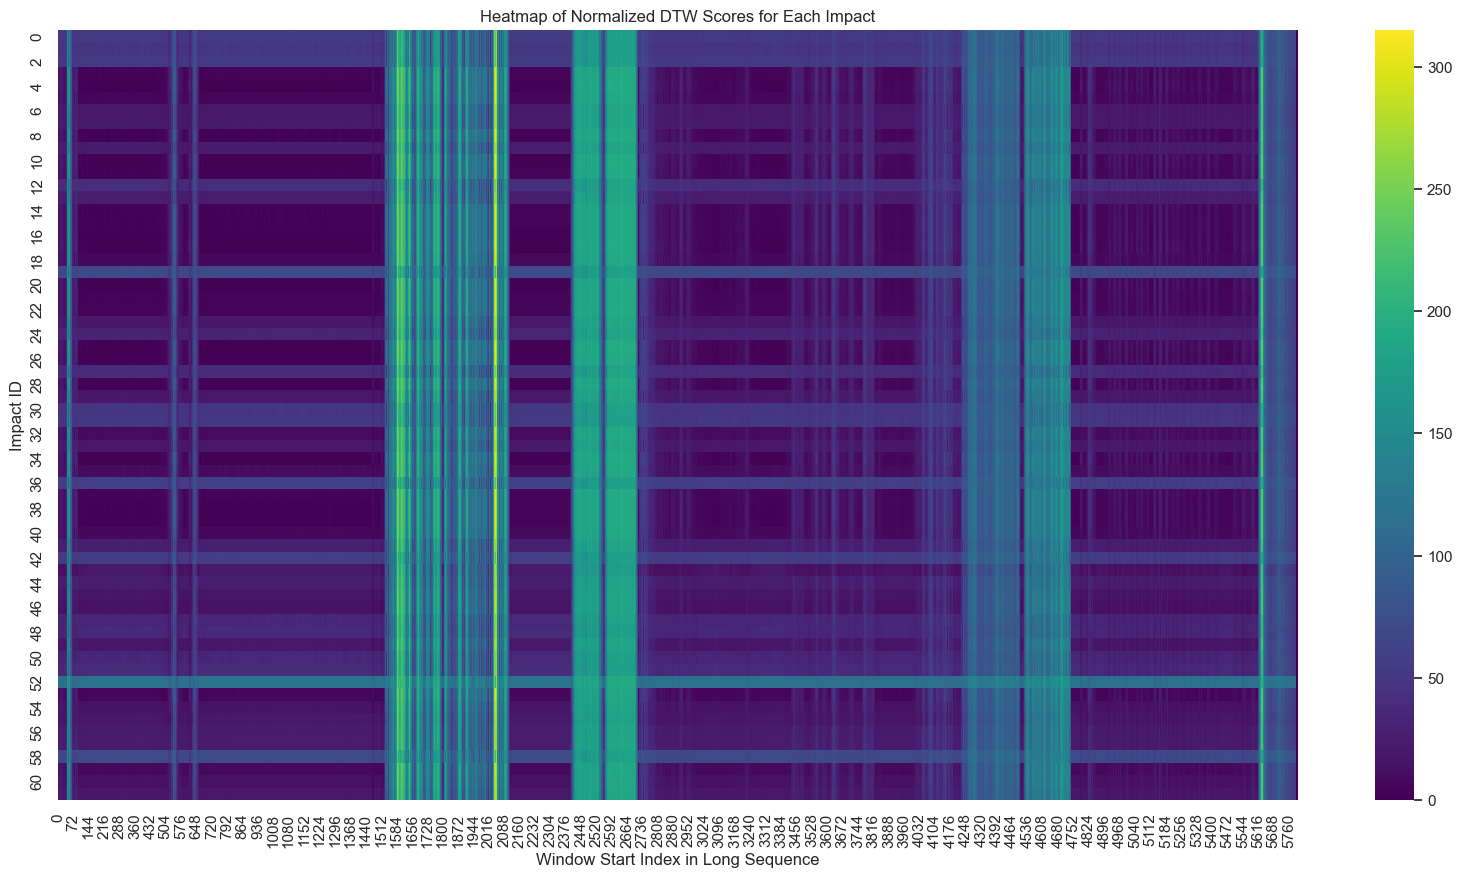

In [90]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(dtw_scores_matrix, cmap='viridis')
ax.set_title('Heatmap of Normalized DTW Scores for Each Impact')
ax.set_xlabel('Window Start Index in Long Sequence')
ax.set_ylabel('Impact ID')
plt.show()


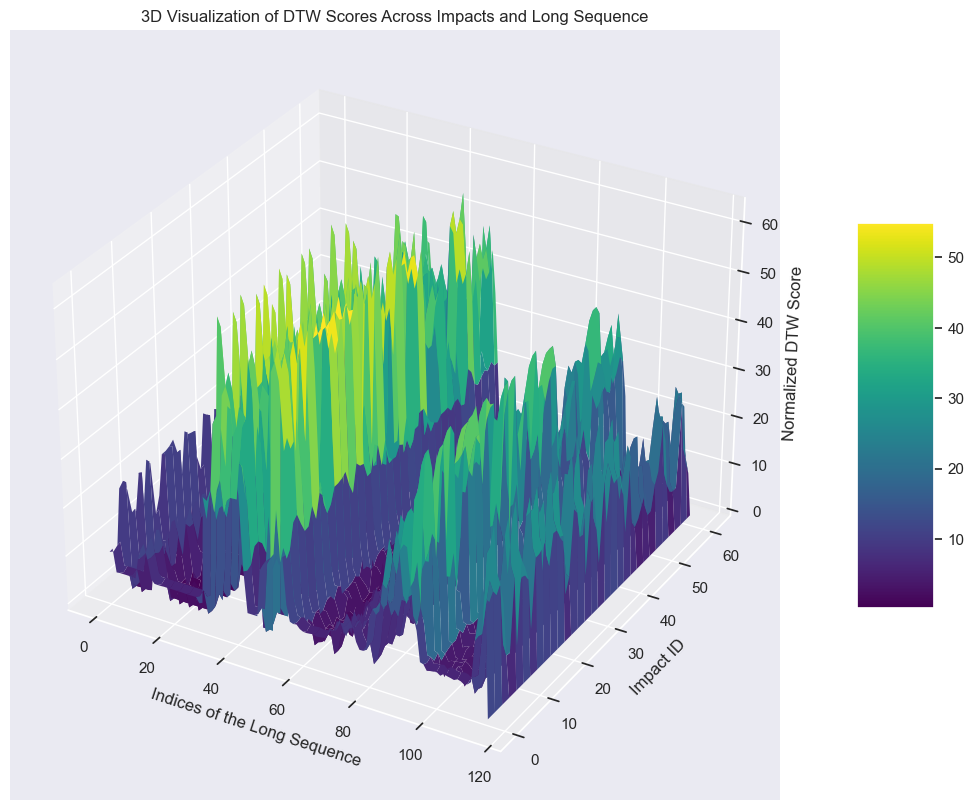

In [88]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Set up the figure and 3D axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D plotting
# X: Indices of the long sequence (sliding window start indices)
# Y: Impact IDs
# Z: DTW scores (we'll use the scores directly as the Z values)
X, Y = np.meshgrid(range(dtw_scores_matrix.shape[1]), range(dtw_scores_matrix.shape[0]))
Z = dtw_scores_matrix

# Plotting
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel('Indices of the Long Sequence')
ax.set_ylabel('Impact ID')
ax.set_zlabel('Normalized DTW Score')
ax.set_title('3D Visualization of DTW Scores Across Impacts and Long Sequence')

# Color bar to indicate the scale of DTW scores
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
